# Comparing Neural Nets on Heart Failure Data Using SVMs and MLPs

This notebook is training the models

## Introduction

The data that we are using can be found at the following link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

It is a combination of 5 UCI Machine Learning datasets and is freely available on Kaggle

There is a mix of numerical and categorical data so the EDA will look at both individually

The features will be used to predict whether heart disease is present 

Descriptions of the features can be found at the link above and at UCI machine learning repositoryor not

## Installing Packages

In [1]:
#!pip install pandas==2.2.1
#!pip install scipy==1.13.0
#!pip install matplotlib==3.8.4
#!pip install seaborn==0.13.2
#!pip install scikit-learn==1.4.0
#!pip install torch==2.2.2
#!pip install skorch==0.15.0
#!pip install joblib==1.4.0

## Importing Packages

In [2]:
#not all of these are used but were imported for testing at one point or another

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint

import sklearn
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import time

import joblib
from joblib import dump #added to save parameters and models

#adding this as for the countplots my code was working but was a huge error that was not problematic while running with the selected libararies
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#added so i can easily create a results section at the end of the notebook without having to write the plot code again
from IPython.display import Image

## EDA and Initial Pre-Processing

In this section we will begin our EDA and some simple pre-processing that comes as a result of EDA for example dealing with wrong data or renaming variables etc

In [3]:
df = pd.read_csv('heart.csv')
df_heart = df.copy()
df_heart['FastingBS'] = df_heart['FastingBS'].map({0:'No', 1:'Yes'}) #further down summary stats revealed this is actually categorical so fixing now
df_heart

#there are a total of 918 values, with 11 features/independant variables and 1 dependant variable "HeartDisease"

Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0     40   M           ATA        140          289        No     Normal   
1     49   F           NAP        160          180        No     Normal   
2     37   M           ATA        130          283        No         ST   
3     48   F           ASY        138          214        No     Normal   
4     54   M           NAP        150          195        No     Normal   
..   ...  ..           ...        ...          ...       ...        ...   
913   45   M            TA        110          264        No     Normal   
914   68   M           ASY        144          193       Yes     Normal   
915   57   M           ASY        130          131        No     Normal   
916   57   F           ATA        130          236        No        LVH   
917   38   M           NAP        138          175        No     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[918 rows x 12 columns]

In [4]:
#the code checks across all the columns and would return True if there were any null values

df_heart.isnull().any()

#there are no missing values in the data

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [5]:
#splitting the heart dataframe to just the features and target for EDA

df_heart_features = df_heart.iloc[:, :-1]
df_heart_target = df_heart.iloc[:, -1:]
#df_heart_features
#df_heart_target

In [6]:
target_count = df_heart_target['HeartDisease'].value_counts()
target_percent = (target_count / target_count.sum()) * 100
target_summary = pd.DataFrame({'Count':target_count, 'Percent':target_percent.round(2)})
target_summary

#the data is quite balanced. not perfectly but enough to not have imbalance problems
#if the data was imbalanced then we might have an overstated accuracy ie the model only predicting the majority class very well

Count  Percent
HeartDisease                
1               508    55.34
0               410    44.66

In [7]:
#further splitting the features dataframe into numerical and categorical frames for EDA
#documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html

df_heart_numerical_features = df_heart_features.select_dtypes(include=['number'])
df_heart_categorical_features = df_heart_features.select_dtypes(exclude=['number'])

#df_heart_numerical_features
#df_heart_categorical_features

In [8]:
df_heart_numerical_features.describe(percentiles=[.25, .5, .75, .9]).T

#the first attempt revealed FastingBS to be a categorical 1 or 0 if it was greater than 120 mg/dl
#i did not catch this the first time as my kaggle source did not have detailed information
#i went to the uci website (https://archive.ics.uci.edu/dataset/45/heart+disease) to understand further about the variables
#after reworking the categories this table was looked at again and another odd thing stood out which was Oldpeak which has negative values
#looking at the number of negatives in the oldpeak we only have 13 which makes me think that these values are wrong
#i spoke with 2 medical professionals and they suggested these values to be incorrect as well
#my reading online seems to suggest that these values are negative in relation to the new peak
#ie the old peak is less than the new peak by for eg -1.2 where the minus shows its less and the number shows by how much
#however, since i am not a doctor, i will trust the professionals and remove the data from the dataset
#cholestrol also can not be 0 since our body is always producing it so we will remove those observations as well
#see the following paper https://www.health.harvard.edu/heart-health/how-its-made-cholesterol-production-in-your-body
#some papers using similar data decided to impute the cholestrol value but imputation in such a case seems an incorrect approach
#incorrect because it will not be the patients actual data and is better off removed
#see paper: S

count        mean         std   min     25%    50%    75%    90%  \
Age          918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   65.0   
RestingBP    918.0  132.396514   18.514154   0.0  120.00  130.0  140.0  160.0   
Cholesterol  918.0  198.799564  109.384145   0.0  173.25  223.0  267.0  305.0   
MaxHR        918.0  136.809368   25.460334  60.0  120.00  138.0  156.0  170.0   
Oldpeak      918.0    0.887364    1.066570  -2.6    0.00    0.6    1.5    2.3   

               max  
Age           77.0  
RestingBP    200.0  
Cholesterol  603.0  
MaxHR        202.0  
Oldpeak        6.2

In [9]:
#code written just to check the extent of the incorrect data talked about above

oldpeak_negatives = (df_heart_numerical_features['Oldpeak'] < 0).sum()
oldpeak_positives = (df_heart_numerical_features['Oldpeak'] > 0).sum()
oldpeak_zeros = (df_heart_numerical_features['Oldpeak'] == 0).sum()
cholesterol_zeros = (df_heart_numerical_features['Cholesterol'] == 0).sum()

print(f'oldpeak_negatives: {oldpeak_negatives}')
#print(f'oldpeak_positives: {oldpeak_positives}')
#print(f'oldpeak_zeros: {oldpeak_zeros}')
print(f'cholesterol_zeros: {cholesterol_zeros}')

oldpeak_negatives: 13
cholesterol_zeros: 172


In [10]:
#removing the incorrect data, remaking the the split dataframes and checking the values again for imbalance and summary stats

#creating the filter
df_heart_filtered_1 = df_heart[(df_heart['Oldpeak'] >= 0)]
df_heart_filtered = df_heart_filtered_1[(df_heart_filtered_1['Cholesterol'] > 0)]

#splitting the filtered data into target and features
df_heart_filtered_features = df_heart_filtered.iloc[:, :-1]
df_heart_filtered_target = df_heart_filtered.iloc[:, -1:]

#splitting filtered features further into numerical or categorical
df_heart_filtered_numerical_features = df_heart_filtered_features.select_dtypes(include=['number'])
df_heart_filtered_categorical_features = df_heart_filtered_features.select_dtypes(exclude=['number'])

#getting the filtered target ratio
filtered_target_count = df_heart_filtered_target['HeartDisease'].value_counts()
filtered_target_percent = (filtered_target_count / filtered_target_count.sum()) * 100
filtered_target_summary = pd.DataFrame({'Count':filtered_target_count, 'Percent':filtered_target_percent.round(2)})
#filtered_target_summary

df_heart_filtered

#we lose about 173 observations
#total observations 745

Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0     40   M           ATA        140          289        No     Normal   
1     49   F           NAP        160          180        No     Normal   
2     37   M           ATA        130          283        No         ST   
3     48   F           ASY        138          214        No     Normal   
4     54   M           NAP        150          195        No     Normal   
..   ...  ..           ...        ...          ...       ...        ...   
913   45   M            TA        110          264        No     Normal   
914   68   M           ASY        144          193       Yes     Normal   
915   57   M           ASY        130          131        No     Normal   
916   57   F           ATA        130          236        No        LVH   
917   38   M           NAP        138          175        No     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[745 rows x 12 columns]

In [11]:
filtered_target_summary

#the ratio is still more or less balanced

Count  Percent
HeartDisease                
0               389    52.21
1               356    47.79

In [12]:
#new percentiles after removing the data that is not needed
#data makes more sense and the minimum value of cholesterol is also more sensible

df_heart_filtered_numerical_features.describe(percentiles=[.25, .5, .75, .9]).T

#the people in our data on average are on the older side with the youngest person being 28
#on average cholesterol levels seem to be high - contendor for most explainable variable

count        mean        std   min    25%    50%    75%    90%  \
Age          745.0   52.906040   9.489625  28.0   46.0   54.0   59.0   65.0   
RestingBP    745.0  133.036242  17.290451  92.0  120.0  130.0  140.0  158.0   
Cholesterol  745.0  244.747651  59.113689  85.0  208.0  237.0  275.0  310.0   
MaxHR        745.0  140.209396  24.536108  69.0  122.0  140.0  160.0  172.0   
Oldpeak      745.0    0.902953   1.072953   0.0    0.0    0.5    1.5    2.4   

               max  
Age           77.0  
RestingBP    200.0  
Cholesterol  603.0  
MaxHR        202.0  
Oldpeak        6.2

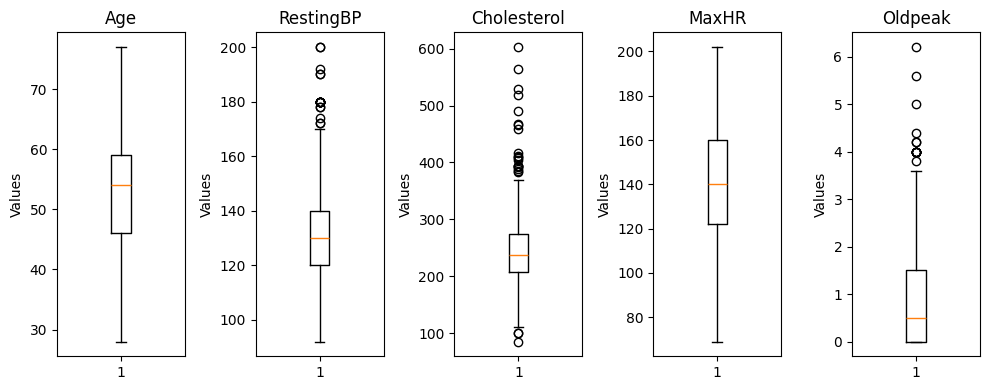

In [13]:
#creting a subplot of boxplots to see any further outliers that might need to be managed
#creating separate y axis so that data is not hidden but keeping everything in the same plot
#documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
#documentation: https://realpython.com/python-zip-function/

fig, axes = plt.subplots(nrows=1, ncols=df_heart_filtered_numerical_features.shape[1], figsize=(10, 4), sharey=False)

for ax, feature in zip(axes, df_heart_filtered_numerical_features.columns):
    ax.boxplot(df_heart_filtered_numerical_features[feature])
    ax.set_title(feature)
    ax.set_ylabel('Values')

plt.tight_layout()
plt.show()

#no outliers look to be needing managing
#while generally outliers are bad for models the ones below are needed for the context of healthcare
#these outliers are likely associated with the risk of heart disease
#outliers can affect the model by largely impacting our loss functions for eg RMSE by increasing the error (likley because they overfit)
#documentation for outliers: https://scialert.net/fulltext/?doi=jas.2005.1394.1398
#to keep the outliers in the data but also have them not affect our model we will use robust scaling which will scale around the median
#documentation for scaling: https://arxiv.org/pdf/2212.12343.pdf - page 8
#we could scale variables differently and see how this may affect the model but we will avoid this for now

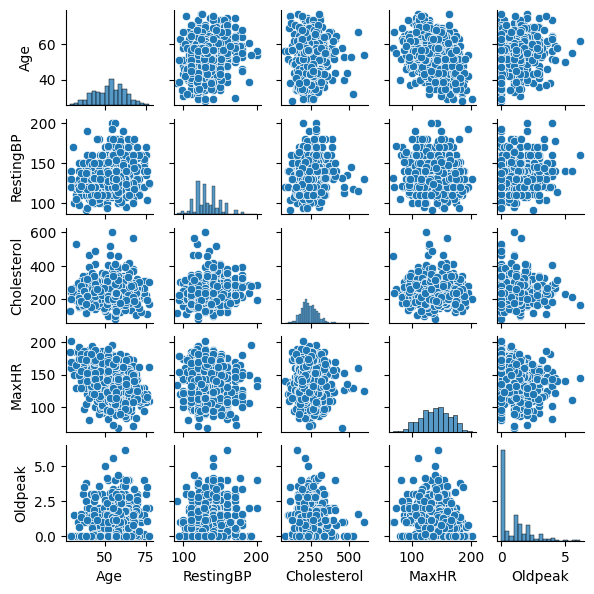

In [14]:
pairplot = sns.pairplot(df_heart_filtered_numerical_features, height=1.2, aspect=1)
plt.show()

#most data is not skewed except for the OldPeak data which is right skewed
#relationships between the numerical variables also are not very apparent which will be good for the model
#likely there is little correlation between variables

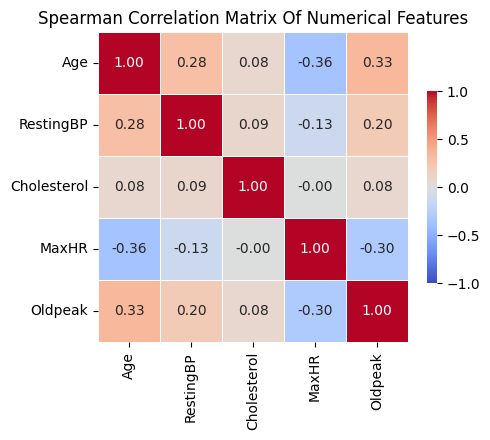

In [15]:
#calculating the correlation of all the numerical variables to judge the relationship strength
#high correlation can make it difficult to interpest feature importance and can make the model sensitive to changes
#documentation for correlation: https://www.scirp.org/journal/paperinformation?paperid=125846
#using spearman correlation as while some of the data is normall distrubted not all of it is else we would have used pearson
#documentation for when to use what correlation: %https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx
#documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

spearman_correlation = df_heart_filtered_numerical_features.corr(method='spearman')

plt.figure(figsize=(5, 5))

sns.heatmap(spearman_correlation, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1, vmin=-1, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5})

plt.title('Spearman Correlation Matrix Of Numerical Features')
plt.show()

#as expected, there is little correlation amongst numerical features which is good for our exercise

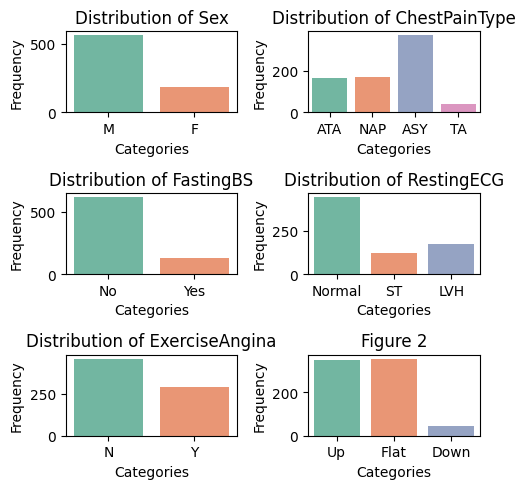

In [130]:
#checking the distribution of the categorical variables

rows = 3
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5, 5))

axes = axes.flatten() #was having trouble with the plot - i am making a 2 dimensional array - need to flatten else would require more looping
#documentation: https://stackoverflow.com/questions/64847274/subplots-not-plotting-correctly-matplotlib

for ax, category in zip(axes, df_heart_filtered_categorical_features.columns):
    ax = sns.countplot(x=category, data=df_heart_filtered_categorical_features,
                       palette='Set2', 
                       ax=ax)
    ax.set_title(f'Distribution of {category}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Frequency')

#plt.title('Figure 2')
plt.tight_layout()
plt.show()

#some categories are underrepresented which might bias the model towards the more represented class ie making it predict better for that class
#we could use resampling with SMOTE but we will avoid creating false data for this project
#we will try to get the model to preform well with the distribution as is and use cross validation and parameter tuning to improve results

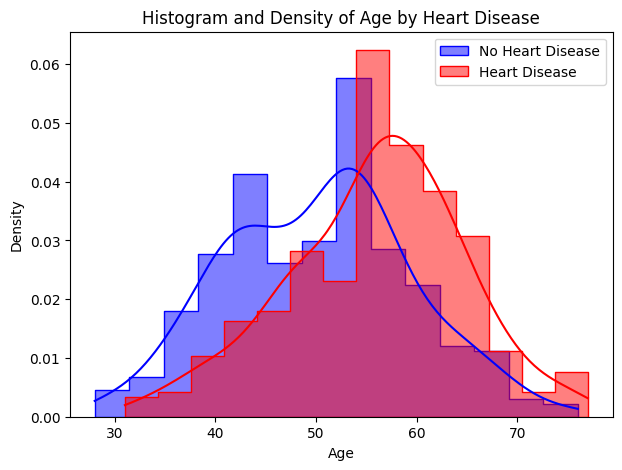

In [17]:
#creating a histogram to see how age is distributed if you have or do not have heart disease
#documentation for histplot = https://seaborn.pydata.org/generated/seaborn.histplot.html

plt.figure(figsize=(7,5))

sns.histplot(df_heart_filtered[df_heart_filtered['HeartDisease'] == 0]['Age'], color='blue',
             label='No Heart Disease', kde=True, element='step', stat='density')

sns.histplot(df_heart_filtered[df_heart_filtered['HeartDisease'] == 1]['Age'], color='red',
             label='Heart Disease', kde=True, element='step', stat='density')

plt.title('Histogram and Density of Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()

plt.show()

#data for those with heart disease seems a little more normally distributed than those with not

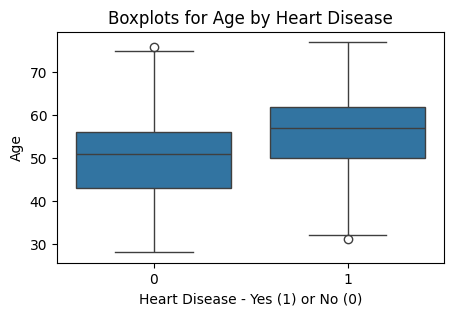

In [18]:
#creating a box plot to see if there are any measure differences of age by heart disease
#trying out sns boxplot
#documentation for boxplot: https://seaborn.pydata.org/generated/seaborn.boxplot.html

plt.figure(figsize=(5,3))

sns.boxplot(x='HeartDisease', y='Age', data=df_heart_filtered)
plt.title('Boxplots for Age by Heart Disease')
plt.xlabel('Heart Disease - Yes (1) or No (0)')
plt.ylabel('Age')
plt.show()

#there are little to no outliers
#the median age for heart disease is much higher if you have it versus when not
#with the percentiles also being higher for having heart disease it indicates that the older you are the more susceptible

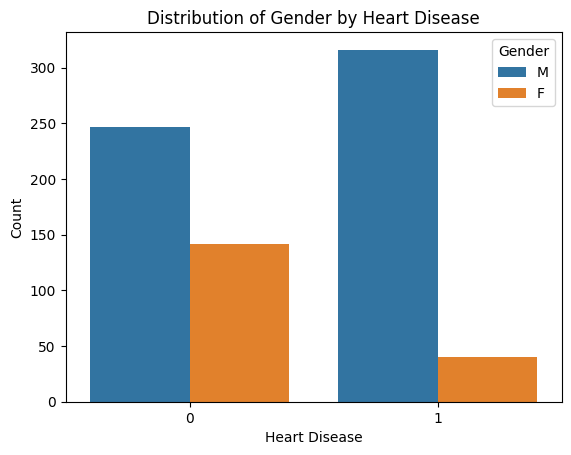

In [19]:
#looking at a bar chart to see if gender and heart disease have some kind of pattern

sns.countplot(x='HeartDisease', hue='Sex', data=df_heart_filtered)
plt.title('Distribution of Gender by Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

#ratio wise, males seem more susceptible to heart disease than females

## Final Pre-Processing

Making the final transformations to the data which involves:
1. Creating the dummy variables of categorical data - the order of the variables do not matter so safe to turn them into dummies
2. Making the initial train and test split so testing data is completely unseen
3. We will scale the training data
4. Save the scaling parameters to be later used on the test data to scale with the same parameters (this will avoid data bleed)

Documentation for train and test data leak: https://arxiv.org/pdf/2108.02497.pdf - page 5

While the first split will save us from data bleed the proceeding splits for training and testing will have some bleed
I could not find references to support this but we will accept this leakage during the training process for simplicity

In [20]:
#creating the dummy dataframe

df_heart_filtered_dummy_features = pd.get_dummies(df_heart_filtered_features,
                                                                          columns=['Sex', 'ChestPainType',
                                                                                   'FastingBS', 'RestingECG',
                                                                                   'ExerciseAngina', 'ST_Slope'],
                                                                          drop_first=True,
                                                                          prefix=['Sex', 'ChestPainType',
                                                                                   'FastingBS', 'RestingECG',
                                                                                   'ExerciseAngina', 'ST_Slope'],
                                                                          prefix_sep='_')

#added this line as get dummies was returning true and false. Converting to int directly treats true as 1 and false as 0
#documentation: https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
df_heart_filtered_dummy_features = df_heart_filtered_dummy_features.astype(int)
#df_heart_filtered_dummy_features

#combining the features and the target before splitting into train and test and then scaling
#splitting early on is easier to do i feel because saves the hassle of moving the target to the front or back
#although one could have just used iloc to split it up again. either way what i wanted has been accomplished
df_heart_filtered_dummy_features_target_combined = df_heart_filtered_dummy_features.join(df_heart_filtered_target, how='left')
df_heart_filtered_dummy_features_target_combined['HeartDisease'] = df_heart_filtered_dummy_features_target_combined['HeartDisease'].astype('float32')

df_heart_filtered_dummy_features_target_combined

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  Sex_M  ChestPainType_ATA  \
0     40        140          289    172        0      1                  1   
1     49        160          180    156        1      0                  0   
2     37        130          283     98        0      1                  1   
3     48        138          214    108        1      0                  0   
4     54        150          195    122        0      1                  0   
..   ...        ...          ...    ...      ...    ...                ...   
913   45        110          264    132        1      1                  0   
914   68        144          193    141        3      1                  0   
915   57        130          131    115        1      1                  0   
916   57        130          236    174        0      0                  1   
917   38        138          175    173        0      1                  0   

     ChestPainType_NAP  ChestPainType_TA  FastingBS_Yes  RestingECG_Normal  \
0                    0                 0              0                  1   
1                    1                 0              0                  1   
2                    0                 0              0                  0   
3                    0                 0              0                  1   
4                    1                 0              0                  1   
..                 ...               ...            ...                ...   
913                  0                 1              0                  1   
914                  0                 0              1                  1   
915                  0                 0              0                  1   
916                  0                 0              0                  0   
917                  1                 0              0                  1   

     RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease  
0                0                 0              0            1           0.0  
1                0                 0              1            0           1.0  
2                1                 0              0            1           0.0  
3                0                 1              1            0           1.0  
4                0                 0              0            1           0.0  
..             ...               ...            ...          ...           ...  
913              0                 0              1            0           1.0  
914              0                 0              1            0           1.0  
915              0                 1              1            0           1.0  
916              0                 0              1            0           1.0  
917              0                 0              0            1           0.0  

[745 rows x 16 columns]

In [21]:
#making the first split of our data
#here we will separate out the test data which will be completely unseen during the training process
#we will keep 15% of the data completely unseen during the training process
#documentation: https://stackoverflow.com/questions/61028460/how-to-use-stratify-for-single-column

train_data, test_data = train_test_split(df_heart_filtered_dummy_features_target_combined, 
                                         test_size=0.15, random_state=21,
                                         stratify=df_heart_filtered_dummy_features_target_combined['HeartDisease'])

#test_data #112 observations
train_data #633 observations

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  Sex_M  ChestPainType_ATA  \
854   52        120          325    172        0      1                  1   
779   43        110          211    161        0      1                  0   
184   54        160          312    130        0      0                  1   
544   61        140          298    120        0      0                  1   
12    39        120          204    145        0      1                  1   
..   ...        ...          ...    ...      ...    ...                ...   
732   56        200          288    133        4      0                  0   
267   34         98          220    150        0      1                  1   
252   61        125          292    115        0      1                  0   
761   52        112          230    160        0      1                  0   
46    37        120          223    168        0      1                  0   

     ChestPainType_NAP  ChestPainType_TA  FastingBS_Yes  RestingECG_Normal  \
854                  0                 0              0                  1   
779                  0                 0              0                  1   
184                  0                 0              0                  1   
544                  0                 0              1                  1   
12                   0                 0              0                  1   
..                 ...               ...            ...                ...   
732                  0                 0              1                  0   
267                  0                 0              0                  1   
252                  0                 0              0                  0   
761                  0                 0              0                  1   
46                   0                 0              0                  1   

     RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease  
854              0                 0              0            1           0.0  
779              0                 0              0            1           0.0  
184              0                 0              0            1           0.0  
544              0                 1              0            1           0.0  
12               0                 0              0            1           0.0  
..             ...               ...            ...          ...           ...  
732              0                 1              0            0           1.0  
267              0                 0              0            1           0.0  
252              1                 1              0            1           0.0  
761              0                 0              0            1           1.0  
46               0                 0              0            1           0.0  

[633 rows x 16 columns]

In [22]:
#saving our test data as final testing data to be used later

final_test_data = test_data.copy()
final_test_data_path = 'final_test_data.csv'
final_test_data.to_csv(final_test_data_path, index=False)

In [23]:
#we are now going to scale our data
#we are going to use robust scaling as decided before
#technically we do not need to scale data already transformed to 0 and 1 since the range here is already capped and it is binary
#our data includes binary features between 0 and 1 and also continuous features
#we know we will likely use a graident descent algorithm to minimise our chosen loss function
#we also know that GD can be sensitive to different scales (given its math) - convergence speed and difficulty finding accurate learning rates
#therefore, even though not required, we will scale all our features using robust scaling
#this will hamper our ability to interpret the meaning of the variables however, since we are not trying to explain feature importance we accept this
#documentation for GD sensitivity: https://www.mdpi.com/2227-7390/11/3/682
#maybe in the future we can also look at how different scaling can affect the networks

scaling_features = train_data.iloc[:, :-1] #selecting everything but the target variable
#scaling_features

scaler = RobustScaler()
scaled_features = scaler.fit_transform(scaling_features)
scaled_features = pd.DataFrame(scaled_features, columns=scaling_features.columns)
scaled_features

#note that robust scaling can introduce negative values since you are subtracting the median
#this is not usually a problem for activation functions but depends on the network structure, chosen functions and data
#see documentation: https://stats.stackexchange.com/questions/557994/can-a-neural-network-work-with-negative-and-zero-inputs
#documentation of activation functions: https://www.researchgate.net/publication/344757203_Review_and_Comparison_of_Commonly_Used_Activation_Functions_for_Deep_Neural_Networks
#documentation of activation functions: https://ijeast.com/papers/310-316,Tesma412,IJEAST.pdf

Age  RestingBP  Cholesterol     MaxHR  Oldpeak  Sex_M  \
0   -0.153846      -0.50     1.246377  0.842105      0.0    0.0   
1   -0.846154      -1.00    -0.405797  0.552632      0.0    0.0   
2    0.000000       1.50     1.057971 -0.263158      0.0   -1.0   
3    0.538462       0.50     0.855072 -0.526316      0.0   -1.0   
4   -1.153846      -0.50    -0.507246  0.131579      0.0    0.0   
..        ...        ...          ...       ...      ...    ...   
628  0.153846       3.50     0.710145 -0.184211      4.0   -1.0   
629 -1.538462      -1.60    -0.275362  0.263158      0.0    0.0   
630  0.538462      -0.25     0.768116 -0.657895      0.0    0.0   
631 -0.153846      -0.90    -0.130435  0.526316      0.0    0.0   
632 -1.307692      -0.50    -0.231884  0.736842      0.0    0.0   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_Yes  \
0                  1.0                0.0               0.0            0.0   
1                  0.0                0.0               0.0            0.0   
2                  1.0                0.0               0.0            0.0   
3                  1.0                0.0               0.0            1.0   
4                  1.0                0.0               0.0            0.0   
..                 ...                ...               ...            ...   
628                0.0                0.0               0.0            1.0   
629                1.0                0.0               0.0            0.0   
630                0.0                0.0               0.0            0.0   
631                0.0                0.0               0.0            0.0   
632                0.0                0.0               0.0            0.0   

     RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0                  0.0            0.0               0.0            0.0   
1                  0.0            0.0               0.0            0.0   
2                  0.0            0.0               0.0            0.0   
3                  0.0            0.0               1.0            0.0   
4                  0.0            0.0               0.0            0.0   
..                 ...            ...               ...            ...   
628               -1.0            0.0               1.0            0.0   
629                0.0            0.0               0.0            0.0   
630               -1.0            1.0               1.0            0.0   
631                0.0            0.0               0.0            0.0   
632                0.0            0.0               0.0            0.0   

     ST_Slope_Up  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
..           ...  
628          0.0  
629          1.0  
630          1.0  
631          1.0  
632          1.0  

[633 rows x 15 columns]

In [24]:
#saving our scaled parameters from the training data to use on final test data for the best models selected
#documentation: https://stackoverflow.com/questions/35944783/how-to-store-scaling-parameters-for-later-use

joblib.dump(scaler, 'robust_scaled_train_data_parameters.joblib')
scaler_loaded = joblib.load('robust_scaled_train_data_parameters.joblib') #loading the data to be used later on

In [25]:
#creating the train and test splits that are to be used in the models
#we are doing stratified cross validation on all the models to ensure same distribution of classes
#we are using the same number of folds across all model
#adding a random state for reproducability

#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
#documentation cross validation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10217387/
#documentation: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html

#keep in mind, we have already split the data once in cell 21 - that holds the completely unseen data which we will use once all models are fit

X = scaled_features #there are 15 features
y = train_data.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=21, stratify=y)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

skf = StratifiedKFold(n_splits=5, random_state=2024, shuffle=True)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

#dataset is quite small no need to do any batching
#had trouble implementing the cross validation
#i first tried to make separate folds and then convert the separate folds into tensors
#i was able to do this but when i passed the data into the net only the first fold was being used
#then i discovered the cross validate function in sklearn and the process became much simpler

## The Models

Structure of the following code/what to expect.

There are a total of 4 sections in the following order: Base MLP, Tuned MLP, Base SVM and Tuned SVM

The Tuned sections have 2 subsections in the order Tuning.. and Final Tuned..

In the Base sections you will see the following structure: creating the model > cross validated train predictions > fitting > test predictions > results (classification report > confusion matrix > AUC scores > ROC curves)

Within the Tuned sections the Final Tuned.. have the same structure as Base. However, the Tuning.. sections have an additional step of gridsearch

The random seeds have been set in each section for reproducability

For all results you will see train and test scores. Please remember that this is just the training notebook overall. The data has been split twice. The first split created a completely unseen test data which will be used in the test notebook. All proceeding sections in this note book will purely be using the training data from the first split. That training data gets further split into training and testing (or validation) which is what you see here.



### Base MLP

In [26]:
#much of the codes structure is learnt from what was taught in the labs
#the code you will see below will have adapted what we have done in the labs and specific use case searches online
#the first 4 labs for NN have been used as a reference point 
#the following link has been used a reference point: https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/
#research when to create a class and not: https://stackoverflow.com/questions/23831504/python-when-to-create-a-class-and-when-to-create-a-function
#classes are generally made to organise groups of functions and instances

In [27]:
#using basic initial parameters, randomly assigned unless accompanied by documentation or stated

mlp_base_input_size = 15  #should always be the number of features in your dataset
mlp_base_hidden_layer_size = 10  #size of the hidden layer
mlp_base_epochs = 50 #number of complete passes of training data through learning algorithm
mlp_base_learning_rate = 0.01 #the rate at which weights are adjusted while calculating gradient loss

mlp_base_criterion = torch.nn.BCELoss()
#mlp_base_criterion = torch.nn.BCEWithLogitsLoss()  #binary cross entropy loss
#documentation: https://arxiv.org/pdf/2301.05579.pdf
#documentation: https://proceedings.mlr.press/v202/mao23b/mao23b.pdf

mlp_base_optimizer = optim.Adam # Adam optimizer - good default and can help with convergence speed
#documentation: lab 3
#documentation: https://www.mdpi.com/2227-7390/11/11/2466

In [28]:
#creating the base model
#simple 1 hidden layer perceptron
#input is passed through a relu activation function
#output is passed through sigmoid
#documentation: https://ijeast.com/papers/310-316,Tesma412,IJEAST.pdf
#documentation: https://skorch.readthedocs.io/en/stable/classifier.html
#documentation: https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586

#i had some trouble here that on the surface was simple but required a better understanding of the documentation and techniques
#initially i tried using bce with logit loss which meant that i should not have a sigmoid layer in my net as the loss function directly applies it
#this worked great until i tried to calcualte the AUC
#i was not able to get the probabilities out from the net as they were directly being transformed
#i was also constantly running into data type errors despite having explicitly casted everything as float32
#i then switch the bce loss and added the sigmoid layer manually
#fitting the net and then applying predict proba worked to get the probabilites
#i am unsure if the change was the reason or i was just doing something wrong before but i did not question this further
#i also then found that within skorch callbacks we can have multiple metrics passed separately and i was able to get the auc
#once again i am not sure if this was because of my change - being concious of time i did not test out the opposite and moved on


class Base_Binary_Classifier_MLP(nn.Module):
    def __init__(self, mlp_base_input_size, mlp_base_hidden_layer_size):
        super(Base_Binary_Classifier_MLP, self).__init__()
        self.layer1 = nn.Linear(mlp_base_input_size, 
                                mlp_base_hidden_layer_size) #this is the input layer using 'inputs' | also the single hidden layer using ReLU
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(mlp_base_hidden_layer_size, 1) #this is the output layer that is then passed to the sigmoid to scale values to 0 or 1

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

In [29]:
#setting up the net using skorch
#unsure of a better way to write out the call backs but this worked for me and i did not question it
#documentation: https://skorch.readthedocs.io/en/stable/user/neuralnet.html
#documentation: https://skorch.readthedocs.io/en/stable/callbacks.html

#while we are early stopping on validation loss,  we care more about precision than another metric
#since we are predicting heart disease we care more about the precision (ie quality) rather than recall (ie quantity)
#this will be used to select the best parameters in later sections

torch.manual_seed(15)

base_mlp_net = NeuralNetClassifier(module=Base_Binary_Classifier_MLP,
                                   module__mlp_base_input_size=mlp_base_input_size, #had to add module__ - not sure why some instantiations are passed and some not
                                   module__mlp_base_hidden_layer_size=mlp_base_hidden_layer_size, #had to add module__ - not sure why some instantiations are passed and some not
                                   max_epochs = mlp_base_epochs, 
                                   optimizer = mlp_base_optimizer,
                                   criterion = mlp_base_criterion,
                                   lr = mlp_base_learning_rate,
                                   iterator_train__shuffle = True,
                                   callbacks=[EpochScoring(scoring='roc_auc', lower_is_better=False, on_train=True, name='train_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, on_train=True, name='train_precision'),
                                              #EpochScoring(scoring='recall', lower_is_better=False, on_train=True, name='train_recall'),
                                              EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True, name='train_acc'),
                                              #EpochScoring(scoring='f1', lower_is_better=False, on_train=True, name='train_f1'),
                                              EpochScoring(scoring='roc_auc', lower_is_better=False, name='valid_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, name='valid_precision'),
                                              #EpochScoring(scoring='recall', lower_is_better=False, name='valid_recall'),
                                              #EpochScoring(scoring='accuracy', lower_is_better=False, name='valid_acc'),
                                              #EpochScoring(scoring='f1', lower_is_better=False, name='valid_f1'),
                                              EarlyStopping(monitor='valid_loss',
                                                            patience=10, #epoch limit on validation loss if there is no improvement for said epochs
                                                            lower_is_better=True)
                                             ]
                                  )

Just saving this for other parameters i can use - found these by accident when i typed F1 rather than f1 and then realized i can pass more than accuracy in epoch scoring

InvalidParameterError: The 'scoring' parameter of cross_val_predict must be a str among {'roc_auc', 'neg_median_absolute_error', 'jaccard', 'jaccard_weighted', 'precision_macro', 'f1', 'recall_micro', 'fowlkes_mallows_score', 'jaccard_macro', 'positive_likelihood_ratio', 'matthews_corrcoef', 'precision_samples', 'top_k_accuracy', 'average_precision', 'f1_weighted', 'max_error', 'roc_auc_ovr_weighted', 'recall_samples', 'roc_auc_ovo', 'adjusted_rand_score', 'neg_mean_gamma_deviance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'normalized_mutual_info_score', 'completeness_score', 'f1_macro', 'recall_macro', 'neg_mean_absolute_percentage_error', 'neg_brier_score', 'accuracy', 'jaccard_micro', 'balanced_accuracy', 'roc_auc_ovr', 'neg_root_mean_squared_log_error', 'neg_negative_likelihood_ratio', 'homogeneity_score', 'mutual_info_score', 'recall', 'explained_variance', 'f1_samples', 'precision_weighted', 'rand_score', 'neg_mean_squared_log_error', 'roc_auc_ovo_weighted', 'neg_mean_poisson_deviance', 'recall_weighted', 'r2', 'precision', 'f1_micro', 'neg_log_loss', 'neg_root_mean_squared_error', 'precision_micro', 'v_measure_score', 'adjusted_mutual_info_score', 'jaccard_samples'}, a callable or None. Got 'F1' instead.

In [30]:
#running the model to see training and test scores
#i used both cross_validate and cross_val_predit
#i ended up getting very different train and validation scores ie cross validate score <> cross val predict
#this is because of the way the functions are set up by the makers (see documentation below)
#having the shuffle on might help ensure even distribution or generalizability
#i have not found sources for this, this is just my intuition
#since we are using classification report which needs cross val predict i am just using that going forward and keeping this commented out
#documentation: https://stackoverflow.com/questions/62201597/scikit-learn-scores-are-different-when-using-cross-val-predict-vs-cross-val-scor

#cross_validate_base_mlp = cross_validate(base_mlp_net, X_train_tensor, y_train_tensor, cv=skf)

In [31]:
#generating predictions for the confusion matrix
#cross val predict stores the predictions to be used in the classification report

train_predictions_base_mlp = cross_val_predict(base_mlp_net, X_train_np, y_train_np, cv=skf)

#train_predictions_base_mlp = base_mlp_net.predict(X_train_np)

#the model is very quick to train across all epochs and folds
#stopping criteria was set at 10 but observing the values i feel we can save compute (decrease stopping criteria) with little effect on classification
#we will save this for when we are tuning the model in the next session
#overall the results are already very strong on the train and validation sets

  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.6337        0.6735             0.5969           0.7298       0.7674        0.6427             0.7143           0.8694  0.0123
      2       0.7849        0.6396             0.7368           0.8636       0.8256        0.6017             0.8095           0.8997  0.0100
      3       0.8314        0.6018             0.8046           0.8837       0.8721        0.5551             0.8750           0.9154  0.0092
      4       0.8372        0.5592             0.8068           0.8928       0.8837        0.5058             0.8780           0.9225  0.0100
      5       0.8343        0.5147             0.7989           0.9002       0.8837        0.4580             0.8780           0.9252  0.0106
      

In [32]:
#fitting the net onto the data to be trained

base_mlp_net.fit(X_train_np, y_train_np)

#the speed is very quick given the size of data and compute power of the laptop

  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.5349        0.6844             0.6923           0.6110       0.6389        0.6512             0.8095           0.8705  0.0120
      2       0.7512        0.6352             0.8712           0.8709       0.8704        0.6031             0.8800           0.9159  0.0120
      3       0.8093        0.5899             0.8220           0.8980       0.8796        0.5454             0.8545           0.9272  0.0120
      4       0.8372        0.5359             0.8169           0.9055       0.8889        0.4819             0.8704           0.9313  0.0105
      5       0.8349        0.4791             0.8131           0.9105       0.8889        0.4210             0.8704           0.9354  0.0115
      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Base_Binary_Classifier_MLP(
    (layer1): Linear(in_features=15, out_features=10, bias=True)
    (relu): ReLU()
    (layer2): Linear(in_features=10, out_features=1, bias=True)
  ),
)

In [33]:
#creating an overall classification report of the training predictions
#the report will provide a more succint report of the training done in the previous cell

train_classification_report_base_mlp = classification_report(y_train_np, train_predictions_base_mlp)

In [34]:
#creating the test predictions for classification report

test_predictions_base_mlp = base_mlp_net.predict(X_test_np)

In [35]:
#test classification report

test_classification_report_base_mlp = classification_report(y_test_np, test_predictions_base_mlp)

In [36]:
print('Training Classification Report Base MLP:')
print(train_classification_report_base_mlp)
print('--------------------')
print('Test Classification Report Base MLP:')
print(test_classification_report_base_mlp)

#within our training environment the model seems to generalize well
#to be seen if this continues on our final testing data
#will work to improve precision when tuning
#overall the model preforms well predicting both classes
#the lack of imbalance probably helps this
#since we are predicting heart disease we care more about the precision (ie quality) rather than recall (ie quantity)
#we have clear room for improvement here - lets aim to break into the 90s

Training Classification Report Base MLP:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       281
         1.0       0.82      0.85      0.84       257

    accuracy                           0.84       538
   macro avg       0.84      0.84      0.84       538
weighted avg       0.84      0.84      0.84       538

--------------------
Test Classification Report Base MLP:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84        50
         1.0       0.81      0.84      0.83        45

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [37]:
#creating confusion matrix to visualize the classifications

train_confusion_matrix_base_mlp = confusion_matrix(y_train_np, train_predictions_base_mlp)
test_confusion_matrix_base_mlp = confusion_matrix(y_test_np, test_predictions_base_mlp)

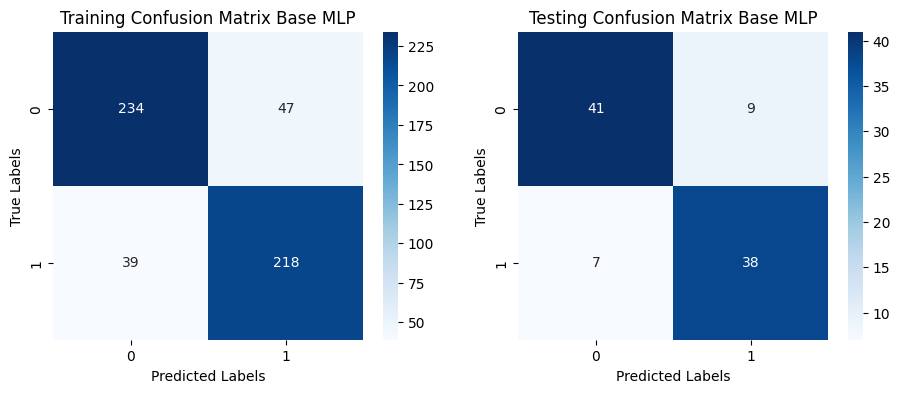

In [38]:
#creating the plots
#documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
#documentation: https://seaborn.pydata.org/tutorial/color_palettes.html

plt.figure(figsize=(11, 4))

#training matrix
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix_base_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Training Confusion Matrix Base MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#testing matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix_base_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Testing Confusion Matrix Base MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('confusion_matrix_base_mlp.png')

plt.show()

In [39]:
#the classification report does not give us the overall model AUC so calcualting it here by getting the probabilites
#doing some array transformations to get things in the right shape to use the function
#documentation: https://medium.com/@mohsin.shaikh324/numpy-ravel-v-s-numpy-flatten-v-s-numpy-squeeze-25d215a5ccbd

test_probabilities_base_mlp_net = base_mlp_net.predict_proba(X_test_np)
#probabilities_base_mlp_net
#probabilities_base_mlp_net.shape
#y_test_np.shape
test_probabilities_base_mlp_net = np.squeeze(test_probabilities_base_mlp_net)
#probabilities_base_mlp_net.shape
test_probabilities_base_mlp_net = test_probabilities_base_mlp_net[:, 1]
#probabilities_base_mlp_net.shape
y_test_np_ravel = y_test_np.ravel()
#y_test_np_ravel.shape

In [40]:
#creating the train probabilities for AUC

train_probabilities_base_mlp_net = base_mlp_net.predict_proba(X_train_np)
train_probabilities_base_mlp_net = np.squeeze(train_probabilities_base_mlp_net)
train_probabilities_base_mlp_net = train_probabilities_base_mlp_net[:, 1]
y_train_np_ravel = y_train_np.ravel()

In [41]:
train_auc_base_mlp_net = roc_auc_score(y_train_np_ravel, train_probabilities_base_mlp_net)
test_auc_base_mlp_net = roc_auc_score(y_test_np_ravel, test_probabilities_base_mlp_net)

print(f"Train AUC Score for Base MLP: {train_auc_base_mlp_net:.2f}")
print(f"Test AUC Score for Base MLP: {test_auc_base_mlp_net:.2f}")

#the auc is a much stronger measure as it measure correct predictions across different thresholds
#the auc is already quite strong - much better than random guessing which should have seen a score of approximately 50
#we will aim to improve the auc during tuning and see if it improves on the final test set

Train AUC Score for Base MLP: 0.94
Test AUC Score for Base MLP: 0.91


In [42]:
#calculating ROC to plot the curves for train and test
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

train_fpr_base_mlp, train_tpr_base_mlp, _ = roc_curve(y_train_np_ravel, train_probabilities_base_mlp_net)
train_auc_base_mlp = auc(train_fpr_base_mlp, train_tpr_base_mlp)

test_fpr_base_mlp, test_tpr_base_mlp, _ = roc_curve(y_test_np_ravel, test_probabilities_base_mlp_net)
test_auc_base_mlp = auc(test_fpr_base_mlp, test_tpr_base_mlp)

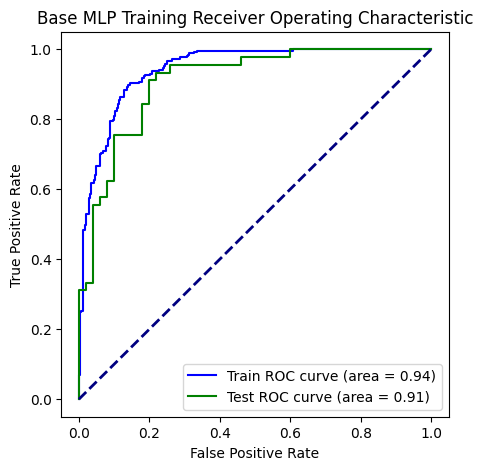

In [43]:
#plotting the roc curve
#documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

plt.figure(figsize=(5, 5))
plt.plot(train_fpr_base_mlp, train_tpr_base_mlp, color='blue', lw=1.5, label=f'Train ROC curve (area = {train_auc_base_mlp:.2f})')
plt.plot(test_fpr_base_mlp, test_tpr_base_mlp, color='green', lw=1.5, label=f'Test ROC curve (area = {test_auc_base_mlp:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base MLP Training Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_base_mlp.png')

plt.show()

In [44]:
#saving the fitted base model to be used later

joblib.dump(base_mlp_net, 'base_mlp_net.pkl')
base_mlp_net = joblib.load('base_mlp_net.pkl')

###  Tuned MLP

#### Tuning the MLP

In [45]:
#documentation for parameters used

#1 paper concludes that a MLP with 1 hidden layer but "ample" size is better than multiple layers
#we will test with multiple layers and multiple sizes
#documentation: https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-5546-z

#we will also test learning rate
#documentation: https://www.semanticscholar.org/reader/9f2fb6899e046e1f42792ba6f22b0877149062eb

#we will also test differenct combinations of activation functions
#for simplicity the same function will be used throughout the network rather than different combinations within the network
#choice of functions can impact model
#since we are using binary cross entropy the final layer will have a sigmoid to transform the targets between 0 and 1
#the layers before it will have different activation functions which will include relu and tanh
#others could have also been used but only chosen 2 for simplicity
#documentation: https://www.mdpi.com/2076-3417/12/11/5713

#we will also test multiple epochs

#our stopping criteria will be epochs and/or achieving a minimum or maximum precision

#we will also use drop out
#documentation: https://www.sciencedirect.com/science/article/pii/S0012825219305549

In [46]:
#documentation for Adam: https://arxiv.org/pdf/1412.6980.pdf
#setting up the base grid to avoid problems in the class and function
#these will be over ridden where required during the grid search

mlp_tuned_input_size = 15 #always 15 as it is the number of features
mlp_tuned_hidden_layers = 1 
mlp_tuned_hidden_layer_size = 10  
mlp_tuned_output_size = 1 #always 1 as we are doing binary classification
mlp_tuned_dropout_rate = 0.0 
mlp_tuned_activation_function = nn.ReLU  
mlp_tuned_epochs = 50
mlp_tuned_learning_rate = 0.1
#mlp_tuned_momentum = 0.0 #not using momentum as Adam optim implictily use weight decay concepts 
mlp_tuned_optimizer = optim.Adam
mlp_tuned_criterion = nn.BCELoss() 

In [47]:
#also creating a parameter grid to be part of the grid search
#starting with an initial value as in the base mlp

#fitting the grid with all the below paramters was taking over an hour to train
#to combat this i have removed the max epoch and left it at a default value
#after removing the grid search took about 10 minutes
#after removing the following was the output
#Best parameters found:  {'lr': 0.01, 'module__mlp_tuned_activation_function': <class 'torch.nn.modules.activation.Tanh'>, 
# 'module__mlp_tuned_dropout_rate': 0.1, 'module__mlp_tuned_hidden_layer_size': 40, 'module__mlp_tuned_hidden_layers': 1}
#this then made me add a higher learning rate and one more hidden layer size to see if the model might prefer a higher number of these
#this search then took about 13 minutes
#the following was the output of best params
#Best parameters found:  {'lr': 0.0001, 'module__mlp_tuned_activation_function': <class 'torch.nn.modules.activation.ReLU'>,
# 'module__mlp_tuned_dropout_rate': 0.1, 'module__mlp_tuned_hidden_layer_size': 40, 'module__mlp_tuned_hidden_layers': 1}
#none of the changes made much difference to what the module prefered
#what changed was the preference of activation function and a smaller learning rate

#random search could also have been used and we could have potentially increased the number of parameters to search through
#but kept it small on purpose


parameter_grid = {
    'module__mlp_tuned_hidden_layers': [1, 2, 4],  # Number of hidden layers
    'module__mlp_tuned_hidden_layer_size': [10, 20, 40, 60],  # Number of neurons in each hidden layer
    'module__mlp_tuned_dropout_rate': [0.0, 0.1, 0.2],  # Dropout rates
    'module__mlp_tuned_activation_function': [nn.ReLU, nn.Tanh],  # Different activation functions
    'lr': [0.1, 0.01, 0.001, 0.0001]  # Learning rates
    #'max_epochs': [50, 100, 200]  # Number of epochs
    #'optimizer__momentum': [0.0, 0.2, 0.4]
}

In [48]:
#creating the binary classifier class that is being built with a dynamic structure to vary the number of hidden layers
#while we are looking at the base mlp classifier here ie simple initial inputs
#we are building it dynamically to be reusable when we come to finding a more complicated structure using cross val and grid search

#documentation: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
#documentation: https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463
#documentation: https://stackoverflow.com/questions/62937388/pytorch-dynamic-amount-of-layers
#documentation: https://skorch.readthedocs.io/en/stable/user/neuralnet.html#using-neuralnet
#documentation: https://discuss.pytorch.org/t/how-to-use-nn-modulelist-correctly/39557


class Tuned_Binary_Classifier_MLP(nn.Module):
    def __init__(self, mlp_tuned_input_size, mlp_tuned_hidden_layers, mlp_tuned_hidden_layer_size,
                 mlp_tuned_output_size, mlp_tuned_dropout_rate, mlp_tuned_activation_function):
        super(Tuned_Binary_Classifier_MLP, self).__init__()
        self.layers = nn.ModuleList()
        #nn Module allows to manage multiple layers with flexibility and compatible with pytorch features
        #can not use a simple list as pytorch capabilities will not be available

        #we are creating the first layer that will always be the same 
        #inputs going into the first hidden layer with a function
        #the base model will alawys at least have 1 hidden layer
        #.append allows you to add layers without hvaing to manually add to test different structures
        #this took a bit to debug and figure hence the large documentation list
        self.layers.append(nn.Linear(mlp_tuned_input_size, mlp_tuned_hidden_layer_size))
        self.layers.append(mlp_tuned_activation_function())
        self.layers.append(nn.Dropout(mlp_tuned_dropout_rate))
        
        #dynamically adding additional layers using .append described above
        #using a simple for loop to loop through the number of sepcified hidden layers
        #this simple loop works because we are keeping the structure of the network the same
        #which is to say that the activation functions are not being combined differently when chosen
        #we will see later on how this is adpated to loop through different sizes of the hidden layer
        for _ in range(1, mlp_tuned_hidden_layers):
            self.layers.append(nn.Linear(mlp_tuned_hidden_layer_size, mlp_tuned_hidden_layer_size))
            self.layers.append(mlp_tuned_activation_function())
            self.layers.append(nn.Dropout(mlp_tuned_dropout_rate))
        
        # Add the output layer
        self.layers.append(nn.Linear(mlp_tuned_hidden_layer_size, mlp_tuned_output_size))
        self.layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [49]:
torch.manual_seed(15)

tuned_mlp_net = NeuralNetClassifier(module=Tuned_Binary_Classifier_MLP,
                                   module__mlp_tuned_input_size=mlp_tuned_input_size,
                                   module__mlp_tuned_hidden_layers=mlp_tuned_hidden_layers,
                                   module__mlp_tuned_hidden_layer_size=mlp_tuned_hidden_layer_size,
                                   module__mlp_tuned_output_size=mlp_tuned_output_size,
                                   module__mlp_tuned_dropout_rate=mlp_tuned_dropout_rate,
                                   module__mlp_tuned_activation_function=mlp_tuned_activation_function,
                                   max_epochs = mlp_tuned_epochs, 
                                   optimizer = mlp_tuned_optimizer,
                                   criterion = mlp_tuned_criterion,
                                   lr = mlp_tuned_learning_rate,
                                   iterator_train__shuffle = True,
                                   callbacks=[EpochScoring(scoring='roc_auc', lower_is_better=False, on_train=True, name='train_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, on_train=True, name='train_precision'),
                                              EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True, name='train_acc'),
                                              EpochScoring(scoring='roc_auc', lower_is_better=False, name='valid_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, name='valid_precision'),
                                              EarlyStopping(monitor='valid_loss',
                                                            patience=10,
                                                            lower_is_better=True)
                                             ]
                                  )

In [50]:
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

tuned_mlp_grid = GridSearchCV(tuned_mlp_net, parameter_grid, scoring='precision', refit=True, cv=skf)

In [51]:
tuned_mlp_grid.fit(X_train_np, y_train_np)

  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.6802        0.6124             0.6274           0.7797       0.8837        0.3894             0.8974           0.9230  0.0098
      2       0.8314        0.4014             0.8313           0.9041       0.9070        0.3217             0.9459           0.9317  0.0111
      3       0.8488        0.3739             0.8636           0.9256       0.8721        0.3114             0.8750           0.9485  0.0118
      4       0.8634        0.3375             0.8774           0.9390       0.8953        0.2973             0.8810           0.9431  0.0070
      5       0.8634        0.3194             0.8634           0.9388       0.8605        0.3106             0.8085           0.9458  0.0080
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.9099        0.2432             0.8674           0.9596       0.8605        0.3256             0.8125           0.9334  0.0098
     12       0.9186        0.2270             0.8820           0.9637       0.8605        0.3507             0.8000           0.9345  0.0093
     13       0.9244        0.2221             0.8791           0.9659       0.8488        0.3517             0.7843           0.9318  0.0085
     14       0.9244        0.2064             0.8833           0.9697       0.8372        0.3435             0.7800           0.9299  0.0090
     15       0.9186        0.2083             0.8908           0.9702       0.8256        0.3638             0.7647           0.9253  0.0111
     16       0.9360        0.1998             0.8944           0.9713       0.8256        0.3901             0.7547           0.9272  0.0114
     17       0.9360        0.1917             0.8944           0.9737       0.8605        0.3493             0.7885           0.9234  0.0124
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.9070        0.2326             0.8667           0.9643       0.8161        0.4938             0.7955           0.9212  0.0110
     11       0.9128        0.2287             0.8807           0.9654       0.8391        0.4808             0.8043           0.9233  0.0116
     12       0.9186        0.2215             0.8736           0.9685       0.8276        0.5657             0.8140           0.9238  0.0125
     13       0.9128        0.2162             0.8807           0.9694       0.8391        0.6392             0.8182           0.9267  0.0112
     14       0.9273        0.1931             0.8927           0.9737       0.8506        0.5324             0.8222           0.9254  0.0111
     15       0.9070        0.2035             0.8548           0.9762       0.8506        0.5137             0.8222           0.9246  0.0104
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_ac

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      9       0.8779        0.3231             0.9013           0.9505       0.8391        0.3690             0.8684           0.9339  0.0161
     10       0.9012        0.2851             0.9012           0.9540       0.8851        0.4451             0.8478           0.9302  0.0134
     11       0.8837        0.2618             0.8370           0.9621       0.8851        0.4159             0.8810           0.9296  0.0156
     12       0.9070        0.2334             0.8750           0.9674       0.8736        0.4734             0.8974           0.9196  0.0148
     13       0.9041        0.2315             0.8830           0.9686       0.8621        0.5464             0.8750           0.9164  0.0121
     14       0.8983        0.2105             0.8644           0.9725       0.8621        0.6504             0.8409           0.9169  0.0140
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_ac

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8866        0.2776             0.8571           0.9534       0.8621        0.3492             0.8125           0.9132  0.0141
     11       0.8866        0.2588             0.8571           0.9583       0.8506        0.3861             0.8085           0.9167  0.0263
     12       0.8953        0.2496             0.8765           0.9610       0.8506        0.4406             0.8085           0.9138  0.0260
     13       0.8953        0.2426             0.8765           0.9647       0.8621        0.3865             0.8261           0.9249  0.0150
     14       0.9070        0.2277             0.8708           0.9692       0.8621        0.3941             0.8261           0.9278  0.0177
     15       0.9186        0.2224             0.9048           0.9701       0.8506        0.4140             0.8372           0.9259  0.0148
     16       0.9186        0.2069             0.9198           0.9751       0.8621        0.4688             0.8409           0.9143  0.0122
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.9273        0.1833             0.8798           0.9802       0.8372        0.3500             0.8140           0.9274  0.0100
     12       0.9448        0.1578             0.9394           0.9850       0.8837        0.4432             0.8444           0.9241  0.0115
     13       0.9244        0.1681             0.8920           0.9800       0.8721        0.4362             0.8409           0.9100  0.0110
     14       0.9651        0.1286             0.9471           0.9907       0.8372        0.4222             0.8000           0.9241  0.0116
     15       0.9622        0.1096             0.9415           0.9912       0.8372        0.5201             0.7872           0.9257  0.0111
     16       0.9709        0.0933             0.9477           0.9938       0.8488        0.5387             0.8043           0.8943  0.0115
     17       0.9709        0.0776             0.9529           0.9973       0.8488        0.6303             0.8043           0.8878  0.0100
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8779        0.2885             0.8506           0.9476       0.8837        0.2818             0.8298           0.9485  0.0391
     11       0.8866        0.2729             0.8453           0.9540       0.8953        0.2809             0.8478           0.9515  0.0166
     12       0.8924        0.2717             0.8470           0.9499       0.8953        0.2912             0.8478           0.9585  0.0198
     13       0.8779        0.2597             0.8144           0.9591       0.9070        0.2977             0.8667           0.9528  0.0146
     14       0.8895        0.2572             0.8500           0.9567       0.8953        0.2762             0.8636           0.9523  0.0162
     15       0.8983        0.2332             0.8413           0.9608       0.8953        0.2761             0.8478           0.9558  0.0156
     16       0.9128        0.2240             0.8602           0.9608       0.8837        0.2996             0.8444           0.9593  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.8779        0.3219             0.8020           0.9092       0.8372        0.3373             0.8000           0.8946  0.0150
     12       0.8721        0.3368             0.8297           0.8981       0.8372        0.3356             0.7872           0.9008  0.0140
     13       0.8866        0.2943             0.8173           0.9165       0.8488        0.3538             0.7800           0.9060  0.0112
     14       0.8895        0.2815             0.8150           0.9242       0.8488        0.3731             0.7917           0.9442  0.0267
     15       0.8866        0.2826             0.8492           0.9293       0.8372        0.3364             0.7872           0.9360  0.0242
     16       0.9070        0.2485             0.8548           0.9356       0.8372        0.3264             0.7755           0.9287  0.0223
     17       0.9244        0.2340             0.8710           0.9425       0.8488        0.3275             0.7917           0.9374  0.0200
Stoppi

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.9157        0.2626             0.9141           0.9481       0.8837        0.3821             0.8478           0.9088  0.0121
     12       0.9273        0.2473             0.9064           0.9452       0.8721        0.3743             0.8298           0.9253  0.0120
     13       0.9302        0.2225             0.9118           0.9617       0.8953        0.3809             0.8667           0.9297  0.0168
     14       0.9244        0.2076             0.9107           0.9685       0.9070        0.4145             0.8864           0.9340  0.0140
     15       0.9360        0.1988             0.9176           0.9622       0.8953        0.4484             0.8667           0.9148  0.0121
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  ----------

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      8       0.8547        0.3980             0.8904           0.9047       0.8506        0.4091             0.8919           0.8937  0.0228
      9       0.8750        0.3492             0.8954           0.9138       0.9080        0.4401             0.9048           0.9148  0.0130
     10       0.8779        0.3402             0.8910           0.9337       0.8506        0.3935             0.9143           0.9251  0.0164
     11       0.8779        0.3007             0.9236           0.9467       0.8851        0.3811             0.8810           0.9188  0.0162
     12       0.8895        0.2840             0.8706           0.9510       0.8851        0.3896             0.9000           0.9217  0.0126
     13       0.8924        0.2751             0.9097           0.9524       0.8621        0.4119             0.8750           0.9180  0.0119
     14       0.9012        0.2845             0.8963           0.9483       0.8621        0.4319             0.8750           0.9056  0.0145
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8634        0.3251             0.8162           0.9272       0.8953        0.2795             0.8333           0.9458  0.0131
     11       0.8547        0.3298             0.8065           0.9392       0.8837        0.3372             0.8039           0.9409  0.0098
     12       0.8605        0.3133             0.7843           0.9422       0.8953        0.3050             0.8200           0.9398  0.0098
     13       0.8663        0.3189             0.8105           0.9336       0.8953        0.3017             0.8333           0.9317  0.0113
     14       0.8576        0.3251             0.8108           0.9410       0.8953        0.3133             0.8200           0.9306  0.0113
     15       0.8692        0.2864             0.8287           0.9475       0.8953        0.3029             0.8333           0.9355  0.0126
     16       0.8721        0.2854             0.8529           0.9477       0.8837        0.3562             0.8039           0.9339  0.0117
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8750        0.3168             0.8854           0.9417       0.8605        0.3179             0.7959           0.9496  0.0130
     11       0.8663        0.3099             0.8734           0.9442       0.9302        0.3020             0.9268           0.9539  0.0140
     12       0.8430        0.3328             0.8571           0.9336       0.8721        0.3047             0.8125           0.9480  0.0120
     13       0.8663        0.3064             0.8782           0.9428       0.8721        0.2936             0.8125           0.9523  0.0128
     14       0.8953        0.2813             0.8951           0.9536       0.8605        0.2947             0.7959           0.9485  0.0132
     15       0.8895        0.2813             0.8706           0.9536       0.8837        0.2980             0.8444           0.9447  0.0318
     16       0.8866        0.2682             0.8882           0.9571       0.8605        0.3365             0.8537           0.9377  0.0316
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.8430        0.3970             0.7644           0.8754       0.8605        0.3309             0.7736           0.8778  0.0110
     11       0.8488        0.3801             0.7667           0.8653       0.8721        0.3212             0.7885           0.9057  0.0100
     12       0.8576        0.3704             0.7861           0.8809       0.8721        0.3104             0.7885           0.9274  0.0130
     13       0.8634        0.3770             0.7910           0.8782       0.8837        0.2999             0.8039           0.9268  0.0110
     14       0.8750        0.3548             0.8040           0.8794       0.8837        0.3404             0.8039           0.9325  0.0130
     15       0.8430        0.3827             0.7644           0.8817       0.8721        0.3018             0.8000           0.9295  0.0130
     16       0.8547        0.3771             0.7969           0.8911       0.8605        0.3026             0.7959           0.9241  0.0135
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.9012        0.3006             0.8736           0.9536       0.8837        0.3607             0.8333           0.9194  0.0134
     11       0.9186        0.2914             0.8908           0.9504       0.8837        0.3078             0.8333           0.9280  0.0137
     12       0.9244        0.2568             0.8920           0.9587       0.8837        0.3079             0.8478           0.9253  0.0126
     13       0.9215        0.2518             0.8827           0.9612       0.8837        0.3184             0.8478           0.9307  0.0141
     14       0.9302        0.2265             0.8889           0.9634       0.8953        0.3910             0.8511           0.9253  0.0177
     15       0.9244        0.2239             0.9012           0.9651       0.9070        0.3530             0.8696           0.9264  0.0160
     16       0.9331        0.2056             0.9075           0.9767       0.8953        0.4157             0.8367           0.9297  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.9070        0.2270             0.8750           0.9685       0.8837        0.2866             0.8478           0.9383  0.0130
     11       0.9157        0.2202             0.8814           0.9721       0.8721        0.2930             0.8298           0.9399  0.0110
     12       0.9157        0.2094             0.8689           0.9750       0.8953        0.3354             0.8367           0.9259  0.0124
     13       0.9215        0.1952             0.8785           0.9764       0.8837        0.3250             0.8478           0.9291  0.0104
     14       0.9186        0.1895             0.8908           0.9778       0.8837        0.3410             0.8478           0.9280  0.0099
     15       0.9331        0.1746             0.8939           0.9796       0.8953        0.3570             0.8511           0.9248  0.0110
     16       0.9244        0.1652             0.8833           0.9826       0.8837        0.3673             0.8478           0.9210  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      9       0.8663        0.3191             0.8242           0.9452       0.8488        0.3420             0.8085           0.9291  0.0160
     10       0.8430        0.3318             0.8716           0.9384       0.8721        0.3393             0.8444           0.9286  0.0152
     11       0.8634        0.3291             0.8874           0.9413       0.8488        0.3644             0.8085           0.9378  0.0141
     12       0.8721        0.2954             0.8750           0.9493       0.8372        0.3534             0.8043           0.9302  0.0140
     13       0.8895        0.2900             0.9038           0.9557       0.8256        0.3787             0.7755           0.9275  0.0140
     14       0.9099        0.2692             0.8757           0.9560       0.8372        0.3936             0.7800           0.9256  0.0160
     15       0.9128        0.2623             0.8764           0.9616       0.8488        0.4092             0.7959           0.9123  0.0100
Stoppi

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8779        0.2976             0.8389           0.9434       0.8046        0.4358             0.7778           0.9233  0.0131
     12       0.8634        0.2914             0.8128           0.9443       0.7931        0.3705             0.7500           0.9196  0.0122
     13       0.8837        0.3048             0.8196           0.9396       0.8391        0.4644             0.8043           0.9225  0.0103
     14       0.8983        0.2785             0.8564           0.9462       0.8046        0.4308             0.7778           0.9183  0.0130
     15       0.8924        0.2810             0.8470           0.9480       0.8391        0.4303             0.8043           0.9108  0.0123
     16       0.8924        0.2462             0.8396           0.9636       0.8506        0.4626             0.8222           0.9037  0.0119
     17       0.8837        0.2750             0.8333           0.9488       0.8391        0.5593             0.8333           0.9074  0.0130
Stoppi

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.8547        0.4196             0.8098           0.8992       0.8621        0.3442             0.8000           0.9437  0.0177
     11       0.8459        0.4069             0.7937           0.8998       0.8736        0.3300             0.8163           0.9262  0.0157
     12       0.8198        0.3847             0.7576           0.9149       0.8736        0.3060             0.8163           0.9312  0.0173
     13       0.8576        0.3613             0.8010           0.9210       0.8851        0.2976             0.8478           0.9418  0.0154
     14       0.8605        0.3520             0.8258           0.9247       0.8851        0.2930             0.8478           0.9243  0.0143
     15       0.8547        0.3299             0.7908           0.9371       0.8621        0.3314             0.7885           0.9190  0.0130
     16       0.8517        0.3264             0.7783           0.9357       0.8736        0.3152             0.8298           0.9275  0.0131
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8866        0.2840             0.8415           0.9501       0.8953        0.2425             0.8200           0.9588  0.0106
     12       0.8866        0.2688             0.8378           0.9542       0.8953        0.2613             0.8200           0.9599  0.0110
     13       0.8983        0.2542             0.8342           0.9582       0.8953        0.2521             0.8333           0.9583  0.0114
     14       0.8983        0.2494             0.8449           0.9575       0.8953        0.2476             0.8478           0.9588  0.0114
     15       0.8953        0.2534             0.8516           0.9572       0.8837        0.2573             0.8298           0.9599  0.0123
     16       0.8953        0.2414             0.8441           0.9624       0.8837        0.2618             0.8163           0.9610  0.0102
     17       0.8983        0.2299             0.8525           0.9652       0.8953        0.2681             0.8333           0.9621  0.0123
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8547        0.3255             0.8750           0.9408       0.8966        0.3093             0.8667           0.9386  0.0103
     11       0.8721        0.2859             0.8797           0.9499       0.8851        0.3268             0.8478           0.9413  0.0096
     12       0.8837        0.2883             0.8690           0.9520       0.8851        0.3230             0.8478           0.9413  0.0120
     13       0.8983        0.2844             0.8909           0.9524       0.8966        0.3003             0.8667           0.9429  0.0116
     14       0.9012        0.2387             0.9114           0.9666       0.8851        0.3035             0.8478           0.9423  0.0125
     15       0.8983        0.2513             0.9006           0.9619       0.8851        0.3440             0.8478           0.9339  0.0122
     16       0.9099        0.2223             0.8935           0.9696       0.8736        0.3768             0.8298           0.9354  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8110        0.5042             0.8278           0.8165       0.8837        0.3885             0.8780           0.9444  0.0110
     12       0.8169        0.4680             0.8435           0.8427       0.8488        0.3395             0.7917           0.9477  0.0130
     13       0.8227        0.4559             0.8366           0.8479       0.8953        0.3739             0.8636           0.9415  0.0145
     14       0.8081        0.4735             0.8451           0.8379       0.9070        0.3953             0.8837           0.9393  0.0140
     15       0.7994        0.5052             0.8626           0.8071       0.9070        0.3616             0.8837           0.9388  0.0140
     16       0.8256        0.4629             0.8881           0.8532       0.8837        0.3501             0.8974           0.9409  0.0122
     17       0.8517        0.4485             0.8951           0.8865       0.9070        0.3202             0.8837           0.9377  0.0146
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8081        0.5027             0.9016           0.8357       0.7931        0.5240             0.7727           0.8577  0.0140
     11       0.8227        0.5167             0.8552           0.8481       0.8046        0.5098             0.7907           0.8680  0.0130
     12       0.8256        0.4523             0.8824           0.8548       0.8161        0.4705             0.8421           0.8952  0.0130
     13       0.8227        0.4228             0.9187           0.8549       0.8506        0.4490             0.8372           0.8921  0.0147
     14       0.8256        0.4324             0.8768           0.8554       0.8506        0.4293             0.8372           0.8984  0.0130
     15       0.8198        0.4498             0.8864           0.8691       0.8161        0.4177             0.8824           0.9019  0.0137
     16       0.8547        0.3895             0.9254           0.8873       0.8736        0.4309             0.8444           0.9053  0.0259
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8488        0.3143             0.8146           0.9397       0.8736        0.3243             0.8298           0.9180  0.0122
     12       0.8547        0.3592             0.7908           0.9300       0.8966        0.3132             0.8667           0.9148  0.0125
     13       0.8401        0.3711             0.7884           0.9142       0.8851        0.3370             0.8636           0.9286  0.0126
     14       0.8430        0.4063             0.7989           0.9126       0.8851        0.3190             0.8478           0.9418  0.0134
     15       0.8372        0.3520             0.7872           0.9210       0.8736        0.3087             0.8444           0.9373  0.0123
     16       0.8430        0.3244             0.8395           0.9328       0.8621        0.3419             0.8409           0.9370  0.0115
     17       0.8314        0.3661             0.8193           0.9276       0.8736        0.3289             0.8444           0.9386  0.0133
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8750        0.3114             0.8235           0.9424       0.8605        0.3235             0.8000           0.9383  0.0125
     12       0.8663        0.2980             0.8010           0.9540       0.8721        0.3287             0.8163           0.9372  0.0120
     13       0.8808        0.3128             0.8254           0.9444       0.8837        0.3153             0.8333           0.9361  0.0125
     14       0.8895        0.3021             0.8462           0.9501       0.8488        0.3210             0.7736           0.9351  0.0100
     15       0.8459        0.3681             0.7707           0.9387       0.8256        0.3321             0.7455           0.9351  0.0100
     16       0.8953        0.2697             0.8333           0.9623       0.8605        0.3344             0.8261           0.9383  0.0100
     17       0.9070        0.2744             0.8793           0.9542       0.8837        0.3419             0.8333           0.9443  0.0090
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      9       0.8750        0.2734             0.8380           0.9532       0.8391        0.4169             0.8043           0.9280  0.0120
     10       0.8837        0.2757             0.8444           0.9532       0.8506        0.4175             0.8372           0.9286  0.0112
     11       0.9041        0.2626             0.8830           0.9584       0.8621        0.4766             0.8409           0.9243  0.0092
     12       0.9012        0.2616             0.8736           0.9600       0.8621        0.5624             0.8261           0.9201  0.0070
     13       0.9041        0.2467             0.8743           0.9607       0.8621        0.6305             0.8409           0.9122  0.0110
     14       0.9041        0.2310             0.8830           0.9654       0.8621        0.6450             0.8409           0.9127  0.0113
     15       0.8953        0.2300             0.8855           0.9684       0.8621        0.6523             0.8409           0.9148  0.0100
Stoppi

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8547        0.3634             0.7969           0.8876       0.8721        0.3614             0.8163           0.9002  0.0145
     11       0.8488        0.4151             0.7979           0.8885       0.8721        0.3643             0.8163           0.8988  0.0140
     12       0.8576        0.3681             0.8177           0.9028       0.8837        0.3538             0.8333           0.8994  0.0140
     13       0.8634        0.3563             0.8162           0.8934       0.8837        0.3328             0.8333           0.9080  0.0133
     14       0.8459        0.3728             0.8171           0.9051       0.8837        0.3300             0.8333           0.9102  0.0140
     15       0.8895        0.3054             0.8462           0.9265       0.8837        0.3431             0.8333           0.9031  0.0113
     16       0.9128        0.3023             0.8807           0.9352       0.8837        0.3704             0.8333           0.8934  0.0139
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     12       0.8721        0.2989             0.8297           0.9453       0.8953        0.2694             0.8200           0.9545  0.0120
     13       0.8721        0.3064             0.8158           0.9400       0.8721        0.2745             0.8000           0.9501  0.0120
     14       0.8837        0.2764             0.8333           0.9493       0.8721        0.2683             0.8000           0.9528  0.0105
     15       0.8953        0.2627             0.8556           0.9523       0.8837        0.2657             0.8163           0.9480  0.0090
     16       0.8837        0.2665             0.8407           0.9571       0.8837        0.2754             0.8163           0.9431  0.0090
     17       0.8808        0.2884             0.8361           0.9520       0.8953        0.2713             0.8333           0.9458  0.0110
     18       0.9012        0.2474             0.8495           0.9647       0.8837        0.2771             0.8163           0.9458  0.0120
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8227        0.3971             0.8411           0.9100       0.9070        0.2880             0.9459           0.9577  0.0150
     12       0.8576        0.4025             0.8912           0.9252       0.9302        0.2695             0.9070           0.9621  0.0133
     13       0.8517        0.3459             0.8466           0.9327       0.9302        0.2635             0.9070           0.9615  0.0140
     14       0.8692        0.3482             0.8439           0.9407       0.9302        0.2533             0.9070           0.9604  0.0140
     15       0.8401        0.3952             0.8516           0.9231       0.9070        0.2773             0.9024           0.9512  0.0110
     16       0.8488        0.4116             0.8636           0.9121       0.9070        0.3279             0.9024           0.9388  0.0140
     17       0.8488        0.3974             0.8457           0.9081       0.8953        0.3257             0.8810           0.9358  0.0135
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8401        0.3793             0.7884           0.9166       0.8506        1.5242             0.7843           0.9164  0.0132
     11       0.8372        0.3611             0.7596           0.9114       0.8161        1.5377             0.7826           0.9069  0.0133
     12       0.8721        0.3251             0.8158           0.9324       0.8161        1.5091             0.7826           0.9175  0.0132
     13       0.8634        0.3708             0.8063           0.9178       0.8046        1.4998             0.7778           0.9116  0.0133
     14       0.8750        0.3144             0.8343           0.9369       0.8046        0.4497             0.7907           0.9074  0.0119
     15       0.8517        0.3514             0.8122           0.8994       0.8391        0.4566             0.8500           0.9090  0.0140
     16       0.8779        0.3008             0.8588           0.9356       0.8161        0.5048             0.7955           0.9069  0.0097
Stoppi

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      9       0.8750        0.3544             0.8538           0.9292       0.8391        0.3744             0.7800           0.9302  0.0293
     10       0.8430        0.3771             0.8198           0.9184       0.8391        0.3914             0.7800           0.9307  0.0172
     11       0.8634        0.4042             0.8421           0.9247       0.8506        0.4113             0.8085           0.9225  0.0229
     12       0.8866        0.3086             0.9139           0.9435       0.8736        0.4066             0.8298           0.9185  0.0181
     13       0.8488        0.3326             0.8590           0.9363       0.8736        0.3877             0.8298           0.9312  0.0170
     14       0.8924        0.2931             0.8671           0.9528       0.8391        0.3740             0.7800           0.9312  0.0160
     15       0.8837        0.2763             0.8690           0.9544       0.8621        0.3628             0.8125           0.9212  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      8       0.8430        0.4144             0.8313           0.9000       0.8837        0.3186             0.8298           0.9593  0.0203
      9       0.8517        0.4030             0.8343           0.9148       0.8837        0.3213             0.8298           0.9648  0.0180
     10       0.8605        0.3932             0.8333           0.9161       0.8721        0.3203             0.8125           0.9686  0.0182
     11       0.8605        0.3840             0.8333           0.9230       0.8953        0.3079             0.8333           0.9642  0.0158
     12       0.8576        0.3789             0.8286           0.9169       0.9070        0.3015             0.8511           0.9631  0.0157
     13       0.8547        0.3786             0.8314           0.9163       0.9070        0.3051             0.8511           0.9615  0.0136
     14       0.8517        0.3775             0.8304           0.9173       0.8953        0.3076             0.8333           0.9626  0.0172
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.8750        0.3609             0.8497           0.9223       0.8621        0.3378             0.8571           0.9487  0.0093
     11       0.8750        0.3485             0.8580           0.9307       0.8736        0.3319             0.8780           0.9497  0.0120
     12       0.8808        0.3442             0.8639           0.9309       0.8736        0.3285             0.8605           0.9513  0.0124
     13       0.8837        0.3445             0.8563           0.9295       0.8736        0.3314             0.8444           0.9508  0.0120
     14       0.8808        0.3431             0.8436           0.9282       0.8621        0.3334             0.8261           0.9481  0.0112
     15       0.8837        0.3407             0.8483           0.9304       0.8736        0.3344             0.8444           0.9471  0.0114
     16       0.8808        0.3386             0.8475           0.9320       0.8736        0.3356             0.8605           0.9476  0.0117
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      8       0.8314        0.3826             0.8193           0.9158       0.9070        0.3179             0.9024           0.9333  0.0113
      9       0.8343        0.3815             0.8204           0.9118       0.9070        0.3079             0.9024           0.9371  0.0115
     10       0.8430        0.3700             0.8313           0.9197       0.9070        0.3043             0.9024           0.9425  0.0111
     11       0.8488        0.3674             0.8457           0.9226       0.8953        0.3016             0.8810           0.9442  0.0127
     12       0.8547        0.3687             0.8562           0.9180       0.8953        0.2996             0.8810           0.9463  0.0124
     13       0.8663        0.3577             0.8642           0.9207       0.8953        0.2974             0.8810           0.9463  0.0120
     14       0.8663        0.3384             0.8598           0.9316       0.8953        0.2961             0.8810           0.9463  0.0136
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      7       0.8634        0.3535             0.8462           0.9255       0.8721        0.3318             0.8298           0.9394  0.0147
      8       0.8779        0.3461             0.8720           0.9202       0.8721        0.3232             0.8444           0.9394  0.0185
      9       0.8750        0.3397             0.8712           0.9212       0.8721        0.3217             0.8444           0.9399  0.0164
     10       0.8779        0.3187             0.8812           0.9392       0.8721        0.3216             0.8444           0.9432  0.0110
     11       0.8779        0.3156             0.8720           0.9342       0.8721        0.3235             0.8444           0.9475  0.0090
     12       0.8895        0.3101             0.8841           0.9329       0.8605        0.3235             0.8261           0.9486  0.0116
     13       0.8895        0.3008             0.8795           0.9410       0.8721        0.3211             0.8298           0.9497  0.0120
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      8       0.8517        0.4093             0.8343           0.8999       0.8953        0.3195             0.9000           0.9371  0.0176
      9       0.8488        0.4098             0.8333           0.8798       0.8953        0.3255             0.9000           0.9388  0.0155
     10       0.8605        0.3837             0.8494           0.8961       0.8837        0.3244             0.8780           0.9420  0.0120
     11       0.8837        0.3726             0.8690           0.8970       0.8721        0.3251             0.8571           0.9436  0.0110
     12       0.8721        0.3636             0.8448           0.9056       0.8837        0.3313             0.8605           0.9415  0.0137
     13       0.8750        0.3556             0.8418           0.9094       0.8721        0.3373             0.8409           0.9398  0.0097
     14       0.8663        0.3587             0.8430           0.9119       0.8721        0.3397             0.8409           0.9377  0.0140
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      9       0.8634        0.3689             0.8305           0.9075       0.8621        0.3309             0.8409           0.9450  0.0122
     10       0.8721        0.3729             0.8529           0.9064       0.8736        0.3206             0.8605           0.9455  0.0140
     11       0.8692        0.3671             0.8480           0.9120       0.8736        0.3129             0.8444           0.9503  0.0105
     12       0.8692        0.3674             0.8521           0.9062       0.8851        0.3114             0.8636           0.9545  0.0145
     13       0.8750        0.3560             0.8580           0.9124       0.8851        0.3142             0.8478           0.9556  0.0139
     14       0.8750        0.3445             0.8623           0.9203       0.8851        0.3135             0.8478           0.9587  0.0131
     15       0.8808        0.3633             0.8596           0.9080       0.8966        0.3052             0.8667           0.9545  0.0147
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.8517        0.5126             0.8266           0.9266       0.8488        0.4834             0.7843           0.9351  0.0130
     11       0.8547        0.4682             0.8239           0.9280       0.8488        0.4455             0.7843           0.9351  0.0134
     12       0.8634        0.4279             0.8382           0.9305       0.8488        0.4113             0.7843           0.9367  0.0140
     13       0.8692        0.3916             0.8606           0.9320       0.8605        0.3794             0.8125           0.9378  0.0140
     14       0.8750        0.3587             0.8805           0.9351       0.8605        0.3533             0.8261           0.9372  0.0136
     15       0.8808        0.3366             0.8968           0.9374       0.8605        0.3376             0.8261           0.9378  0.0135
     16       0.8895        0.3229             0.9038           0.9432       0.8605        0.3336             0.8261           0.9367  0.0152
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6968             0.0000           0.5975       0.5172        0.6958             0.0000           0.6344  0.0080
     11       0.5233        0.6945             0.0000           0.6199       0.5172        0.6925             0.0000           0.6831  0.0110
     12       0.5233        0.6909             0.0000           0.6483       0.5172        0.6892             0.0000           0.7296  0.0115
     13       0.5233        0.6884             0.0000           0.6700       0.5172        0.6859             0.0000           0.7603  0.0100
     14       0.5233        0.6834             0.0000           0.7270       0.5172        0.6826             0.0000           0.7868  0.0100
     15       0.5233        0.6816             0.0000           0.7314       0.5172        0.6792             0.0000           0.8032  0.0080
     16       0.5233        0.6771             0.0000           0.7710       0.5172        0.6757             0.0000           0.8148  0.0356
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     18       0.5233        0.6731             0.0000           0.7864       0.5172        0.6683             0.0000           0.8444  0.0150
     19       0.5233        0.6676             0.0000           0.8185       0.5172        0.6645             0.0000           0.8577  0.0173
     20       0.5233        0.6652             0.0000           0.8186       0.5172        0.6604             0.0000           0.8693  0.0140
     21       0.5233        0.6611             0.0000           0.8307       0.5172        0.6563             0.0000           0.8757  0.0141
     22       0.5291        0.6573             1.0000           0.8472       0.5287        0.6520             1.0000           0.8820  0.0090
     23       0.5320        0.6528             1.0000           0.8548       0.5402        0.6476             1.0000           0.8857  0.0100
     24       0.5552        0.6489             1.0000           0.8593       0.5517        0.6431             1.0000           0.8905  0.0110
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     26       0.5698        0.6398             0.9444           0.8715       0.5632        0.6336             1.0000           0.8899  0.0108
     27       0.5843        0.6346             0.9200           0.8754       0.5862        0.6287             0.8750           0.8915  0.0090
     28       0.5901        0.6320             0.8966           0.8713       0.6207        0.6236             0.9091           0.8931  0.0110
     29       0.6134        0.6256             0.8974           0.8759       0.6437        0.6185             0.9231           0.8952  0.0120
     30       0.6395        0.6225             0.9167           0.8775       0.6667        0.6133             0.9333           0.8952  0.0100
     31       0.6453        0.6151             0.8750           0.8776       0.6667        0.6080             0.9333           0.8942  0.0090
     32       0.6831        0.6128             0.9104           0.8797       0.7126        0.6026             0.9474           0.8958  0.0100
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5233        0.6892             0.0000           0.7272       0.5233        0.6912             0.0000           0.7322  0.0130
     12       0.5233        0.6897             0.0000           0.6916       0.5233        0.6890             0.0000           0.7604  0.0120
     13       0.5233        0.6858             0.0000           0.7666       0.5233        0.6868             0.0000           0.7816  0.0090
     14       0.5233        0.6841             0.0000           0.7665       0.5233        0.6845             0.0000           0.8065  0.0080
     15       0.5233        0.6815             0.0000           0.7899       0.5233        0.6822             0.0000           0.8179  0.0085
     16       0.5233        0.6819             0.0000           0.7736       0.5233        0.6798             0.0000           0.8320  0.0111
     17       0.5233        0.6768             0.0000           0.8194       0.5233        0.6773             0.0000           0.8385  0.0095
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     22       0.5233        0.6625             0.0000           0.8564       0.5233        0.6620             0.0000           0.8694  0.0100
     23       0.5233        0.6637             0.0000           0.8272       0.5233        0.6582             0.0000           0.8737  0.0090
     24       0.5233        0.6559             0.0000           0.8614       0.5233        0.6541             0.0000           0.8786  0.0121
     25       0.5233        0.6565             0.0000           0.8411       0.5233        0.6496             0.0000           0.8840  0.0075
     26       0.5233        0.6485             0.0000           0.8693       0.5233        0.6447             0.0000           0.8856  0.0110
     27       0.5262        0.6442             1.0000           0.8676       0.5233        0.6394             0.0000           0.8900  0.0090
     28       0.5349        0.6382             1.0000           0.8837       0.5233        0.6338             0.0000           0.8938  0.0090
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     33       0.6773        0.6109             0.9344           0.8834       0.6744        0.5992             0.9333           0.9073  0.0102
     34       0.6948        0.6037             0.9041           0.8747       0.7209        0.5909             0.9474           0.9079  0.0116
     35       0.7326        0.5919             0.9286           0.8964       0.7442        0.5824             0.9524           0.9089  0.0105
     36       0.7093        0.5879             0.8810           0.8902       0.7674        0.5734             0.9200           0.9117  0.0097
     37       0.7529        0.5773             0.8911           0.8899       0.8023        0.5643             0.9286           0.9127  0.0110
     38       0.7616        0.5683             0.8534           0.8907       0.8140        0.5550             0.9310           0.9144  0.0110
     39       0.7616        0.5568             0.8596           0.8992       0.8140        0.5454             0.9310           0.9171  0.0110
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5785        0.6628             0.8519           0.8056       0.5287        0.6577             1.0000           0.8884  0.0113
     12       0.5698        0.6592             0.8333           0.8257       0.5287        0.6543             1.0000           0.8910  0.0107
     13       0.5930        0.6549             0.8000           0.8323       0.5977        0.6507             1.0000           0.8989  0.0104
     14       0.5959        0.6544             0.7778           0.8312       0.6437        0.6467             1.0000           0.9032  0.0120
     15       0.6250        0.6479             0.8302           0.8479       0.6782        0.6424             1.0000           0.9048  0.0094
     16       0.6686        0.6413             0.9167           0.8534       0.7126        0.6377             1.0000           0.9032  0.0100
     17       0.6773        0.6396             0.8732           0.8527       0.7356        0.6326             0.9524           0.9069  0.0085
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      8       0.5233        0.6904             0.0000           0.5783       0.5233        0.6898             0.0000           0.7967  0.0335
      9       0.5233        0.6889             0.0000           0.6199       0.5233        0.6893             0.0000           0.8217  0.0160
     10       0.5233        0.6907             0.0000           0.5671       0.5233        0.6888             0.0000           0.8363  0.0182
     11       0.5233        0.6875             0.0000           0.6574       0.5233        0.6881             0.0000           0.8542  0.0204
     12       0.5233        0.6886             0.0000           0.6151       0.5233        0.6874             0.0000           0.8618  0.0160
     13       0.5291        0.6881             1.0000           0.6235       0.5233        0.6866             0.0000           0.8721  0.0135
     14       0.5291        0.6873             1.0000           0.6376       0.5233        0.6856             0.0000           0.8791  0.0120


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     15       0.5262        0.6859             1.0000           0.6558       0.5233        0.6845             0.0000           0.8829  0.0130
     16       0.5378        0.6889             0.7273           0.5766       0.5233        0.6831             0.0000           0.8873  0.0130
     17       0.5872        0.6864             0.9231           0.6200       0.5233        0.6815             0.0000           0.8954  0.0121
     18       0.6570        0.6811             0.9600           0.7085       0.5465        0.6794             1.0000           0.9019  0.0131
     19       0.6366        0.6801             0.8421           0.7230       0.5698        0.6769             0.8333           0.9079  0.0116
     20       0.6512        0.6774             0.7973           0.7420       0.7442        0.6739             0.9524           0.9144  0.0120
     21       0.6395        0.6745             0.7326           0.7620       0.8140        0.6706             0.9310           0.9154  0.0125
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     24       0.7093        0.6680             0.7581           0.7694       0.8605        0.6576             0.8537           0.9198  0.0130
     25       0.7064        0.6665             0.7333           0.7605       0.8721        0.6522             0.8571           0.9220  0.0100
     26       0.7355        0.6578             0.7296           0.7940       0.8721        0.6461             0.8571           0.9230  0.0105
     27       0.7384        0.6528             0.7403           0.8121       0.8837        0.6394             0.8605           0.9241  0.0130
     28       0.7587        0.6473             0.7485           0.8170       0.8837        0.6318             0.8605           0.9252  0.0120
     29       0.7413        0.6446             0.7246           0.8175       0.8837        0.6235             0.8605           0.9290  0.0110
     30       0.7558        0.6385             0.7247           0.8292       0.8837        0.6145             0.8605           0.9295  0.0120
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      9       0.5233        0.6903             0.0000           0.6770       0.5233        0.6878             0.0000           0.8846  0.0115
     10       0.5233        0.6892             0.0000           0.7247       0.5233        0.6869             0.0000           0.8894  0.0125
     11       0.5233        0.6889             0.0000           0.7144       0.5233        0.6860             0.0000           0.8938  0.0100
     12       0.5233        0.6882             0.0000           0.7299       0.5233        0.6849             0.0000           0.8997  0.0118
     13       0.5233        0.6869             0.0000           0.7574       0.5233        0.6838             0.0000           0.9008  0.0100
     14       0.5233        0.6845             0.0000           0.8161       0.5233        0.6825             0.0000           0.9024  0.0100
     15       0.5233        0.6852             0.0000           0.7867       0.5233        0.6810             0.0000           0.9057  0.0135
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5233        0.6793             0.0000           0.8400       0.5233        0.6750             0.0000           0.9149  0.0112
     20       0.5233        0.6785             0.0000           0.8385       0.5233        0.6734             0.0000           0.9182  0.0139
     21       0.5233        0.6790             0.0000           0.8134       0.5233        0.6717             0.0000           0.9198  0.0135
     22       0.5233        0.6778             0.0000           0.8107       0.5233        0.6696             0.0000           0.9203  0.0127
     23       0.5233        0.6756             0.0000           0.8143       0.5233        0.6671             0.0000           0.9220  0.0127
     24       0.5233        0.6721             0.0000           0.8411       0.5233        0.6643             0.0000           0.9257  0.0120
     25       0.5320        0.6718             1.0000           0.8321       0.5233        0.6611             0.0000           0.9274  0.0100
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     28       0.5669        0.6629             0.9412           0.8455       0.5233        0.6489             0.0000           0.9317  0.0100
     29       0.6512        0.6599             0.8929           0.8373       0.6860        0.6442             0.8889           0.9350  0.0121
     30       0.6773        0.6540             0.8272           0.8493       0.8140        0.6390             0.8788           0.9371  0.0356
     31       0.6919        0.6527             0.8021           0.8272       0.8837        0.6333             0.8974           0.9409  0.0175
     32       0.6890        0.6483             0.8000           0.8422       0.8837        0.6272             0.8780           0.9431  0.0204
     33       0.7471        0.6383             0.8291           0.8684       0.9070        0.6207             0.8837           0.9436  0.0151


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     34       0.7965        0.6327             0.8561           0.8670       0.9070        0.6133             0.8667           0.9436  0.0198
     35       0.7703        0.6270             0.8244           0.8608       0.9070        0.6052             0.8667           0.9453  0.0180
     36       0.7994        0.6191             0.8467           0.8649       0.8953        0.5962             0.8478           0.9474  0.0140
     37       0.7733        0.6183             0.8116           0.8545       0.8953        0.5869             0.8478           0.9491  0.0125
     38       0.7936        0.6019             0.8252           0.8850       0.8953        0.5770             0.8478           0.9485  0.0133
     39       0.8023        0.5965             0.8200           0.8727       0.8953        0.5663             0.8478           0.9491  0.0135
     40       0.8052        0.5862             0.8129           0.8758       0.8953        0.5551             0.8478           0.9496  0.0140
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6914             0.0000           0.5914       0.5172        0.6900             0.0000           0.8455  0.0112
     11       0.5233        0.6893             0.0000           0.6501       0.5172        0.6889             0.0000           0.8503  0.0144
     12       0.5233        0.6887             0.0000           0.6522       0.5172        0.6877             0.0000           0.8524  0.0105
     13       0.5233        0.6851             0.0000           0.7554       0.5172        0.6863             0.0000           0.8566  0.0120
     14       0.5233        0.6857             0.0000           0.7325       0.5172        0.6848             0.0000           0.8624  0.0090
     15       0.5233        0.6835             0.0000           0.7504       0.5172        0.6831             0.0000           0.8672  0.0117
     16       0.5233        0.6815             0.0000           0.7768       0.5172        0.6812             0.0000           0.8730  0.0131
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5407        0.6767             1.0000           0.7867       0.5172        0.6740             0.0000           0.8772  0.0120
     20       0.5756        0.6766             0.9500           0.7792       0.5172        0.6710             0.5000           0.8794  0.0114
     21       0.5930        0.6727             0.8750           0.7937       0.5632        0.6677             0.7500           0.8804  0.0127
     22       0.6221        0.6700             0.9250           0.8025       0.6207        0.6640             0.8000           0.8825  0.0124
     23       0.6628        0.6658             0.8636           0.8273       0.7126        0.6599             0.8696           0.8836  0.0125
     24       0.6919        0.6634             0.9265           0.8257       0.7816        0.6553             0.8966           0.8857  0.0096
     25       0.6890        0.6577             0.8276           0.8444       0.8276        0.6502             0.9091           0.8884  0.0128
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     28       0.7442        0.6473             0.8276           0.8469       0.8621        0.6323             0.8571           0.8915  0.0121
     29       0.7820        0.6389             0.8296           0.8598       0.8621        0.6255             0.8571           0.8931  0.0121
     30       0.7733        0.6352             0.7905           0.8557       0.8621        0.6183             0.8571           0.8952  0.0100
     31       0.7733        0.6254             0.7867           0.8661       0.8736        0.6106             0.8605           0.8979  0.0131
     32       0.7849        0.6225             0.7961           0.8619       0.8736        0.6024             0.8605           0.8984  0.0111
     33       0.7936        0.6115             0.8079           0.8769       0.8851        0.5937             0.8636           0.8989  0.0130
     34       0.8227        0.6021             0.8121           0.8823       0.8851        0.5844             0.8636           0.9016  0.0135
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      8       0.5233        0.6914             0.0000           0.6037       0.5172        0.6917             0.0000           0.7127  0.0276
      9       0.5233        0.6908             0.0000           0.6457       0.5172        0.6916             0.0000           0.7354  0.0335
     10       0.5233        0.6901             0.0000           0.6492       0.5172        0.6913             0.0000           0.7545  0.0140
     11       0.5233        0.6898             0.0000           0.6467       0.5172        0.6910             0.0000           0.7788  0.0121
     12       0.5233        0.6903             0.0000           0.6350       0.5172        0.6905             0.0000           0.8021  0.0122
     13       0.5233        0.6892             0.0000           0.6823       0.5172        0.6899             0.0000           0.8222  0.0197


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     14       0.5233        0.6891             0.0000           0.6766       0.5172        0.6891             0.0000           0.8423  0.0170
     15       0.5233        0.6878             0.0000           0.6862       0.5172        0.6884             0.0000           0.8534  0.0196
     16       0.5233        0.6857             0.0000           0.7462       0.5172        0.6875             0.0000           0.8651  0.0125
     17       0.5233        0.6862             0.0000           0.7267       0.5172        0.6864             0.0000           0.8725  0.0135
     18       0.5233        0.6867             0.0000           0.6862       0.5172        0.6849             0.0000           0.8825  0.0110
     19       0.5233        0.6856             0.0000           0.6984       0.5172        0.6832             0.0000           0.8862  0.0136
     20       0.5233        0.6821             0.0000           0.7690       0.5172        0.6812             0.0000           0.8937  0.0124
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     24       0.5262        0.6739             1.0000           0.8108       0.5172        0.6695             0.0000           0.9079  0.0126
     25       0.5378        0.6697             1.0000           0.8558       0.5172        0.6656             0.0000           0.9095  0.0106
     26       0.5436        0.6658             0.8889           0.8471       0.5172        0.6615             0.0000           0.9143  0.0108
     27       0.5814        0.6662             0.8846           0.8197       0.5517        0.6571             1.0000           0.9212  0.0119
     28       0.6163        0.6607             0.8810           0.8443       0.6092        0.6523             0.9000           0.9222  0.0136
     29       0.6453        0.6556             0.9375           0.8549       0.7471        0.6470             0.9545           0.9228  0.0127
     30       0.6831        0.6519             0.8986           0.8692       0.7816        0.6412             0.9259           0.9238  0.0126
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     33       0.7238        0.6317             0.8876           0.8870       0.8276        0.6213             0.8857           0.9275  0.0105
     34       0.7151        0.6296             0.8438           0.8683       0.8851        0.6140             0.9000           0.9302  0.0132
     35       0.7326        0.6200             0.8396           0.8843       0.8851        0.6061             0.9000           0.9333  0.0104
     36       0.7180        0.6151             0.8526           0.8750       0.8851        0.5978             0.9000           0.9323  0.0137
     37       0.7616        0.6075             0.8661           0.8860       0.8966        0.5890             0.9024           0.9317  0.0118
     38       0.7616        0.5959             0.8475           0.8899       0.8966        0.5793             0.9024           0.9307  0.0129
     39       0.7878        0.5925             0.8824           0.8886       0.8966        0.5694             0.9024           0.9317  0.0126
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5901        0.6537             0.8485           0.8311       0.6279        0.6436             0.9091           0.8824  0.0113
     11       0.6192        0.6467             0.8667           0.8409       0.6977        0.6362             0.9412           0.8846  0.0107
     12       0.6773        0.6402             0.8841           0.8481       0.7558        0.6280             0.9545           0.8889  0.0121
     13       0.7151        0.6317             0.8750           0.8617       0.8023        0.6192             0.9615           0.8938  0.0106
     14       0.7297        0.6267             0.8515           0.8519       0.8256        0.6097             0.9643           0.8965  0.0118
     15       0.7529        0.6163             0.8264           0.8616       0.8140        0.5993             0.9310           0.9014  0.0119
     16       0.7762        0.6069             0.8425           0.8679       0.8488        0.5880             0.9375           0.9035  0.0100
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.6483        0.6591             0.9778           0.8934       0.6279        0.6589             1.0000           0.9194  0.0115
     12       0.6686        0.6552             0.9310           0.8983       0.6744        0.6530             1.0000           0.9264  0.0110
     13       0.7267        0.6485             0.8889           0.8901       0.7791        0.6463             0.9600           0.9356  0.0115
     14       0.7297        0.6419             0.8660           0.8950       0.8372        0.6386             0.9375           0.9378  0.0081
     15       0.7645        0.6366             0.8739           0.8925       0.8488        0.6300             0.9394           0.9416  0.0116
     16       0.7994        0.6276             0.8800           0.8924       0.8837        0.6205             0.9444           0.9405  0.0107
     17       0.8081        0.6146             0.8712           0.9057       0.8953        0.6102             0.9231           0.9432  0.0115
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6798             0.0000           0.8258       0.5116        0.6776             0.0000           0.9010  0.0135
     11       0.5233        0.6766             0.0000           0.8350       0.5116        0.6733             0.0000           0.9042  0.0140
     12       0.5320        0.6722             1.0000           0.8489       0.5116        0.6680             0.0000           0.9053  0.0140
     13       0.5523        0.6666             1.0000           0.8665       0.5349        0.6615             1.0000           0.9080  0.0100
     14       0.5930        0.6600             0.9286           0.8797       0.6047        0.6536             0.9000           0.9118  0.0130
     15       0.6221        0.6543             0.8696           0.8806       0.7791        0.6445             0.9259           0.9134  0.0102
     16       0.7151        0.6439             0.9125           0.8892       0.8140        0.6339             0.9333           0.9140  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.7936        0.6039             0.8908           0.9056       0.8953        0.5922             0.9231           0.9145  0.0121
     20       0.7849        0.5926             0.8571           0.9001       0.8953        0.5734             0.9231           0.9145  0.0121
     21       0.8169        0.5761             0.8741           0.9007       0.8837        0.5519             0.9000           0.9140  0.0133
     22       0.8169        0.5500             0.8633           0.9064       0.8953        0.5279             0.9024           0.9150  0.0134
     23       0.8459        0.5320             0.8828           0.9043       0.8953        0.5012             0.9024           0.9172  0.0130
     24       0.8488        0.5015             0.8684           0.9062       0.8721        0.4728             0.8605           0.9188  0.0090
     25       0.8488        0.4749             0.8544           0.9147       0.8837        0.4446             0.8636           0.9199  0.0120
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6854             0.0000           0.7220       0.5172        0.6820             0.0000           0.9164  0.0135
     11       0.5233        0.6827             0.0000           0.7617       0.5172        0.6789             0.0000           0.9222  0.0131
     12       0.5233        0.6803             0.0000           0.7896       0.5172        0.6749             0.0000           0.9254  0.0100
     13       0.5233        0.6773             0.0000           0.8121       0.5172        0.6702             0.0000           0.9302  0.0136
     14       0.5262        0.6715             1.0000           0.8515       0.5172        0.6644             0.0000           0.9317  0.0097
     15       0.5349        0.6659             1.0000           0.8588       0.5172        0.6573             0.0000           0.9339  0.0100
     16       0.5640        0.6593             1.0000           0.8646       0.5402        0.6486             1.0000           0.9344  0.0400
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     18       0.6424        0.6403             0.9020           0.8865       0.7931        0.6255             0.9615           0.9376  0.0217
     19       0.7006        0.6299             0.8765           0.8811       0.8506        0.6105             0.9677           0.9376  0.0165
     20       0.7297        0.6169             0.8901           0.8872       0.8736        0.5933             0.9429           0.9397  0.0231
     21       0.7500        0.6000             0.8679           0.8912       0.8736        0.5743             0.8974           0.9402  0.0202
     22       0.7703        0.5852             0.8455           0.8879       0.8736        0.5534             0.8974           0.9407  0.0140
     23       0.7762        0.5667             0.8480           0.8919       0.8851        0.5307             0.9000           0.9392  0.0131
     24       0.8140        0.5440             0.8676           0.8979       0.8966        0.5070             0.9024           0.9392  0.0120
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.8052        0.6039             0.8392           0.8931       0.8372        0.5821             0.8857           0.9198  0.0113
     12       0.8052        0.5894             0.8170           0.8977       0.8372        0.5664             0.8857           0.9203  0.0084
     13       0.8052        0.5756             0.8255           0.8933       0.8488        0.5496             0.8889           0.9225  0.0105
     14       0.8110        0.5633             0.8194           0.8926       0.8488        0.5319             0.8889           0.9214  0.0100
     15       0.8227        0.5450             0.8323           0.8934       0.8488        0.5134             0.8889           0.9214  0.0115
     16       0.8198        0.5232             0.8400           0.9055       0.8488        0.4945             0.8889           0.9225  0.0119
     17       0.8256        0.5067             0.8291           0.9029       0.8488        0.4752             0.8889           0.9236  0.0105
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.7645        0.6025             0.8268           0.8781       0.8391        0.5893             0.8500           0.8974  0.0110
     12       0.8023        0.5849             0.8529           0.8930       0.8391        0.5732             0.8500           0.9005  0.0120
     13       0.8081        0.5639             0.8451           0.9018       0.8621        0.5562             0.8571           0.9069  0.0110
     14       0.7965        0.5502             0.8133           0.8945       0.8391        0.5379             0.8182           0.9111  0.0100
     15       0.8052        0.5343             0.8129           0.8995       0.8506        0.5193             0.8222           0.9127  0.0110
     16       0.8023        0.5188             0.8038           0.8934       0.8506        0.5001             0.8222           0.9143  0.0090
     17       0.8198        0.4958             0.8269           0.9021       0.8506        0.4811             0.8222           0.9159  0.0090
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.8023        0.6536             0.8288           0.8769       0.8837        0.6397             0.8780           0.9220  0.0151
     11       0.7994        0.6429             0.7879           0.8736       0.8837        0.6225             0.8605           0.9230  0.0140
     12       0.8110        0.6230             0.7895           0.8957       0.8837        0.6014             0.8605           0.9230  0.0140
     13       0.8256        0.6056             0.7921           0.8923       0.8837        0.5761             0.8605           0.9247  0.0110
     14       0.8314        0.5806             0.7944           0.8940       0.8837        0.5466             0.8605           0.9274  0.0126
     15       0.8227        0.5586             0.7877           0.8890       0.8837        0.5142             0.8605           0.9274  0.0127
     16       0.8285        0.5225             0.7869           0.9079       0.8837        0.4798             0.8605           0.9295  0.0152
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      7       0.5669        0.6720             0.9412           0.8494       0.6279        0.6601             0.9091           0.9377  0.0159
      8       0.6221        0.6636             0.8864           0.8757       0.7907        0.6486             0.9600           0.9366  0.0187
      9       0.7355        0.6508             0.9294           0.8834       0.8256        0.6339             0.9062           0.9377  0.0140
     10       0.7733        0.6398             0.8772           0.8727       0.8605        0.6149             0.9143           0.9366  0.0128
     11       0.7965        0.6241             0.8615           0.8785       0.8721        0.5909             0.8947           0.9366  0.0135
     12       0.7994        0.6007             0.8276           0.8834       0.8721        0.5618             0.8750           0.9371  0.0120
     13       0.8459        0.5735             0.8535           0.8879       0.8837        0.5281             0.8780           0.9382  0.0163
     1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



     19       0.8343        0.4761             0.8204           0.9170       0.9070        0.4537             0.9024           0.9317  0.0098
     20       0.8314        0.4704             0.8118           0.9167       0.9070        0.4429             0.9024           0.9322  0.0110
     21       0.8256        0.4596             0.8059           0.9161       0.9070        0.4327             0.9024           0.9328  0.0110
     22       0.8372        0.4499             0.8176           0.9186       0.9186        0.4231             0.9250           0.9328  0.0090
     23       0.8343        0.4407             0.8242           0.9192       0.9186        0.4139             0.9250           0.9333  0.0106
     24       0.8285        0.4359             0.8144           0.9177       0.9186        0.4054             0.9250           0.9333  0.0095
     25       0.8343        0.4297             0.8242           0.9166       0.9186        0.3973             0.9250           0.9333  0.0100
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5233        0.6896             0.0000           0.7584       0.5233        0.6892             0.0000           0.8005  0.0130
     12       0.5233        0.6893             0.0000           0.7712       0.5233        0.6889             0.0000           0.8184  0.0130
     13       0.5233        0.6890             0.0000           0.7822       0.5233        0.6886             0.0000           0.8347  0.0130
     14       0.5233        0.6887             0.0000           0.7914       0.5233        0.6882             0.0000           0.8472  0.0120
     15       0.5233        0.6883             0.0000           0.8016       0.5233        0.6879             0.0000           0.8569  0.0120
     16       0.5233        0.6880             0.0000           0.8096       0.5233        0.6875             0.0000           0.8650  0.0136
     17       0.5233        0.6876             0.0000           0.8164       0.5233        0.6871             0.0000           0.8721  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     20       0.5233        0.6865             0.0000           0.8344       0.5233        0.6858             0.0000           0.8932  0.0139
     21       0.5233        0.6861             0.0000           0.8390       0.5233        0.6854             0.0000           0.8997  0.0130
     22       0.5233        0.6856             0.0000           0.8436       0.5233        0.6849             0.0000           0.9046  0.0142
     23       0.5233        0.6852             0.0000           0.8475       0.5233        0.6844             0.0000           0.9068  0.0124
     24       0.5233        0.6847             0.0000           0.8512       0.5233        0.6839             0.0000           0.9089  0.0144
     25       0.5233        0.6842             0.0000           0.8557       0.5233        0.6833             0.0000           0.9100  0.0135
     26       0.5233        0.6836             0.0000           0.8595       0.5233        0.6827             0.0000           0.9111  0.0131
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     29       0.5233        0.6819             0.0000           0.8664       0.5233        0.6807             0.0000           0.9171  0.0135
     30       0.5233        0.6812             0.0000           0.8687       0.5233        0.6800             0.0000           0.9192  0.0105
     31       0.5233        0.6806             0.0000           0.8713       0.5233        0.6793             0.0000           0.9220  0.0127
     32       0.5233        0.6799             0.0000           0.8737       0.5233        0.6785             0.0000           0.9225  0.0130
     33       0.5262        0.6791             1.0000           0.8756       0.5233        0.6776             0.0000           0.9225  0.0126
     34       0.5291        0.6783             1.0000           0.8775       0.5233        0.6768             0.0000           0.9220  0.0145
     35       0.5407        0.6775             1.0000           0.8797       0.5349        0.6759             1.0000           0.9209  0.0129
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     38       0.5552        0.6748             0.9231           0.8844       0.5581        0.6729             0.8000           0.9209  0.0135
     39       0.5640        0.6738             0.9375           0.8860       0.5698        0.6718             0.8333           0.9209  0.0105
     40       0.5872        0.6728             0.9231           0.8872       0.5814        0.6707             0.8571           0.9214  0.0129
     41       0.5988        0.6717             0.9333           0.8886       0.5930        0.6695             0.8750           0.9225  0.0135
     42       0.6047        0.6706             0.9118           0.8894       0.5930        0.6682             0.8750           0.9225  0.0120
     43       0.6192        0.6694             0.9231           0.8892       0.6163        0.6669             0.9000           0.9236  0.0136
     44       0.6424        0.6682             0.9362           0.8904       0.6395        0.6655             0.9167           0.9241  0.0140
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6919             0.0000           0.5778       0.5172        0.6922             0.0000           0.6090  0.0140
     11       0.5233        0.6918             0.0000           0.6090       0.5172        0.6921             0.0000           0.6370  0.0130
     12       0.5233        0.6917             0.0000           0.6395       0.5172        0.6920             0.0000           0.6619  0.0110
     13       0.5233        0.6916             0.0000           0.6672       0.5172        0.6919             0.0000           0.6899  0.0100
     14       0.5233        0.6915             0.0000           0.6919       0.5172        0.6918             0.0000           0.7106  0.0125
     15       0.5233        0.6914             0.0000           0.7078       0.5172        0.6917             0.0000           0.7238  0.0100
     16       0.5233        0.6912             0.0000           0.7293       0.5172        0.6916             0.0000           0.7392  0.0140
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5233        0.6908             0.0000           0.7714       0.5172        0.6911             0.0000           0.7905  0.0130
     20       0.5233        0.6907             0.0000           0.7832       0.5172        0.6910             0.0000           0.8026  0.0219
     21       0.5233        0.6905             0.0000           0.7908       0.5172        0.6908             0.0000           0.8106  0.0239
     22       0.5233        0.6903             0.0000           0.7999       0.5172        0.6906             0.0000           0.8206  0.0202
     23       0.5233        0.6901             0.0000           0.8065       0.5172        0.6904             0.0000           0.8286  0.0151


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     24       0.5233        0.6899             0.0000           0.8119       0.5172        0.6902             0.0000           0.8349  0.0192
     25       0.5233        0.6896             0.0000           0.8187       0.5172        0.6899             0.0000           0.8392  0.0197
     26       0.5233        0.6893             0.0000           0.8235       0.5172        0.6896             0.0000           0.8447  0.0150
     27       0.5233        0.6890             0.0000           0.8281       0.5172        0.6893             0.0000           0.8492  0.0173
     28       0.5233        0.6887             0.0000           0.8321       0.5172        0.6890             0.0000           0.8524  0.0115
     29       0.5233        0.6883             0.0000           0.8357       0.5172        0.6887             0.0000           0.8550  0.0135
     30       0.5233        0.6879             0.0000           0.8387       0.5172        0.6883             0.0000           0.8608  0.0112
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     32       0.5291        0.6871             1.0000           0.8439       0.5287        0.6874             1.0000           0.8646  0.0110
     33       0.5320        0.6866             1.0000           0.8466       0.5287        0.6869             1.0000           0.8683  0.0130
     34       0.5349        0.6861             1.0000           0.8496       0.5287        0.6864             1.0000           0.8741  0.0130
     35       0.5378        0.6856             1.0000           0.8515       0.5287        0.6858             1.0000           0.8778  0.0130
     36       0.5436        0.6850             1.0000           0.8530       0.5287        0.6852             0.6667           0.8804  0.0130
     37       0.5552        0.6844             1.0000           0.8554       0.5287        0.6846             0.6667           0.8799  0.0130
     38       0.5610        0.6838             1.0000           0.8571       0.5287        0.6839             0.6667           0.8815  0.0110
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5407        0.6775             0.8000           0.8240       0.5465        0.6759             1.0000           0.8555  0.0085
     12       0.5552        0.6758             0.8667           0.8409       0.5698        0.6741             1.0000           0.8680  0.0116
     13       0.5640        0.6741             0.8889           0.8544       0.5930        0.6724             1.0000           0.8750  0.0108
     14       0.5698        0.6724             0.9000           0.8654       0.6279        0.6707             1.0000           0.8820  0.0116
     15       0.6017        0.6707             0.9355           0.8734       0.6512        0.6690             1.0000           0.8864  0.0120
     16       0.6221        0.6690             0.9474           0.8799       0.6628        0.6673             1.0000           0.8934  0.0090
     17       0.6337        0.6672             0.9318           0.8842       0.6628        0.6656             1.0000           0.8988  0.0125
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5552        0.6773             0.8667           0.8289       0.5862        0.6742             1.0000           0.9000  0.0120
     11       0.5669        0.6764             0.8261           0.8335       0.6092        0.6731             1.0000           0.9037  0.0085
     12       0.5843        0.6753             0.8621           0.8394       0.6552        0.6721             1.0000           0.9095  0.0111
     13       0.6047        0.6744             0.8500           0.8438       0.6667        0.6710             1.0000           0.9132  0.0120
     14       0.6221        0.6734             0.8542           0.8472       0.6782        0.6699             1.0000           0.9153  0.0120
     15       0.6308        0.6723             0.8627           0.8510       0.6897        0.6688             1.0000           0.9185  0.0114
     16       0.6599        0.6713             0.8730           0.8545       0.7126        0.6677             1.0000           0.9185  0.0114
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      9       0.5233        0.6891             0.0000           0.8302       0.5233        0.6886             0.0000           0.8916  0.0105
     10       0.5233        0.6887             0.0000           0.8395       0.5233        0.6881             0.0000           0.8976  0.0145
     11       0.5233        0.6883             0.0000           0.8498       0.5233        0.6877             0.0000           0.9019  0.0140
     12       0.5233        0.6879             0.0000           0.8560       0.5233        0.6873             0.0000           0.9030  0.0143
     13       0.5233        0.6874             0.0000           0.8606       0.5233        0.6868             0.0000           0.9062  0.0144
     14       0.5233        0.6870             0.0000           0.8663       0.5233        0.6863             0.0000           0.9100  0.0105
     15       0.5233        0.6865             0.0000           0.8711       0.5233        0.6858             0.0000           0.9127  0.0134
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     18       0.5262        0.6848             1.0000           0.8803       0.5233        0.6839             0.0000           0.9176  0.0117
     19       0.5262        0.6842             1.0000           0.8824       0.5233        0.6831             0.0000           0.9176  0.0140
     20       0.5262        0.6835             1.0000           0.8837       0.5233        0.6824             0.0000           0.9176  0.0121
     21       0.5378        0.6828             1.0000           0.8846       0.5233        0.6815             0.0000           0.9187  0.0136
     22       0.5523        0.6820             1.0000           0.8868       0.5233        0.6806             0.0000           0.9182  0.0110
     23       0.5552        0.6811             1.0000           0.8871       0.5465        0.6797             1.0000           0.9192  0.0155
     24       0.5581        0.6802             1.0000           0.8885       0.5581        0.6786             0.8000           0.9192  0.0164
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     26       0.5727        0.6782             1.0000           0.8900       0.6163        0.6764             0.9000           0.9203  0.0135
     27       0.5930        0.6771             1.0000           0.8913       0.6279        0.6751             0.9091           0.9214  0.0155
     28       0.6250        0.6759             1.0000           0.8924       0.6512        0.6737             0.9231           0.9209  0.0144
     29       0.6483        0.6746             0.9388           0.8926       0.6744        0.6723             0.9333           0.9220  0.0155
     30       0.6715        0.6732             0.9474           0.8931       0.6977        0.6708             0.9412           0.9225  0.0147
     31       0.6919        0.6719             0.9143           0.8922       0.7209        0.6692             0.9474           0.9241  0.0139
     32       0.7180        0.6703             0.9136           0.8940       0.7326        0.6675             0.9500           0.9236  0.0154
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5233        0.6714             0.0000           0.8227       0.5172        0.6686             0.0000           0.8762  0.0120
     12       0.5233        0.6703             0.0000           0.8341       0.5172        0.6682             0.0000           0.8767  0.0105
     13       0.5233        0.6721             0.0000           0.8137       0.5172        0.6678             0.0000           0.8757  0.0081
     14       0.5233        0.6710             0.0000           0.8125       0.5172        0.6674             0.0000           0.8762  0.0097
     15       0.5233        0.6693             0.0000           0.8393       0.5172        0.6670             0.0000           0.8762  0.0080
     16       0.5233        0.6684             0.0000           0.8318       0.5172        0.6666             0.0000           0.8783  0.0070
     17       0.5233        0.6695             0.0000           0.8199       0.5172        0.6661             0.0000           0.8783  0.0096
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     21       0.5233        0.6664             0.0000           0.8364       0.5172        0.6645             0.0000           0.8825  0.0105
     22       0.5233        0.6670             0.0000           0.8314       0.5172        0.6641             0.0000           0.8825  0.0105
     23       0.5233        0.6662             0.0000           0.8373       0.5172        0.6636             0.0000           0.8836  0.0070
     24       0.5233        0.6672             0.0000           0.8246       0.5172        0.6632             0.0000           0.8852  0.0080
     25       0.5233        0.6655             0.0000           0.8421       0.5172        0.6628             0.0000           0.8857  0.0075
     26       0.5203        0.6658             0.0000           0.8379       0.5172        0.6624             0.0000           0.8862  0.0101
     27       0.5233        0.6664             0.0000           0.8289       0.5172        0.6620             0.0000           0.8868  0.0091
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     32       0.5203        0.6618             0.0000           0.8509       0.5172        0.6599             0.0000           0.8899  0.0069
     33       0.5233        0.6625             0.0000           0.8509       0.5172        0.6595             0.0000           0.8910  0.0100
     34       0.5233        0.6614             0.5000           0.8477       0.5172        0.6591             0.0000           0.8915  0.0082
     35       0.5203        0.6615             0.0000           0.8506       0.5172        0.6587             0.0000           0.8915  0.0072
     36       0.5233        0.6619             0.5000           0.8424       0.5172        0.6583             0.0000           0.8921  0.0070
     37       0.5203        0.6611             0.0000           0.8422       0.5172        0.6579             0.0000           0.8937  0.0070
     38       0.5233        0.6601             0.0000           0.8503       0.5172        0.6574             0.0000           0.8947  0.0090
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     43       0.5203        0.6586             0.0000           0.8498       0.5172        0.6554             0.0000           0.8995  0.0099
     44       0.5262        0.6591             1.0000           0.8486       0.5172        0.6549             0.0000           0.9000  0.0085
     45       0.5262        0.6563             1.0000           0.8578       0.5172        0.6545             0.0000           0.9000  0.0116
     46       0.5262        0.6573             0.6667           0.8437       0.5172        0.6541             0.0000           0.9005  0.0090
     47       0.5262        0.6560             1.0000           0.8596       0.5172        0.6537             0.0000           0.9005  0.0090
     48       0.5233        0.6558             0.5000           0.8593       0.5172        0.6533             0.0000           0.9011  0.0086
     49       0.5233        0.6578             0.5000           0.8521       0.5172        0.6528             0.0000           0.9005  0.0073
     5

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      3       0.4767        0.7063             0.4767           0.5877       0.4767        0.7049             0.4767           0.6629  0.0100
      4       0.4767        0.7062             0.4767           0.6008       0.4767        0.7047             0.4767           0.6678  0.0086
      5       0.4767        0.7061             0.4767           0.5754       0.4767        0.7045             0.4767           0.6726  0.0080
      6       0.4767        0.7066             0.4767           0.5703       0.4767        0.7044             0.4767           0.6770  0.0100
      7       0.4767        0.7062             0.4767           0.5727       0.4767        0.7042             0.4767           0.6840  0.0110
      8       0.4767        0.7052             0.4767           0.6079       0.4767        0.7040             0.4767           0.6900  0.0100
      9       0.4767        0.7057             0.4767           0.5999       0.4767        0.7038             0.4767           0.6938  0.0100
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5233        0.7016             0.0000           0.4339       0.5172        0.7060             0.0000           0.2667  0.0128
     12       0.5233        0.7043             0.0000           0.3709       0.5172        0.7058             0.0000           0.2683  0.0099
     13       0.5233        0.7049             0.0000           0.3440       0.5172        0.7057             0.0000           0.2698  0.0100
     14       0.5233        0.7043             0.0000           0.3486       0.5172        0.7055             0.0000           0.2741  0.0090
     15       0.5233        0.7026             0.0000           0.3994       0.5172        0.7053             0.0000           0.2783  0.0115
     16       0.5233        0.7043             0.0000           0.3578       0.5172        0.7051             0.0000           0.2831  0.0116
     17       0.5233        0.7032             0.0000           0.3755       0.5172        0.7049             0.0000           0.2847  0.0090
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     20       0.5233        0.7014             0.0000           0.4141       0.5172        0.7044             0.0000           0.2968  0.0074
     21       0.5233        0.7014             0.0000           0.4231       0.5172        0.7042             0.0000           0.2984  0.0084
     22       0.5233        0.7020             0.0000           0.4069       0.5172        0.7040             0.0000           0.3026  0.0115
     23       0.5233        0.7035             0.0000           0.3785       0.5172        0.7039             0.0000           0.3085  0.0100
     24       0.5233        0.7020             0.0000           0.3953       0.5172        0.7037             0.0000           0.3132  0.0098
     25       0.5233        0.7000             0.0000           0.4708       0.5172        0.7035             0.0000           0.3201  0.0321
     26       0.5233        0.7022             0.0000           0.3975       0.5172        0.7034             0.0000           0.3254  0.0142
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     28       0.5233        0.7019             0.0000           0.3975       0.5172        0.7030             0.0000           0.3344  0.0149
     29       0.5233        0.7004             0.0000           0.4181       0.5172        0.7029             0.0000           0.3376  0.0186
     30       0.5233        0.6991             0.0000           0.4440       0.5172        0.7027             0.0000           0.3418  0.0127
     31       0.5233        0.7017             0.0000           0.3965       0.5172        0.7026             0.0000           0.3450  0.0170
     32       0.5233        0.7006             0.0000           0.4153       0.5172        0.7024             0.0000           0.3487  0.0151
     33       0.5233        0.6992             0.0000           0.4677       0.5172        0.7022             0.0000           0.3545  0.0140
     34       0.5233        0.6990             0.0000           0.4829       0.5172        0.7021             0.0000           0.3614  0.0170


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     35       0.5233        0.7011             0.0000           0.4057       0.5172        0.7019             0.0000           0.3646  0.0159
     36       0.5233        0.7011             0.0000           0.3887       0.5172        0.7018             0.0000           0.3698  0.0140
     37       0.5233        0.7008             0.0000           0.4303       0.5172        0.7016             0.0000           0.3735  0.0075
     38       0.5233        0.6995             0.0000           0.4496       0.5172        0.7015             0.0000           0.3778  0.0083
     39       0.5233        0.6994             0.0000           0.4655       0.5172        0.7013             0.0000           0.3825  0.0120
     40       0.5233        0.6990             0.0000           0.4407       0.5172        0.7012             0.0000           0.3868  0.0110
     41       0.5233        0.6989             0.0000           0.4593       0.5172        0.7010             0.0000           0.3899  0.0130
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     44       0.5233        0.6983             0.0000           0.4835       0.5172        0.7006             0.0000           0.4026  0.0105
     45       0.5233        0.6980             0.0000           0.4612       0.5172        0.7004             0.0000           0.4074  0.0099
     46       0.5233        0.6979             0.0000           0.4890       0.5172        0.7003             0.0000           0.4101  0.0110
     47       0.5233        0.6980             0.0000           0.4683       0.5172        0.7001             0.0000           0.4148  0.0107
     48       0.5233        0.6950             0.0000           0.5711       0.5172        0.7000             0.0000           0.4185  0.0117
     49       0.5233        0.6964             0.0000           0.5029       0.5172        0.6998             0.0000           0.4217  0.0126
     50       0.5233        0.6978             0.0000           0.4669       0.5172        0.6997             0.0000           0.4243  0.0111
  epoc

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      3       0.4767        0.6989             0.4767           0.7250       0.4828        0.6927             0.4828           0.8683  0.0116
      4       0.4738        0.6965             0.4752           0.7312       0.4828        0.6924             0.4828           0.8693  0.0095
      5       0.4767        0.6968             0.4767           0.7375       0.4828        0.6921             0.4828           0.8709  0.0115
      6       0.4767        0.6965             0.4767           0.7430       0.4828        0.6918             0.4828           0.8730  0.0080
      7       0.4767        0.6983             0.4767           0.6983       0.4828        0.6916             0.4828           0.8741  0.0080
      8       0.4767        0.6986             0.4767           0.6962       0.4828        0.6913             0.4828           0.8741  0.0100
      9       0.4767        0.6973             0.4767           0.7141       0.4828        0.6910             0.4828           0.8757  0.0105
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6958             0.0000           0.4992       0.5233        0.6960             0.0000           0.4293  0.0105
     11       0.5233        0.6960             0.0000           0.4983       0.5233        0.6960             0.0000           0.4358  0.0131
     12       0.5233        0.6946             0.0000           0.5648       0.5233        0.6959             0.0000           0.4385  0.0117
     13       0.5233        0.6971             0.0000           0.4415       0.5233        0.6959             0.0000           0.4461  0.0141
     14       0.5233        0.6963             0.0000           0.4770       0.5233        0.6958             0.0000           0.4482  0.0125
     15       0.5233        0.6947             0.0000           0.5494       0.5233        0.6958             0.0000           0.4564  0.0110
     16       0.5233        0.6955             0.0000           0.5225       0.5233        0.6957             0.0000           0.4623  0.0125
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5233        0.6951             0.0000           0.5187       0.5233        0.6956             0.0000           0.4786  0.0131
     20       0.5233        0.6951             0.0000           0.5310       0.5233        0.6955             0.0000           0.4813  0.0110
     21       0.5233        0.6956             0.0000           0.4984       0.5233        0.6955             0.0000           0.4911  0.0095
     22       0.5233        0.6954             0.0000           0.4991       0.5233        0.6954             0.0000           0.4943  0.0125
     23       0.5233        0.6962             0.0000           0.4651       0.5233        0.6954             0.0000           0.4997  0.0130
     24       0.5233        0.6955             0.0000           0.5167       0.5233        0.6953             0.0000           0.5041  0.0126
     25       0.5233        0.6953             0.0000           0.5032       0.5233        0.6953             0.0000           0.5133  0.0145
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     28       0.5233        0.6944             0.0000           0.5757       0.5233        0.6951             0.0000           0.5322  0.0120
     29       0.5233        0.6955             0.0000           0.4987       0.5233        0.6951             0.0000           0.5360  0.0130
     30       0.5233        0.6957             0.0000           0.4796       0.5233        0.6950             0.0000           0.5388  0.0124
     31       0.5233        0.6940             0.0000           0.5610       0.5233        0.6950             0.0000           0.5436  0.0097
     32       0.5233        0.6941             0.0000           0.5617       0.5233        0.6949             0.0000           0.5496  0.0105
     33       0.5233        0.6944             0.0000           0.5711       0.5233        0.6949             0.0000           0.5534  0.0140
     34       0.5233        0.6942             0.0000           0.5613       0.5233        0.6948             0.0000           0.5604  0.0131
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     38       0.5233        0.6951             0.0000           0.5015       0.5233        0.6946             0.0000           0.5772  0.0125
     39       0.5233        0.6945             0.0000           0.5558       0.5233        0.6946             0.0000           0.5816  0.0130
     40       0.5233        0.6942             0.0000           0.5561       0.5233        0.6946             0.0000           0.5859  0.0120
     41       0.5233        0.6942             0.0000           0.5530       0.5233        0.6945             0.0000           0.5908  0.0142
     42       0.5233        0.6942             0.0000           0.5435       0.5233        0.6945             0.0000           0.5951  0.0159
     43       0.5233        0.6953             0.0000           0.5019       0.5233        0.6944             0.0000           0.5995  0.0118
     44       0.5233        0.6948             0.0000           0.5088       0.5233        0.6944             0.0000           0.6022  0.0120
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     47       0.5233        0.6943             0.0000           0.5615       0.5233        0.6942             0.0000           0.6152  0.0133
     48       0.5233        0.6946             0.0000           0.5385       0.5233        0.6942             0.0000           0.6168  0.0132
     49       0.5233        0.6926             0.0000           0.6403       0.5233        0.6942             0.0000           0.6190  0.0135
     50       0.5233        0.6947             0.0000           0.5098       0.5233        0.6941             0.0000           0.6233  0.0140
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.4767        0.7132             0.4767           0.4850       0.4884        0.7092             0.4884           0.5335  0.0130
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      5       0.4767        0.7133             0.4767           0.4504       0.4884        0.7088             0.4884           0.5628  0.0135
      6       0.4767        0.7129             0.4767           0.4742       0.4884        0.7087             0.4884           0.5687  0.0141
      7       0.4767        0.7127             0.4767           0.4567       0.4884        0.7086             0.4884           0.5741  0.0120
      8       0.4767        0.7121             0.4767           0.5102       0.4884        0.7085             0.4884           0.5817  0.0120
      9       0.4767        0.7119             0.4767           0.5204       0.4884        0.7084             0.4884           0.5860  0.0100
     10       0.4767        0.7115             0.4767           0.5190       0.4884        0.7083             0.4884           0.5893  0.0120
     11       0.4767        0.7124             0.4767           0.4743       0.4884        0.7082             0.4884           0.5952  0.0135
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5233        0.6974             0.0000           0.4886       0.5172        0.6991             0.0000           0.4143  0.0110
     12       0.5233        0.6979             0.0000           0.4610       0.5172        0.6991             0.0000           0.4180  0.0140
     13       0.5233        0.6969             0.0000           0.4922       0.5172        0.6990             0.0000           0.4217  0.0121
     14       0.5233        0.6956             0.0000           0.5486       0.5172        0.6989             0.0000           0.4254  0.0123
     15       0.5233        0.6962             0.0000           0.5296       0.5172        0.6989             0.0000           0.4312  0.0105
     16       0.5233        0.6960             0.0000           0.5157       0.5172        0.6988             0.0000           0.4386  0.0147
     17       0.5233        0.6961             0.0000           0.5085       0.5172        0.6987             0.0000           0.4460  0.0142
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     20       0.5233        0.6950             0.0000           0.5640       0.5172        0.6985             0.0000           0.4640  0.0124
     21       0.5233        0.6957             0.0000           0.5286       0.5172        0.6984             0.0000           0.4704  0.0120
     22       0.5233        0.6956             0.0000           0.5258       0.5172        0.6983             0.0000           0.4730  0.0125
     23       0.5233        0.6954             0.0000           0.5192       0.5172        0.6982             0.0000           0.4847  0.0090
     24       0.5233        0.6972             0.0000           0.4966       0.5172        0.6981             0.0000           0.4910  0.0126
     25       0.5233        0.6945             0.0000           0.5374       0.5172        0.6980             0.0000           0.4968  0.0136
     26       0.5233        0.6947             0.0000           0.5387       0.5172        0.6980             0.0000           0.5042  0.0085
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     29       0.5233        0.6947             0.0000           0.5615       0.5172        0.6977             0.0000           0.5217  0.0099
     30       0.5233        0.6941             0.0000           0.5533       0.5172        0.6976             0.0000           0.5259  0.0134
     31       0.5233        0.6966             0.0000           0.4888       0.5172        0.6975             0.0000           0.5317  0.0103
     32       0.5233        0.6946             0.0000           0.5452       0.5172        0.6974             0.0000           0.5370  0.0126
     33       0.5233        0.6941             0.0000           0.5590       0.5172        0.6973             0.0000           0.5476  0.0120
     34       0.5233        0.6954             0.0000           0.4952       0.5172        0.6972             0.0000           0.5545  0.0095
     35       0.5233        0.6941             0.0000           0.5729       0.5172        0.6971             0.0000           0.5624  0.0100
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     39       0.5233        0.6958             0.0000           0.4823       0.5172        0.6967             0.0000           0.5868  0.0095
     40       0.5233        0.6946             0.0000           0.5277       0.5172        0.6966             0.0000           0.5910  0.0097
     41       0.5233        0.6939             0.0000           0.5564       0.5172        0.6965             0.0000           0.5989  0.0130
     42       0.5233        0.6935             0.0000           0.5566       0.5172        0.6963             0.0000           0.6037  0.0126
     43       0.5233        0.6952             0.0000           0.5252       0.5172        0.6962             0.0000           0.6074  0.0095
     44       0.5233        0.6934             0.0000           0.5774       0.5172        0.6961             0.0000           0.6106  0.0107
     45       0.5233        0.6937             0.0000           0.5477       0.5172        0.6960             0.0000           0.6190  0.0098
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     49       0.5233        0.6949             0.0000           0.5233       0.5172        0.6955             0.0000           0.6466  0.0140
     50       0.5233        0.6933             0.0000           0.5685       0.5172        0.6954             0.0000           0.6513  0.0110
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.5233        0.6926             0.0000           0.4579       0.5172        0.6929             0.0000           0.4741  0.0091
      2       0.5233        0.6934             0.0000           0.4404       0.5172        0.6928             0.0000           0.4783  0.0115
      3       0.5233        0.6924             0.0000           0.4819       0.5172        0.6928             0.0000           0.4862  0.0125
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      8       0.5233        0.6927             0.0000           0.4697       0.5172        0.6926             0.0000           0.5016  0.0107
      9       0.5233        0.6922             0.0000           0.4906       0.5172        0.6926             0.0000           0.5079  0.0129
     10       0.5233        0.6931             0.0000           0.4471       0.5172        0.6926             0.0000           0.5127  0.0097
     11       0.5233        0.6923             0.0000           0.4906       0.5172        0.6925             0.0000           0.5169  0.0087
     12       0.5233        0.6919             0.0000           0.5154       0.5172        0.6925             0.0000           0.5206  0.0106
     13       0.5233        0.6918             0.0000           0.5176       0.5172        0.6925             0.0000           0.5243  0.0127
     14       0.5233        0.6927             0.0000           0.4742       0.5172        0.6924             0.0000           0.5307  0.0126
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     18       0.5233        0.6922             0.0000           0.4950       0.5172        0.6923             0.0000           0.5481  0.0110
     19       0.5233        0.6912             0.0000           0.5640       0.5172        0.6922             0.0000           0.5534  0.0130
     20       0.5233        0.6923             0.0000           0.4881       0.5172        0.6922             0.0000           0.5571  0.0120
     21       0.5233        0.6933             0.0000           0.4361       0.5172        0.6922             0.0000           0.5619  0.0110
     22       0.5233        0.6918             0.0000           0.5087       0.5172        0.6921             0.0000           0.5661  0.0120
     23       0.5233        0.6929             0.0000           0.4631       0.5172        0.6921             0.0000           0.5698  0.0110
     24       0.5233        0.6916             0.0000           0.5234       0.5172        0.6921             0.0000           0.5757  0.0133
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     27       0.5233        0.6910             0.0000           0.5479       0.5172        0.6919             0.0000           0.5862  0.0116
     28       0.5233        0.6917             0.0000           0.5147       0.5172        0.6919             0.0000           0.5915  0.0141
     29       0.5233        0.6914             0.0000           0.5412       0.5172        0.6919             0.0000           0.5958  0.0135
     30       0.5233        0.6923             0.0000           0.4993       0.5172        0.6918             0.0000           0.6000  0.0115
     31       0.5233        0.6914             0.0000           0.5411       0.5172        0.6918             0.0000           0.6074  0.0127
     32       0.5233        0.6921             0.0000           0.5015       0.5172        0.6917             0.0000           0.6111  0.0127
     33       0.5233        0.6905             0.0000           0.5781       0.5172        0.6917             0.0000           0.6180  0.0131
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     35       0.5233        0.6922             0.0000           0.4964       0.5172        0.6915             0.0000           0.6323  0.0125
     36       0.5233        0.6905             0.0000           0.5733       0.5172        0.6915             0.0000           0.6381  0.0119
     37       0.5233        0.6922             0.0000           0.5064       0.5172        0.6914             0.0000           0.6460  0.0184
     38       0.5233        0.6909             0.0000           0.5394       0.5172        0.6914             0.0000           0.6497  0.0146
     39       0.5233        0.6907             0.0000           0.5865       0.5172        0.6913             0.0000           0.6598  0.0126
     40       0.5233        0.6913             0.0000           0.5598       0.5172        0.6912             0.0000           0.6667  0.0345
     41       0.5233        0.6910             0.0000           0.5461       0.5172        0.6912             0.0000           0.6725  0.0237


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     42       0.5233        0.6904             0.0000           0.5767       0.5172        0.6911             0.0000           0.6762  0.0145
     43       0.5233        0.6916             0.0000           0.5279       0.5172        0.6910             0.0000           0.6815  0.0140
     44       0.5233        0.6913             0.0000           0.5586       0.5172        0.6910             0.0000           0.6889  0.0140
     45       0.5233        0.6916             0.0000           0.5241       0.5172        0.6909             0.0000           0.6937  0.0234
     46       0.5233        0.6910             0.0000           0.5671       0.5172        0.6908             0.0000           0.7016  0.0161
     47       0.5233        0.6901             0.0000           0.6087       0.5172        0.6907             0.0000           0.7095  0.0182


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     48       0.5233        0.6906             0.0000           0.5868       0.5172        0.6906             0.0000           0.7180  0.0190
     49       0.5233        0.6902             0.0000           0.5949       0.5172        0.6906             0.0000           0.7217  0.0198
     50       0.5233        0.6903             0.0000           0.5720       0.5172        0.6905             0.0000           0.7291  0.0170
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.4767        0.7464             0.4767           0.4609       0.4767        0.7479             0.4767           0.4271  0.0121
      2       0.4767        0.7448             0.4767           0.4761       0.4767        0.7471             0.4767           0.4331  0.0110
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      7       0.4767        0.7433             0.4767           0.4670       0.4767        0.7436             0.4767           0.4645  0.0098
      8       0.4767        0.7434             0.4767           0.4733       0.4767        0.7430             0.4767           0.4667  0.0095
      9       0.4767        0.7420             0.4767           0.4891       0.4767        0.7423             0.4767           0.4694  0.0116
     10       0.4767        0.7407             0.4767           0.5061       0.4767        0.7416             0.4767           0.4764  0.0090
     11       0.4767        0.7392             0.4767           0.5054       0.4767        0.7409             0.4767           0.4786  0.0101
     12       0.4767        0.7381             0.4767           0.4883       0.4767        0.7402             0.4767           0.4856  0.0092
     13       0.4767        0.7411             0.4767           0.4819       0.4767        0.7395             0.4767           0.4911  0.0083
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6939             0.0000           0.4516       0.5116        0.6955             0.0000           0.4708  0.0103
     11       0.5262        0.6934             1.0000           0.4704       0.5116        0.6951             0.0000           0.4886  0.0104
     12       0.5262        0.6932             1.0000           0.5017       0.5116        0.6947             0.0000           0.5081  0.0111
     13       0.5262        0.6924             1.0000           0.4925       0.5116        0.6943             0.0000           0.5298  0.0136
     14       0.5233        0.6933             0.0000           0.4867       0.5116        0.6939             0.0000           0.5438  0.0100
     15       0.5262        0.6932             1.0000           0.4804       0.5116        0.6935             0.0000           0.5676  0.0106
     16       0.5320        0.6907             1.0000           0.5437       0.5116        0.6931             0.0000           0.5801  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     20       0.5291        0.6897             1.0000           0.5774       0.5116        0.6914             0.0000           0.6255  0.0090
     21       0.5349        0.6886             1.0000           0.6076       0.5116        0.6910             0.0000           0.6380  0.0111
     22       0.5262        0.6889             1.0000           0.6080       0.5116        0.6906             0.0000           0.6526  0.0070
     23       0.5320        0.6884             1.0000           0.6001       0.5116        0.6902             0.0000           0.6710  0.0101
     24       0.5320        0.6881             1.0000           0.5953       0.5116        0.6898             0.0000           0.6867  0.0110
     25       0.5320        0.6886             1.0000           0.5917       0.5116        0.6894             0.0000           0.6975  0.0111
     26       0.5320        0.6886             1.0000           0.6125       0.5116        0.6890             0.0000           0.7056  0.0100
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     30       0.5378        0.6867             1.0000           0.6559       0.5116        0.6873             0.0000           0.7570  0.0128
     31       0.5436        0.6844             0.8889           0.6987       0.5116        0.6869             0.0000           0.7652  0.0098
     32       0.5436        0.6855             1.0000           0.6691       0.5116        0.6864             0.0000           0.7733  0.0080
     33       0.5378        0.6849             1.0000           0.6795       0.5116        0.6860             0.0000           0.7830  0.0100
     34       0.5407        0.6842             1.0000           0.7067       0.5116        0.6856             0.0000           0.7927  0.0100
     35       0.5349        0.6842             1.0000           0.6973       0.5116        0.6851             0.0000           0.8009  0.0090
     36       0.5552        0.6823             1.0000           0.7139       0.5116        0.6847             0.0000           0.8074  0.0109
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     40       0.5436        0.6818             1.0000           0.7377       0.5116        0.6829             0.5000           0.8285  0.0114
     41       0.5465        0.6808             1.0000           0.7597       0.5116        0.6824             0.5000           0.8339  0.0113
     42       0.5523        0.6797             1.0000           0.7605       0.5116        0.6819             0.5000           0.8355  0.0127
     43       0.5523        0.6813             1.0000           0.7418       0.5116        0.6815             0.5000           0.8404  0.0117
     44       0.5698        0.6797             0.9444           0.7503       0.5116        0.6810             0.5000           0.8415  0.0098
     45       0.5494        0.6783             0.9091           0.7925       0.5116        0.6805             0.5000           0.8442  0.0110
     46       0.5523        0.6782             0.9167           0.7871       0.5116        0.6801             0.5000           0.8474  0.0101
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      8       0.5233        0.7026             0.0000           0.2300       0.5172        0.7025             0.0000           0.1831  0.0090
      9       0.5233        0.7016             0.0000           0.2656       0.5172        0.7022             0.0000           0.1841  0.0125
     10       0.5233        0.7013             0.0000           0.2691       0.5172        0.7019             0.0000           0.1862  0.0099
     11       0.5233        0.7007             0.0000           0.2682       0.5172        0.7017             0.0000           0.1873  0.0100
     12       0.5233        0.7010             0.0000           0.2570       0.5172        0.7014             0.0000           0.1915  0.0090
     13       0.5233        0.7010             0.0000           0.2672       0.5172        0.7011             0.0000           0.1979  0.0092
     14       0.5233        0.7011             0.0000           0.2569       0.5172        0.7009             0.0000           0.1995  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     18       0.5233        0.7003             0.0000           0.2753       0.5172        0.6998             0.0000           0.2053  0.0110
     19       0.5233        0.6989             0.0000           0.3054       0.5172        0.6996             0.0000           0.2090  0.0110
     20       0.5203        0.6991             0.0000           0.3068       0.5172        0.6993             0.0000           0.2127  0.0110
     21       0.5233        0.6979             0.0000           0.3416       0.5172        0.6991             0.0000           0.2175  0.0111
     22       0.5233        0.6975             0.0000           0.3344       0.5172        0.6988             0.0000           0.2280  0.0110
     23       0.5233        0.6983             0.0000           0.3212       0.5172        0.6985             0.0000           0.2312  0.0113
     24       0.5233        0.6985             0.0000           0.3011       0.5172        0.6983             0.0000           0.2344  0.0102
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     27       0.5233        0.6966             0.0000           0.3672       0.5172        0.6975             0.0000           0.2513  0.0116
     28       0.5262        0.6968             1.0000           0.3627       0.5172        0.6973             0.0000           0.2603  0.0122
     29       0.5233        0.6958             0.0000           0.3607       0.5172        0.6970             0.0000           0.2683  0.0112
     30       0.5233        0.6964             0.0000           0.3579       0.5172        0.6968             0.0000           0.2762  0.0090
     31       0.5233        0.6959             0.0000           0.3735       0.5172        0.6965             0.0000           0.2836  0.0100
     32       0.5262        0.6967             1.0000           0.3366       0.5172        0.6963             0.0000           0.2915  0.0120
     33       0.5262        0.6955             1.0000           0.3854       0.5172        0.6960             0.0000           0.2989  0.0120
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     37       0.5320        0.6948             1.0000           0.4075       0.5172        0.6950             0.0000           0.3407  0.0120
     38       0.5291        0.6947             1.0000           0.3924       0.5172        0.6948             0.0000           0.3524  0.0101
     39       0.5233        0.6944             0.0000           0.4190       0.5172        0.6945             0.0000           0.3656  0.0080
     40       0.5262        0.6942             1.0000           0.4389       0.5172        0.6943             0.0000           0.3767  0.0112
     41       0.5262        0.6938             0.6667           0.4405       0.5172        0.6940             0.0000           0.3878  0.0105
     42       0.5174        0.6927             0.0000           0.4754       0.5172        0.6938             0.0000           0.3968  0.0104
     43       0.5262        0.6918             1.0000           0.5185       0.5172        0.6935             0.0000           0.4122  0.0110
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     47       0.5262        0.6932             0.6667           0.4621       0.5172        0.6925             0.0000           0.4783  0.0096
     48       0.5291        0.6912             1.0000           0.5315       0.5172        0.6922             0.0000           0.4915  0.0085
     49       0.5203        0.6921             0.0000           0.5357       0.5172        0.6920             0.0000           0.5085  0.0085
     50       0.5320        0.6911             1.0000           0.5378       0.5172        0.6917             0.0000           0.5280  0.0115
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.5233        0.6925             0.0000           0.5765       0.5172        0.6980             0.0000           0.4354  0.0110
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      7       0.5262        0.6913             1.0000           0.5924       0.5172        0.6946             0.0000           0.5275  0.0120
      8       0.5233        0.6894             0.0000           0.6468       0.5172        0.6940             0.0000           0.5429  0.0110
      9       0.5233        0.6873             0.0000           0.6877       0.5172        0.6935             0.0000           0.5614  0.0110
     10       0.5233        0.6893             0.0000           0.6526       0.5172        0.6929             0.0000           0.5735  0.0120
     11       0.5262        0.6867             1.0000           0.6930       0.5172        0.6923             0.0000           0.5899  0.0095
     12       0.5233        0.6870             0.0000           0.6803       0.5172        0.6918             0.0000           0.6037  0.0120
     13       0.5233        0.6870             0.0000           0.6780       0.5172        0.6912             0.0000           0.6185  0.0110
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     17       0.5233        0.6827             0.0000           0.7521       0.5172        0.6890             0.0000           0.6720  0.0120
     18       0.5233        0.6845             0.0000           0.7094       0.5172        0.6884             0.0000           0.6810  0.0110
     19       0.5233        0.6814             0.0000           0.7619       0.5172        0.6879             0.0000           0.6915  0.0110
     20       0.5291        0.6818             1.0000           0.7587       0.5172        0.6873             0.0000           0.7042  0.0115
     21       0.5233        0.6819             0.0000           0.7606       0.5172        0.6868             0.0000           0.7169  0.0120
     22       0.5233        0.6808             0.0000           0.7755       0.5172        0.6862             0.0000           0.7254  0.0111
     23       0.5262        0.6831             1.0000           0.7306       0.5172        0.6856             0.0000           0.7392  0.0110
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     26       0.5262        0.6786             1.0000           0.7816       0.5172        0.6840             0.0000           0.7730  0.0123
     27       0.5262        0.6804             1.0000           0.7495       0.5172        0.6834             0.0000           0.7825  0.0090
     28       0.5262        0.6800             1.0000           0.7692       0.5172        0.6828             0.0000           0.7889  0.0114
     29       0.5262        0.6779             1.0000           0.7903       0.5172        0.6823             0.0000           0.7942  0.0090
     30       0.5291        0.6777             1.0000           0.7936       0.5172        0.6817             0.0000           0.8063  0.0116
     31       0.5262        0.6772             1.0000           0.7891       0.5172        0.6811             0.0000           0.8132  0.0112
     32       0.5262        0.6759             1.0000           0.8103       0.5172        0.6805             0.0000           0.8185  0.0120
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     36       0.5262        0.6734             1.0000           0.8246       0.5172        0.6782             0.0000           0.8402  0.0103
     37       0.5291        0.6759             1.0000           0.7933       0.5172        0.6776             0.0000           0.8444  0.0090
     38       0.5262        0.6716             0.6667           0.8387       0.5172        0.6770             0.0000           0.8487  0.0091
     39       0.5291        0.6707             1.0000           0.8395       0.5172        0.6765             0.0000           0.8540  0.0118
     40       0.5291        0.6727             1.0000           0.8234       0.5172        0.6759             0.0000           0.8587  0.0110
     41       0.5262        0.6707             1.0000           0.8507       0.5172        0.6753             0.0000           0.8630  0.0090
     42       0.5320        0.6724             1.0000           0.8149       0.5172        0.6747             0.0000           0.8688  0.0110
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     46       0.5349        0.6684             1.0000           0.8433       0.5172        0.6723             0.0000           0.8820  0.0122
     47       0.5349        0.6676             0.8333           0.8605       0.5172        0.6717             0.0000           0.8852  0.0112
     48       0.5291        0.6681             0.7500           0.8503       0.5172        0.6711             0.0000           0.8884  0.0117
     49       0.5320        0.6663             0.8000           0.8583       0.5172        0.6705             0.0000           0.8899  0.0111
     50       0.5349        0.6674             0.8333           0.8521       0.5172        0.6699             0.0000           0.8926  0.0120
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      5       0.4767        0.6945             0.4744           0.4919       0.4767        0.6945             0.4767           0.3626  0.0103
      6       0.4593        0.6946             0.4650           0.4755       0.4767        0.6944             0.4767           0.3821  0.0133
      7       0.5087        0.6933             0.4920           0.5147       0.4767        0.6943             0.4767           0.4033  0.0110
      8       0.4913        0.6936             0.4820           0.5036       0.4767        0.6942             0.4767           0.4179  0.0130
      9       0.4738        0.6943             0.4728           0.4877       0.4767        0.6941             0.4767           0.4390  0.0120
     10       0.4535        0.6954             0.4613           0.4445       0.4767        0.6940             0.4767           0.4629  0.0135
     11       0.4942        0.6943             0.4839           0.4742       0.4767        0.6939             0.4767           0.4829  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     11       0.5174        0.6925             0.3333           0.4946       0.5233        0.6927             0.0000           0.4206  0.0149
     12       0.5174        0.6927             0.2500           0.4644       0.5233        0.6926             0.0000           0.4504  0.0130
     13       0.5262        0.6931             0.6000           0.4470       0.5233        0.6925             0.0000           0.4775  0.0128
     14       0.5233        0.6932             0.5000           0.4446       0.5233        0.6924             0.0000           0.5073  0.0135
     15       0.5233        0.6925             0.5000           0.4982       0.5233        0.6923             0.0000           0.5398  0.0120
     16       0.5174        0.6924             0.0000           0.5033       0.5233        0.6922             0.0000           0.5734  0.0110
     17       0.5262        0.6919             0.6667           0.5435       0.5233        0.6921             0.0000           0.6087  0.0112
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     20       0.5291        0.6911             0.7500           0.5988       0.5233        0.6918             0.0000           0.6916  0.0145
     21       0.5262        0.6914             0.6667           0.5841       0.5233        0.6917             0.0000           0.7171  0.0140
     22       0.5320        0.6911             0.8000           0.5938       0.5233        0.6916             0.0000           0.7423  0.0130
     23       0.5233        0.6906             0.5000           0.6270       0.5233        0.6915             0.0000           0.7626  0.0103
     24       0.5262        0.6914             0.6667           0.5766       0.5233        0.6914             0.0000           0.7783  0.0125
     25       0.5203        0.6912             0.3333           0.6148       0.5233        0.6912             0.0000           0.7946  0.0130
     26       0.5233        0.6910             0.5000           0.6207       0.5233        0.6911             0.0000           0.8089  0.0105
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     29       0.5203        0.6908             0.0000           0.6342       0.5233        0.6907             0.0000           0.8325  0.0135
     30       0.5233        0.6909             0.5000           0.6145       0.5233        0.6906             0.0000           0.8407  0.0120
     31       0.5291        0.6903             0.7500           0.6453       0.5233        0.6904             0.0000           0.8455  0.0130
     32       0.5203        0.6903             0.0000           0.6636       0.5233        0.6903             0.0000           0.8509  0.0111
     33       0.5291        0.6898             0.7500           0.6737       0.5233        0.6901             0.0000           0.8542  0.0130
     34       0.5291        0.6894             1.0000           0.6991       0.5233        0.6899             0.0000           0.8591  0.0132
     35       0.5233        0.6899             0.0000           0.6609       0.5233        0.6898             0.0000           0.8640  0.0130
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     39       0.5262        0.6892             1.0000           0.7008       0.5233        0.6890             0.0000           0.8737  0.0123
     40       0.5291        0.6884             1.0000           0.7341       0.5233        0.6888             0.0000           0.8743  0.0128
     41       0.5262        0.6895             1.0000           0.6676       0.5233        0.6885             0.0000           0.8753  0.0120
     42       0.5291        0.6884             1.0000           0.7090       0.5233        0.6883             0.0000           0.8770  0.0107
     43       0.5233        0.6884             0.5000           0.7183       0.5233        0.6881             0.0000           0.8791  0.0116
     44       0.5291        0.6878             1.0000           0.7439       0.5233        0.6878             0.0000           0.8818  0.0125
     45       0.5349        0.6873             1.0000           0.7588       0.5233        0.6876             0.0000           0.8824  0.0123
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     48       0.5349        0.6867             1.0000           0.7633       0.5233        0.6867             0.0000           0.8867  0.0097
     49       0.5349        0.6872             1.0000           0.7394       0.5233        0.6864             0.0000           0.8873  0.0118
     50       0.5233        0.6870             0.5000           0.7433       0.5233        0.6861             0.0000           0.8894  0.0130
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.4767        0.6962             0.4767           0.6197       0.4884        0.6963             0.4884           0.6061  0.0096
      2       0.4767        0.6970             0.4767           0.5952       0.4884        0.6962             0.4884           0.6174  0.0124
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      7       0.4767        0.6964             0.4767           0.5945       0.4884        0.6956             0.4884           0.6531  0.0125
      8       0.4767        0.6971             0.4767           0.5694       0.4884        0.6955             0.4884           0.6618  0.0128
      9       0.4767        0.6973             0.4767           0.5495       0.4884        0.6953             0.4884           0.6726  0.0125
     10       0.4767        0.6961             0.4767           0.6005       0.4884        0.6952             0.4884           0.6769  0.0110
     11       0.4767        0.6954             0.4767           0.6270       0.4884        0.6951             0.4884           0.6834  0.0102
     12       0.4767        0.6961             0.4767           0.5929       0.4884        0.6950             0.4884           0.6894  0.0125
     13       0.4767        0.6967             0.4767           0.5716       0.4884        0.6949             0.4884           0.6970  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6907             0.0000           0.6072       0.5172        0.6918             0.0000           0.7148  0.0141
     11       0.5233        0.6914             0.0000           0.5513       0.5172        0.6917             0.0000           0.7217  0.0133
     12       0.5233        0.6920             0.0000           0.5371       0.5172        0.6917             0.0000           0.7312  0.0125
     13       0.5233        0.6910             0.0000           0.6105       0.5172        0.6916             0.0000           0.7376  0.0135
     14       0.5233        0.6911             0.0000           0.5921       0.5172        0.6915             0.0000           0.7434  0.0130
     15       0.5233        0.6913             0.0000           0.5796       0.5172        0.6915             0.0000           0.7497  0.0131
     16       0.5233        0.6910             0.0000           0.5942       0.5172        0.6914             0.0000           0.7582  0.0122
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5233        0.6901             0.0000           0.6572       0.5172        0.6912             0.0000           0.7757  0.0130
     20       0.5233        0.6901             0.0000           0.6492       0.5172        0.6911             0.0000           0.7794  0.0116
     21       0.5262        0.6900             1.0000           0.6396       0.5172        0.6910             0.0000           0.7810  0.0097
     22       0.5233        0.6902             0.0000           0.6292       0.5172        0.6909             0.0000           0.7831  0.0135
     23       0.5233        0.6899             0.0000           0.6532       0.5172        0.6908             0.0000           0.7857  0.0125
     24       0.5233        0.6903             0.0000           0.6451       0.5172        0.6907             0.0000           0.7915  0.0130
     25       0.5233        0.6900             0.0000           0.6477       0.5172        0.6907             0.0000           0.7926  0.0120
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     29       0.5233        0.6899             0.0000           0.6634       0.5172        0.6903             0.0000           0.8090  0.0090
     30       0.5233        0.6890             0.0000           0.6703       0.5172        0.6902             0.0000           0.8116  0.0150
     31       0.5233        0.6903             0.0000           0.6344       0.5172        0.6900             0.0000           0.8127  0.0132
     32       0.5233        0.6896             0.0000           0.6670       0.5172        0.6899             0.0000           0.8164  0.0135
     33       0.5233        0.6881             0.0000           0.7472       0.5172        0.6898             0.0000           0.8196  0.0143
     34       0.5233        0.6892             0.0000           0.6738       0.5172        0.6897             0.0000           0.8196  0.0125
     35       0.5233        0.6888             0.0000           0.6955       0.5172        0.6896             0.0000           0.8217  0.0133
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     37       0.5233        0.6895             0.0000           0.6687       0.5172        0.6893             0.0000           0.8243  0.0126
     38       0.5291        0.6880             1.0000           0.7257       0.5172        0.6892             0.0000           0.8259  0.0121
     39       0.5233        0.6877             0.0000           0.7297       0.5172        0.6890             0.0000           0.8280  0.0128
     40       0.5233        0.6890             0.0000           0.6906       0.5172        0.6889             0.0000           0.8291  0.0126
     41       0.5233        0.6893             0.0000           0.6565       0.5172        0.6887             0.0000           0.8344  0.0122
     42       0.5233        0.6893             0.0000           0.6516       0.5172        0.6886             0.0000           0.8360  0.0128
     43       0.5233        0.6883             0.0000           0.7105       0.5172        0.6884             0.0000           0.8397  0.0120
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     46       0.5233        0.6876             0.0000           0.7401       0.5172        0.6879             0.0000           0.8439  0.0130
     47       0.5233        0.6883             0.0000           0.6986       0.5172        0.6877             0.0000           0.8460  0.0137
     48       0.5262        0.6878             1.0000           0.7100       0.5172        0.6875             0.0000           0.8466  0.0146
     49       0.5233        0.6868             0.0000           0.7404       0.5172        0.6873             0.0000           0.8487  0.0116
     50       0.5233        0.6864             0.0000           0.7569       0.5172        0.6871             0.0000           0.8508  0.0150
  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      5       0.5262        0.6911             1.0000           0.5239       0.5172        0.6920             0.0000           0.5831  0.0145
      6       0.5233        0.6922             0.0000           0.5024       0.5172        0.6919             0.0000           0.6074  0.0147
      7       0.5233        0.6920             0.0000           0.5064       0.5172        0.6917             0.0000           0.6317  0.0110
      8       0.5233        0.6911             0.0000           0.5439       0.5172        0.6916             0.0000           0.6556  0.0145
      9       0.5233        0.6920             0.0000           0.5004       0.5172        0.6915             0.0000           0.6820  0.0100
     10       0.5233        0.6916             0.0000           0.5235       0.5172        0.6913             0.0000           0.7005  0.0140
     11       0.5233        0.6911             0.0000           0.5415       0.5172        0.6912             0.0000           0.7201  0.0140
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     14       0.5233        0.6900             0.0000           0.5958       0.5172        0.6907             0.0000           0.7804  0.0156
     15       0.5233        0.6907             0.0000           0.5644       0.5172        0.6906             0.0000           0.7926  0.0135
     16       0.5233        0.6893             0.0000           0.6160       0.5172        0.6904             0.0000           0.8063  0.0136
     17       0.5233        0.6923             0.0000           0.5084       0.5172        0.6902             0.0000           0.8228  0.0142
     18       0.5233        0.6901             0.0000           0.5627       0.5172        0.6901             0.0000           0.8360  0.0107
     19       0.5233        0.6897             0.0000           0.5859       0.5172        0.6899             0.0000           0.8444  0.0135
     20       0.5233        0.6907             0.0000           0.5667       0.5172        0.6898             0.0000           0.8534  0.0126
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     23       0.5203        0.6914             0.0000           0.5206       0.5172        0.6892             0.0000           0.8741  0.0151
     24       0.5233        0.6904             0.0000           0.5587       0.5172        0.6891             0.0000           0.8794  0.0100
     25       0.5233        0.6903             0.0000           0.5811       0.5172        0.6889             0.0000           0.8847  0.0130
     26       0.5233        0.6885             0.0000           0.6389       0.5172        0.6887             0.0000           0.8889  0.0126
     27       0.5233        0.6889             0.0000           0.6258       0.5172        0.6885             0.0000           0.8921  0.0117
     28       0.5233        0.6921             0.0000           0.5137       0.5172        0.6883             0.0000           0.8963  0.0104
     29       0.5233        0.6888             0.0000           0.6228       0.5172        0.6881             0.0000           0.9005  0.0118
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     33       0.5233        0.6876             0.0000           0.6511       0.5172        0.6872             0.0000           0.9116  0.0110
     34       0.5203        0.6874             0.0000           0.6721       0.5172        0.6870             0.0000           0.9132  0.0135
     35       0.5291        0.6885             1.0000           0.6263       0.5172        0.6867             0.0000           0.9148  0.0134
     36       0.5262        0.6890             1.0000           0.6019       0.5172        0.6865             0.0000           0.9153  0.0126
     37       0.5262        0.6878             1.0000           0.6514       0.5172        0.6862             0.0000           0.9175  0.0111
     38       0.5233        0.6874             0.0000           0.6586       0.5172        0.6859             0.0000           0.9185  0.0102
     39       0.5262        0.6873             1.0000           0.6601       0.5172        0.6857             0.0000           0.9206  0.0142
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     42       0.5262        0.6880             1.0000           0.6362       0.5172        0.6848             0.0000           0.9212  0.0127
     43       0.5291        0.6866             1.0000           0.6821       0.5172        0.6845             0.0000           0.9238  0.0097
     44       0.5233        0.6863             0.0000           0.6914       0.5172        0.6842             0.0000           0.9243  0.0093
     45       0.5291        0.6837             1.0000           0.7490       0.5172        0.6838             0.0000           0.9238  0.0105
     46       0.5233        0.6865             0.5000           0.6817       0.5172        0.6835             0.0000           0.9222  0.0133
     47       0.5262        0.6843             1.0000           0.7284       0.5172        0.6832             0.0000           0.9222  0.0125
     48       0.5262        0.6838             0.6667           0.7402       0.5172        0.6828             0.0000           0.9222  0.0112
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

      2       0.6250        0.6724             0.5845           0.7026       0.6628        0.6696             0.6034           0.7675  0.0113
      3       0.5988        0.6727             0.5607           0.6837       0.6628        0.6687             0.6034           0.7740  0.0100
      4       0.6308        0.6706             0.5894           0.7141       0.6744        0.6679             0.6140           0.7799  0.0100
      5       0.6628        0.6681             0.6188           0.7312       0.6977        0.6671             0.6316           0.7864  0.0105
      6       0.6453        0.6675             0.6040           0.7363       0.6977        0.6663             0.6316           0.7919  0.0110
      7       0.6628        0.6681             0.6143           0.7462       0.7093        0.6655             0.6429           0.7967  0.0097
      8       0.6483        0.6696             0.6059           0.7081       0.7093        0.6647             0.6429           0.8011  0.0093
      

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



     42       0.7297        0.6352             0.6821           0.8105       0.7791        0.6320             0.7292           0.8369  0.0084
     43       0.7297        0.6341             0.6821           0.8131       0.7791        0.6306             0.7292           0.8390  0.0106
     44       0.7326        0.6329             0.6856           0.8156       0.7907        0.6293             0.7447           0.8390  0.0081
     45       0.7384        0.6317             0.6927           0.8172       0.7791        0.6279             0.7391           0.8417  0.0110
     46       0.7471        0.6305             0.7037           0.8192       0.7907        0.6266             0.7447           0.8439  0.0100
     47       0.7500        0.6293             0.7074           0.8210       0.7907        0.6253             0.7447           0.8466  0.0100
     48       0.7500        0.6281             0.7074           0.8231       0.7907        0.6239             0.7447           0.8504  0.0090
     4

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6852             0.0000           0.6915       0.5233        0.6835             0.0000           0.7176  0.0110
     11       0.5233        0.6840             0.0000           0.7126       0.5233        0.6820             0.0000           0.7458  0.0140
     12       0.5233        0.6826             0.0000           0.7361       0.5233        0.6805             0.0000           0.7686  0.0137
     13       0.5262        0.6812             1.0000           0.7525       0.5233        0.6789             0.0000           0.7892  0.0140
     14       0.5320        0.6798             1.0000           0.7695       0.5349        0.6773             1.0000           0.8076  0.0132
     15       0.5494        0.6783             1.0000           0.7807       0.5349        0.6757             1.0000           0.8201  0.0122
     16       0.5610        0.6769             1.0000           0.7912       0.5581        0.6739             1.0000           0.8336  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.6047        0.6720             1.0000           0.8188       0.6163        0.6684             0.9000           0.8553  0.0140
     20       0.6192        0.6703             1.0000           0.8253       0.6395        0.6663             0.9167           0.8612  0.0132
     21       0.6279        0.6684             0.9737           0.8311       0.6395        0.6642             0.9167           0.8650  0.0125
     22       0.6424        0.6664             0.9767           0.8368       0.6512        0.6621             0.9231           0.8672  0.0115
     23       0.6628        0.6645             0.9615           0.8410       0.6860        0.6597             0.9375           0.8748  0.0123
     24       0.6744        0.6623             0.9483           0.8444       0.7093        0.6573             0.9444           0.8786  0.0130
     25       0.6919        0.6602             0.9265           0.8470       0.7209        0.6547             0.9474           0.8802  0.0134
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6854             0.0000           0.7565       0.5233        0.6843             0.0000           0.7713  0.0111
     11       0.5233        0.6839             0.0000           0.7887       0.5233        0.6825             0.0000           0.8033  0.0125
     12       0.5233        0.6824             0.0000           0.8101       0.5233        0.6807             0.0000           0.8276  0.0130
     13       0.5233        0.6808             0.0000           0.8234       0.5233        0.6788             0.0000           0.8488  0.0135
     14       0.5262        0.6792             1.0000           0.8347       0.5349        0.6769             1.0000           0.8612  0.0125
     15       0.5320        0.6776             1.0000           0.8435       0.5349        0.6749             0.6667           0.8705  0.0120
     16       0.5465        0.6759             0.8333           0.8499       0.5698        0.6729             0.8333           0.8808  0.0120
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.6105        0.6703             0.9167           0.8640       0.6279        0.6661             0.9091           0.9008  0.0140
     20       0.6221        0.6683             0.9048           0.8671       0.6395        0.6637             0.9167           0.9062  0.0149
     21       0.6337        0.6662             0.8800           0.8691       0.7209        0.6611             0.9474           0.9100  0.0110
     22       0.6715        0.6640             0.8806           0.8707       0.7558        0.6585             0.9545           0.9149  0.0136
     23       0.6860        0.6617             0.8889           0.8722       0.7674        0.6556             0.9565           0.9171  0.0130
     24       0.7209        0.6592             0.9048           0.8739       0.7791        0.6527             0.9583           0.9171  0.0115
     25       0.7384        0.6568             0.8936           0.8754       0.8140        0.6496             0.9630           0.9198  0.0101
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5233        0.6837             0.0000           0.7631       0.5172        0.6819             0.0000           0.7942  0.0130
     11       0.5233        0.6821             0.0000           0.7791       0.5172        0.6804             0.0000           0.8063  0.0124
     12       0.5233        0.6807             0.0000           0.7921       0.5172        0.6788             0.0000           0.8143  0.0119
     13       0.5233        0.6792             0.0000           0.8022       0.5172        0.6771             0.0000           0.8212  0.0124
     14       0.5320        0.6776             1.0000           0.8100       0.5287        0.6755             0.6667           0.8249  0.0139
     15       0.5407        0.6760             1.0000           0.8172       0.5402        0.6738             0.7500           0.8296  0.0127
     16       0.5465        0.6744             0.9000           0.8229       0.5517        0.6720             0.8000           0.8344  0.0125
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.5959        0.6692             0.9630           0.8372       0.5862        0.6662             0.8000           0.8402  0.0136
     20       0.6192        0.6672             0.9714           0.8417       0.5977        0.6642             0.8182           0.8450  0.0115
     21       0.6337        0.6653             0.9524           0.8450       0.6552        0.6620             0.8333           0.8471  0.0130
     22       0.6512        0.6633             0.9400           0.8472       0.6667        0.6598             0.8421           0.8519  0.0100
     23       0.6570        0.6611             0.9259           0.8504       0.7011        0.6574             0.8636           0.8540  0.0130
     24       0.6744        0.6589             0.9194           0.8532       0.7471        0.6550             0.8846           0.8550  0.0095
     25       0.6919        0.6565             0.9143           0.8556       0.7586        0.6524             0.8889           0.8556  0.0110
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.7326        0.6764             0.8750           0.8930       0.7931        0.6745             0.9286           0.9101  0.0142
     12       0.7442        0.6747             0.8800           0.8941       0.8046        0.6726             0.9310           0.9127  0.0130
     13       0.7587        0.6730             0.8785           0.8947       0.8046        0.6706             0.9310           0.9159  0.0100
     14       0.7703        0.6712             0.8761           0.8955       0.8046        0.6686             0.9310           0.9180  0.0136
     15       0.7733        0.6693             0.8707           0.8962       0.8161        0.6665             0.9333           0.9212  0.0120
     16       0.7733        0.6673             0.8583           0.8978       0.8161        0.6643             0.9333           0.9212  0.0118
     17       0.7762        0.6653             0.8595           0.8981       0.8161        0.6621             0.9062           0.9217  0.0091
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     15       0.5640        0.6890             0.5897           0.5481       0.5233        0.6887             0.0000           0.6699  0.0120
     16       0.5378        0.6906             0.5373           0.5269       0.5233        0.6882             0.0000           0.6851  0.0101
     17       0.5407        0.6938             0.5577           0.4734       0.5233        0.6877             0.0000           0.7014  0.0137
     18       0.4971        0.6907             0.4262           0.5405       0.5233        0.6871             0.0000           0.7122  0.0120
     19       0.5174        0.6909             0.4848           0.5180       0.5233        0.6866             0.0000           0.7236  0.0139
     20       0.4971        0.6916             0.4262           0.5101       0.5349        0.6860             1.0000           0.7382  0.0095
     21       0.5378        0.6902             0.5397           0.5377       0.5349        0.6855             1.0000           0.7528  0.0129
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     24       0.5552        0.6862             0.5797           0.5916       0.5349        0.6838             1.0000           0.7962  0.0100
     25       0.6134        0.6837             0.7067           0.6205       0.5349        0.6831             1.0000           0.8054  0.0120
     26       0.5756        0.6861             0.6364           0.5874       0.5465        0.6825             1.0000           0.8157  0.0140
     27       0.5581        0.6869             0.5882           0.5876       0.5465        0.6819             1.0000           0.8287  0.0140
     28       0.5698        0.6835             0.6053           0.6315       0.5465        0.6812             1.0000           0.8363  0.0152
     29       0.6163        0.6826             0.7051           0.6522       0.5581        0.6806             1.0000           0.8417  0.0132
     30       0.5901        0.6815             0.6620           0.6624       0.5698        0.6799             1.0000           0.8499  0.0147
     3

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5436        0.6886             0.6400           0.5589       0.5000        0.6847             0.0000           0.7419  0.0140
     11       0.5552        0.6870             0.7391           0.5876       0.5000        0.6841             0.0000           0.7500  0.0130
     12       0.5698        0.6843             0.7667           0.6406       0.5000        0.6835             0.0000           0.7554  0.0133
     13       0.5552        0.6866             0.7200           0.5946       0.5000        0.6829             0.0000           0.7652  0.0125
     14       0.5378        0.6860             0.6316           0.6059       0.5116        0.6823             0.5000           0.7749  0.0120
     15       0.5610        0.6808             0.6857           0.6689       0.5000        0.6817             0.3333           0.7803  0.0120
     16       0.5552        0.6843             0.6897           0.6347       0.5116        0.6810             0.5000           0.7873  0.0130
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5814        0.6810             0.9545           0.6633       0.5349        0.6761             0.7500           0.8723  0.0100
     11       0.5756        0.6776             0.7812           0.7063       0.5465        0.6746             0.8000           0.8788  0.0100
     12       0.6047        0.6775             0.8889           0.7117       0.5581        0.6731             0.8333           0.8820  0.0130
     13       0.6192        0.6720             0.8367           0.7606       0.5814        0.6715             0.8750           0.8891  0.0134
     14       0.6250        0.6703             0.8571           0.7832       0.6047        0.6698             0.8333           0.8918  0.0141
     15       0.6366        0.6695             0.8545           0.7771       0.6163        0.6680             0.8462           0.8945  0.0140
     16       0.6453        0.6687             0.8088           0.7653       0.6279        0.6662             0.8571           0.8977  0.0131
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.5320        0.6801             0.8000           0.7008       0.5172        0.6784             0.0000           0.8513  0.0145
     11       0.5465        0.6798             0.9000           0.7029       0.5172        0.6763             0.0000           0.8630  0.0132
     12       0.5523        0.6774             0.9167           0.7269       0.5172        0.6743             0.0000           0.8709  0.0130
     13       0.5465        0.6760             0.7857           0.7488       0.5172        0.6722             0.0000           0.8714  0.0130
     14       0.5552        0.6729             0.8235           0.7624       0.5287        0.6701             1.0000           0.8720  0.0125
     15       0.5785        0.6680             0.8519           0.8171       0.5632        0.6679             1.0000           0.8725  0.0140
     16       0.6047        0.6704             1.0000           0.7847       0.5862        0.6657             1.0000           0.8746  0.0140
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     19       0.6308        0.6618             0.9111           0.8250       0.6437        0.6588             0.9231           0.8772  0.0131
     20       0.6686        0.6565             0.9464           0.8529       0.6552        0.6563             0.8750           0.8783  0.0125
     21       0.6279        0.6625             0.8214           0.8164       0.6897        0.6538             0.8571           0.8799  0.0158
     22       0.6599        0.6572             0.8730           0.8258       0.6897        0.6512             0.8571           0.8794  0.0141
     23       0.6802        0.6540             0.8857           0.8390       0.7126        0.6485             0.8696           0.8794  0.0116
     24       0.6919        0.6496             0.8718           0.8626       0.7356        0.6457             0.8519           0.8820  0.0126
     25       0.6831        0.6477             0.8571           0.8645       0.7586        0.6429             0.8621           0.8825  0.0130
     2

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     11       0.7413        0.6531             0.7907           0.8339       0.8046        0.6454             0.8571           0.8910  0.0090
     12       0.7500        0.6510             0.7868           0.8288       0.8046        0.6415             0.8378           0.8942  0.0110
     13       0.7442        0.6483             0.7639           0.8299       0.8161        0.6376             0.8421           0.8942  0.0110
     14       0.8023        0.6398             0.8380           0.8648       0.8276        0.6337             0.8462           0.8952  0.0090
     15       0.7907        0.6381             0.7987           0.8569       0.8506        0.6299             0.8537           0.8958  0.0115
     16       0.7936        0.6357             0.7853           0.8641       0.8506        0.6261             0.8537           0.8958  0.0110
     17       0.8140        0.6287             0.7976           0.8709       0.8506        0.6223             0.8537           0.8947  0.0100
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.6192        0.6772             0.8000           0.7634       0.6860        0.6727             0.9375           0.9263  0.0125
     11       0.6570        0.6736             0.8108           0.7970       0.7558        0.6701             0.9545           0.9295  0.0150
     12       0.6628        0.6714             0.7857           0.8186       0.7907        0.6674             0.9600           0.9322  0.0143
     13       0.7151        0.6695             0.8667           0.8243       0.8140        0.6645             0.9310           0.9333  0.0151
     14       0.7035        0.6698             0.8370           0.7984       0.8140        0.6615             0.9310           0.9355  0.0142
     15       0.7355        0.6671             0.8544           0.8275       0.8256        0.6584             0.9062           0.9339  0.0110
     16       0.7442        0.6611             0.8585           0.8490       0.8488        0.6551             0.8889           0.9350  0.0140
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     10       0.6802        0.6616             0.8649           0.8289       0.7471        0.6549             0.8846           0.8899  0.0140
     11       0.7326        0.6565             0.8673           0.8469       0.7701        0.6516             0.8929           0.8926  0.0120
     12       0.7442        0.6552             0.8455           0.8429       0.7931        0.6480             0.9000           0.8926  0.0159
     13       0.7529        0.6476             0.8559           0.8809       0.8046        0.6444             0.9032           0.8947  0.0145
     14       0.7703        0.6485             0.8455           0.8649       0.8276        0.6406             0.9091           0.8958  0.0121
     15       0.7674        0.6448             0.8333           0.8688       0.8391        0.6366             0.9118           0.8968  0.0147
     16       0.7733        0.6393             0.8308           0.8774       0.8736        0.6325             0.9189           0.8979  0.0150
     1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

     10       0.6605        0.6388             0.9403           0.8625       0.7407        0.6208             0.9000           0.9148  0.0122
     11       0.7023        0.6275             0.9326           0.8824       0.7593        0.6091             0.9062           0.9190  0.0090
     12       0.7302        0.6176             0.9238           0.8875       0.8148        0.5975             0.9000           0.9224  0.0127
     13       0.7721        0.6072             0.8963           0.8911       0.8241        0.5858             0.9024           0.9269  0.0120
     14       0.7767        0.5984             0.8707           0.8958       0.8519        0.5743             0.9091           0.9286  0.0130
     15       0.8093        0.5870             0.8773           0.9019       0.8704        0.5627             0.9130           0.9299  0.0125
     16       0.8279        0.5739             0.8876           0.9105       0.8704        0.5513             0.8958           0.9317  0.0124
     1

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2024, shuffle=True),
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Tuned_Binary_Classifier_MLP'>,
  module__mlp_tuned_activation_function=<class 'torch.nn.modules.activation.ReLU'>,
  module__mlp_tuned_dropout_rate=0.0,
  module__mlp_tuned_hidden_layer_size...
  module__mlp_tuned_output_size=1,
),
             param_grid={'lr': [0.1, 0.01, 0.001, 0.0001],
                         'module__mlp_tuned_activation_function': [<class 'torch.nn.modules.activation.ReLU'>,
                                                                   <class 'torch.nn.modules.activation.Tanh'>],
                         'module__mlp_tuned_dropout_rate': [0.0, 0.1, 0.2],
                         'module__mlp_tuned_hidden_layer_size': [10, 20, 40,
                                                                 60],
                         'module__mlp_tuned_hidden_layers': [1, 2, 4]},
             scoring='precision')

In [52]:
print("Best train parameters found: ", tuned_mlp_grid.best_params_)

Best train parameters found:  {'lr': 0.001, 'module__mlp_tuned_activation_function': <class 'torch.nn.modules.activation.Tanh'>, 'module__mlp_tuned_dropout_rate': 0.1, 'module__mlp_tuned_hidden_layer_size': 20, 'module__mlp_tuned_hidden_layers': 1}


In [53]:
print("Best train cross-validation precision score: {:.2f}".format(tuned_mlp_grid.best_score_))

Best train cross-validation precision score: 0.86


In [54]:
train_tuned_mlp_results = tuned_mlp_grid.cv_results_
train_tuned_mlp_results_df = pd.DataFrame(train_tuned_mlp_results)
#train_tuned_mlp_results_df

In [55]:
# Selecting relevant columns
train_tuned_mlp_results_relevant_columns = ['param_lr', 'param_module__mlp_tuned_activation_function',
                                            'param_module__mlp_tuned_dropout_rate', 'param_module__mlp_tuned_hidden_layer_size',
                                           'param_module__mlp_tuned_hidden_layers', 'mean_test_score']

train_tuned_mlp_filtered_results_df =train_tuned_mlp_results_df[train_tuned_mlp_results_relevant_columns]
train_tuned_mlp_filtered_results_df.rename(columns={'param_lr': 'learing_rate', 
                                                    'param_module__mlp_tuned_activation_function': 'activation_function', 
                                                    'param_module__mlp_tuned_dropout_rate': 'dropout_rate', 
                                                    'param_module__mlp_tuned_hidden_layer_size': 'hidden_layer_size', 
                                                    'param_module__mlp_tuned_hidden_layers': 'hidden_layers',
                                                    'mean_test_score': 'mean_precision'}, 
                                           inplace=True)

train_tuned_mlp_filtered_results_df = train_tuned_mlp_filtered_results_df.sort_values(by='mean_precision', ascending=False)
train_tuned_mlp_filtered_results_df

#just like suggested in a paper referenced before - a shallower net has worked better
#we have also been able to crack over 0.90 as a precision score with our relatively simple grid search

C:\Users\Fasih Munir\AppData\Local\Temp\ipykernel_16136\232105545.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tuned_mlp_filtered_results_df.rename(columns={'param_lr': 'learing_rate',


learing_rate                         activation_function dropout_rate  \
195        0.001  <class 'torch.nn.modules.activation.Tanh'>          0.1   
192        0.001  <class 'torch.nn.modules.activation.Tanh'>          0.1   
78          0.01  <class 'torch.nn.modules.activation.ReLU'>          0.0   
194        0.001  <class 'torch.nn.modules.activation.Tanh'>          0.1   
157        0.001  <class 'torch.nn.modules.activation.ReLU'>          0.1   
..           ...                                         ...          ...   
242       0.0001  <class 'torch.nn.modules.activation.ReLU'>          0.2   
233       0.0001  <class 'torch.nn.modules.activation.ReLU'>          0.1   
266       0.0001  <class 'torch.nn.modules.activation.Tanh'>          0.1   
245       0.0001  <class 'torch.nn.modules.activation.ReLU'>          0.2   
230       0.0001  <class 'torch.nn.modules.activation.ReLU'>          0.1   

    hidden_layer_size hidden_layers  mean_precision  
195                20             1        0.855157  
192                10             1        0.851205  
78                 40             1        0.851139  
194                10             4        0.850613  
157                10             2        0.850324  
..                ...           ...             ...  
242                10             4        0.286068  
233                20             4        0.252137  
266                10             4        0.229630  
245                20             4        0.191623  
230                10             4        0.190741  

[288 rows x 6 columns]

#### Final Tuned MLP

In [56]:
#setting up the final tuned parameters from the best params found from grid search

final_mlp_tuned_input_size = 15 
final_mlp_tuned_hidden_layers = 1 
final_mlp_tuned_hidden_layer_size = 20  
final_mlp_tuned_output_size = 1 
final_mlp_tuned_dropout_rate = 0.1 
final_mlp_tuned_activation_function = nn.Tanh  
final_mlp_tuned_epochs = 50
final_mlp_tuned_learning_rate = 0.001
final_mlp_tuned_optimizer = optim.Adam
final_mlp_tuned_criterion = nn.BCELoss() 

In [57]:
#using the same class as before just renaming and updating parameters

class Final_Tuned_Binary_Classifier_MLP(nn.Module):
    def __init__(self, final_mlp_tuned_input_size, final_mlp_tuned_hidden_layers, final_mlp_tuned_hidden_layer_size,
                 final_mlp_tuned_output_size, final_mlp_tuned_dropout_rate, final_mlp_tuned_activation_function):
        super(Final_Tuned_Binary_Classifier_MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(final_mlp_tuned_input_size, final_mlp_tuned_hidden_layer_size))
        self.layers.append(final_mlp_tuned_activation_function())
        self.layers.append(nn.Dropout(final_mlp_tuned_dropout_rate))
        
        for _ in range(1, final_mlp_tuned_hidden_layers):
            self.layers.append(nn.Linear(final_mlp_tuned_hidden_layer_size, final_mlp_tuned_hidden_layer_size))
            self.layers.append(final_mlp_tuned_activation_function())
            self.layers.append(nn.Dropout(final_mlp_tuned_dropout_rate))
        
        self.layers.append(nn.Linear(final_mlp_tuned_hidden_layer_size, final_mlp_tuned_output_size))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [58]:
torch.manual_seed(15)

final_tuned_mlp_net = NeuralNetClassifier(module=Final_Tuned_Binary_Classifier_MLP,
                                   module__final_mlp_tuned_input_size=final_mlp_tuned_input_size,
                                   module__final_mlp_tuned_hidden_layers=final_mlp_tuned_hidden_layers,
                                   module__final_mlp_tuned_hidden_layer_size=final_mlp_tuned_hidden_layer_size,
                                   module__final_mlp_tuned_output_size=final_mlp_tuned_output_size,
                                   module__final_mlp_tuned_dropout_rate=final_mlp_tuned_dropout_rate,
                                   module__final_mlp_tuned_activation_function=final_mlp_tuned_activation_function,
                                   max_epochs = final_mlp_tuned_epochs, 
                                   optimizer = final_mlp_tuned_optimizer,
                                   criterion = final_mlp_tuned_criterion,
                                   lr = final_mlp_tuned_learning_rate,
                                   iterator_train__shuffle = True,
                                   callbacks=[EpochScoring(scoring='roc_auc', lower_is_better=False, on_train=True, name='train_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, on_train=True, name='train_precision'),
                                              EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True, name='train_acc'),
                                              EpochScoring(scoring='roc_auc', lower_is_better=False, name='valid_roc_auc'),
                                              EpochScoring(scoring='precision', lower_is_better=False, name='valid_precision'),
                                              EarlyStopping(monitor='valid_loss',
                                                            patience=10,
                                                            lower_is_better=True)
                                             ]
                                  )

In [59]:
train_predictions_final_tuned_mlp = cross_val_predict(final_tuned_mlp_net, X_train_np, y_train_np, cv=skf)

  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.4535        0.7143             0.4641           0.4650       0.4651        0.7218             0.4706           0.3496  0.0100
      2       0.4709        0.7058             0.4731           0.5318       0.4651        0.7122             0.4706           0.4455  0.0105
      3       0.4826        0.6977             0.4788           0.5973       0.4535        0.7029             0.4643           0.5388  0.0085
      4       0.4680        0.6910             0.4716           0.6503       0.4535        0.6940             0.4643           0.6222  0.0110
      5       0.5000        0.6810             0.4880           0.7206       0.4767        0.6852             0.4756           0.7003  0.0077
      

In [60]:
final_tuned_mlp_net.fit(X_train_np, y_train_np)

  epoch    train_acc    train_loss    train_precision    train_roc_auc    valid_acc    valid_loss    valid_precision    valid_roc_auc     dur
-------  -----------  ------------  -----------------  ---------------  -----------  ------------  -----------------  ---------------  ------
      1       0.4837        0.6832             0.4799           0.7381       0.4907        0.6716             0.4860           0.8448  0.0126
      2       0.4953        0.6696             0.4856           0.7874       0.4907        0.6583             0.4860           0.8856  0.0117
      3       0.5140        0.6607             0.4951           0.8138       0.5648        0.6452             0.5253           0.9076  0.0090
      4       0.5791        0.6477             0.5316           0.8486       0.6296        0.6322             0.5652           0.9207  0.0130
      5       0.6163        0.6352             0.5559           0.8689       0.6759        0.6193             0.5977           0.9255  0.0135
      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Final_Tuned_Binary_Classifier_MLP(
    (layers): ModuleList(
      (0): Linear(in_features=15, out_features=20, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=20, out_features=1, bias=True)
      (4): Sigmoid()
    )
  ),
)

In [61]:
train_classification_report_final_tuned_mlp = classification_report(y_train_np, train_predictions_final_tuned_mlp)

In [62]:
test_predictions_final_tuned_mlp = final_tuned_mlp_net.predict(X_test_np)

In [63]:
test_classification_report_final_tuned_mlp = classification_report(y_test_np, test_predictions_final_tuned_mlp)

In [64]:
print('Training Classification Report Final Tuned MLP:')
print(train_classification_report_final_tuned_mlp)
print('--------------------')
print('Test Classification Report Final Tuned MLP:')
print(test_classification_report_final_tuned_mlp)

Training Classification Report Final Tuned MLP:
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       281
         1.0       0.84      0.86      0.85       257

    accuracy                           0.86       538
   macro avg       0.85      0.86      0.85       538
weighted avg       0.86      0.86      0.86       538

--------------------
Test Classification Report Final Tuned MLP:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        50
         1.0       0.84      0.84      0.84        45

    accuracy                           0.85        95
   macro avg       0.85      0.85      0.85        95
weighted avg       0.85      0.85      0.85        95



In [65]:
train_confusion_matrix_final_tuned_mlp = confusion_matrix(y_train_np, train_predictions_final_tuned_mlp)
test_confusion_matrix_final_tuned_mlp = confusion_matrix(y_test_np, test_predictions_final_tuned_mlp)

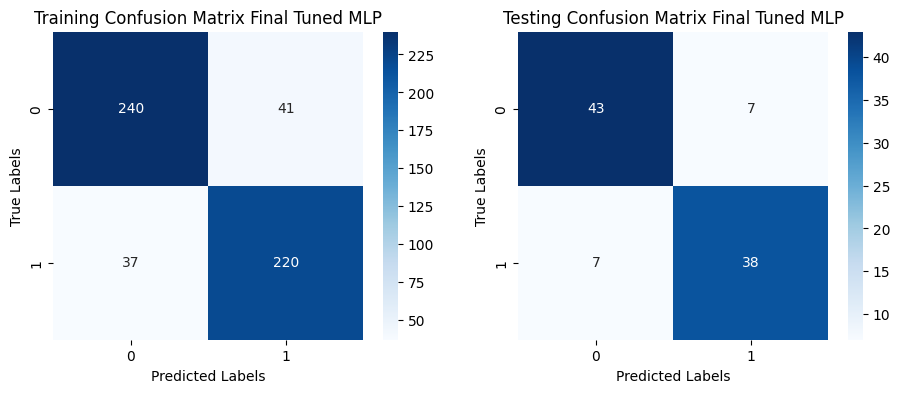

In [66]:
plt.figure(figsize=(11, 4))

#training matrix
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix_final_tuned_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Training Confusion Matrix Final Tuned MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#testing matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix_final_tuned_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Testing Confusion Matrix Final Tuned MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('confusion_matrix_final_tuned_mlp.png')

plt.show()

In [67]:
test_probabilities_final_tuned_mlp_net = final_tuned_mlp_net.predict_proba(X_test_np)
#probabilities_base_mlp_net
#probabilities_base_mlp_net.shape
#y_test_np.shape
test_probabilities_final_tuned_mlp_net = np.squeeze(test_probabilities_final_tuned_mlp_net)
#probabilities_base_mlp_net.shape
test_probabilities_final_tuned_mlp_net = test_probabilities_final_tuned_mlp_net[:, 1]
#probabilities_base_mlp_net.shape
#y_test_np_ravel = y_test_np.ravel()
#y_test_np_ravel.shape

In [68]:
train_probabilities_final_tuned_mlp_net = final_tuned_mlp_net.predict_proba(X_train_np)
train_probabilities_final_tuned_mlp_net = np.squeeze(train_probabilities_final_tuned_mlp_net)
train_probabilities_final_tuned_mlp_net = train_probabilities_final_tuned_mlp_net[:, 1]
#y_train_np_ravel = y_train_np.ravel()

In [69]:
train_auc_final_tuned_mlp_net = roc_auc_score(y_train_np_ravel, train_probabilities_final_tuned_mlp_net)
test_auc_final_tuned_mlp_net = roc_auc_score(y_test_np_ravel, test_probabilities_final_tuned_mlp_net)

print(f"Train AUC Score for Final Tuned MLP: {train_auc_final_tuned_mlp_net:.2f}")
print(f"Test AUC Score for Final tuned MLP: {test_auc_final_tuned_mlp_net:.2f}")

Train AUC Score for Final Tuned MLP: 0.93
Test AUC Score for Final tuned MLP: 0.92


In [70]:
train_fpr_final_tuned_mlp, train_tpr_final_tuned_mlp, _ = roc_curve(y_train_np_ravel, train_probabilities_final_tuned_mlp_net)
train_auc_final_tuned_mlp = auc(train_fpr_final_tuned_mlp, train_tpr_final_tuned_mlp)

test_fpr_final_tuned_mlp, test_tpr_final_tuned_mlp, _ = roc_curve(y_test_np_ravel, test_probabilities_final_tuned_mlp_net)
test_auc_final_tuned_mlp = auc(test_fpr_final_tuned_mlp, test_tpr_final_tuned_mlp)

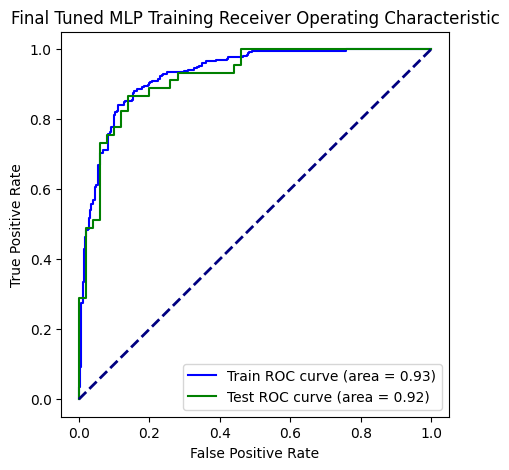

In [71]:
plt.figure(figsize=(5, 5))
plt.plot(train_fpr_final_tuned_mlp, train_tpr_final_tuned_mlp, color='blue', lw=1.5, label=f'Train ROC curve (area = {train_auc_final_tuned_mlp:.2f})')
plt.plot(test_fpr_final_tuned_mlp, test_tpr_final_tuned_mlp, color='green', lw=1.5, label=f'Test ROC curve (area = {test_auc_final_tuned_mlp:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Tuned MLP Training Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_final_tuned_mlp.png')

plt.show()

In [72]:
#initially i was using early stopping on validation precision but this was producing unsavoury errors when tuning with gridsearch
#i was getting worse results than the base model which i randomly selected
#i then switched to stopping when the chosen loss was smallest
#this significantly improved the tuning
#with the final tuned model although we have not been able to significantly improve on the precision metric we have a slight improvement
#this suggests a deeper search of hyperparameters could further improve the results but would also increase the compute cost and time
#classification matrix has slightly improved
#the auc is similar
#because the classification has improved we will go with our tuned model as the best mlp

In [73]:
joblib.dump(final_tuned_mlp_net, 'final_tuned_mlp_net.pkl')
final_tuned_mlp_net = joblib.load('final_tuned_mlp_net.pkl')

### Base SVM

In [74]:
#our data has already been scaled and split
#scaling the data is good for svm since it is distance based and will be sensitive to different scales
#setting up a basic svm with cross validation should be straight forward
#documentation: https://link.springer.com/chapter/10.1007/978-3-540-30549-1_44

#code follows a similar format as described previously

In [75]:
#module has already been imported
#we do not need to build a net like we do for mlp

base_svm = SVC(kernel='linear', probability=True, random_state=75)

In [76]:
train_predictions_base_svm = cross_val_predict(base_svm, X_train_np, y_train_np_ravel, cv=skf)
base_svm.fit(X_train_np, y_train_np_ravel)
test_predictions_base_svm = base_svm.predict(X_test_np)

In [77]:
train_classification_report_base_svm = classification_report(y_train_np_ravel, train_predictions_base_svm)
test_classification_report_base_svm = classification_report(y_test_np_ravel, test_predictions_base_svm)

In [78]:
print('Training Classification Report Base SVM:')
print(train_classification_report_base_svm)
print('--------------------')
print('Test Classification Report Base SVM:')
print(test_classification_report_base_svm)

#seems to be already preforming very well and took not even close to the time of setting up as compared to the net

Training Classification Report Base SVM:
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       281
         1.0       0.85      0.86      0.86       257

    accuracy                           0.86       538
   macro avg       0.86      0.86      0.86       538
weighted avg       0.86      0.86      0.86       538

--------------------
Test Classification Report Base SVM:
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83        50
         1.0       0.80      0.87      0.83        45

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [79]:
train_confusion_matrix_base_svm = confusion_matrix(y_train_np_ravel, train_predictions_base_svm)
test_confusion_matrix_base_svm = confusion_matrix(y_test_np_ravel, test_predictions_base_svm)

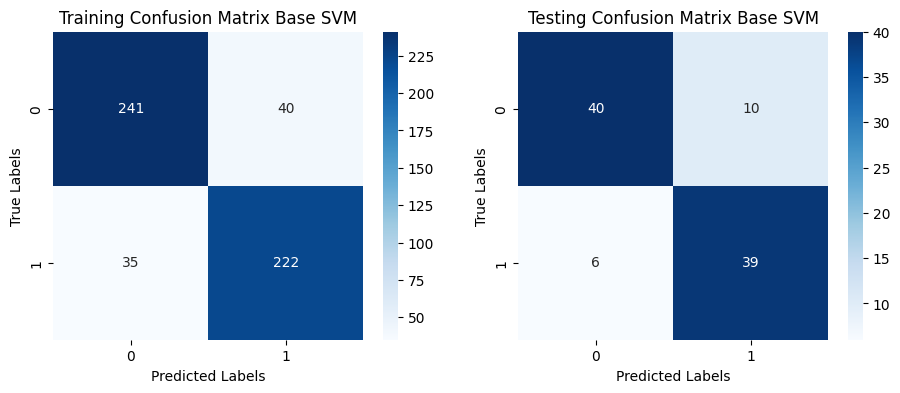

In [80]:
plt.figure(figsize=(11, 4))

#training matrix
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix_base_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Training Confusion Matrix Base SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#testing matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix_base_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Testing Confusion Matrix Base SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('confusion_matrix_base_svm.png')

plt.show()

In [81]:
test_probabilities_base_svm = base_svm.predict_proba(X_test_np)
test_probabilities_base_svm = np.squeeze(test_probabilities_base_svm)
test_probabilities_base_svm = test_probabilities_base_svm[:, 1]

In [82]:
train_probabilities_base_svm = base_svm.predict_proba(X_train_np)
train_probabilities_base_svm = np.squeeze(train_probabilities_base_svm)
train_probabilities_base_svm = train_probabilities_base_svm[:, 1]

In [83]:
train_auc_base_svm = roc_auc_score(y_train_np_ravel, train_probabilities_base_svm)
test_auc_base_svm = roc_auc_score(y_test_np_ravel, test_probabilities_base_svm)

print(f"Train AUC Score for Base SVM: {train_auc_base_svm:.2f}")
print(f"Test AUC Score for Base SVM: {test_auc_base_svm:.2f}")

Train AUC Score for Base SVM: 0.94
Test AUC Score for Base SVM: 0.90


In [84]:
train_fpr_base_svm, train_tpr_base_svm, _ = roc_curve(y_train_np_ravel, train_probabilities_base_svm)
train_auc_base_svm = auc(train_fpr_base_svm, train_tpr_base_svm)

test_fpr_base_svm, test_tpr_base_svm, _ = roc_curve(y_test_np_ravel, test_probabilities_base_svm)
test_auc_base_svm = auc(test_fpr_base_svm, test_tpr_base_svm)

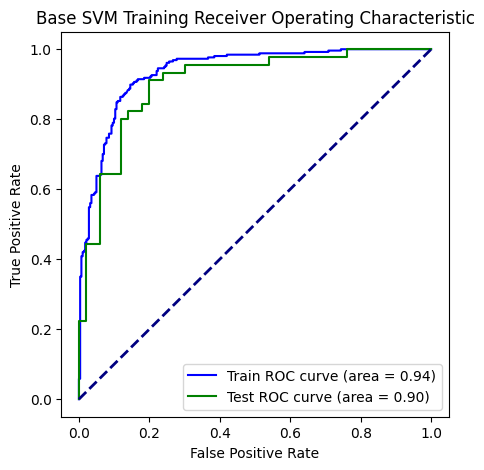

In [85]:
plt.figure(figsize=(5, 5))
plt.plot(train_fpr_base_svm, train_tpr_base_svm, color='blue', lw=1.5, label=f'Train ROC curve (area = {train_auc_base_svm:.2f})')
plt.plot(test_fpr_base_svm, test_tpr_base_svm, color='green', lw=1.5, label=f'Test ROC curve (area = {test_auc_base_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base SVM Training Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_base_svm.png')

plt.show()

In [86]:
joblib.dump(base_svm, 'base_svm.pkl')
base_svm = joblib.load('base_svm.pkl')

### Tuned SVM

#### Tuning the SVM

In [87]:
#setting up a parameter grid to search through
#the parameters include regularization, kernel and depending on the kernel the gamma and degree
#values of gamma come from sklearn and the paper below
#the paper seems to use very small values of gamma that are similar to what is computed when gamme = scale ie a division with the number of features
#have added some larger gammas to test
#the above comes from the following documentation
#documentation: https://link.springer.com/chapter/10.1007/978-3-540-37256-1_87
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#documentation: https://www.researchgate.net/publication/344458945_The_effect_of_gamma_value_on_support_vector_machine_performance_with_different_kernels

#the parameters initally were giving a training precision of 1.0 which signals very serious over fitting
#looking closely at the classification report we saw that the model does not generalize to training sets well
#it can also predict only 1 class ie the postive class perfectly - which is not the worst thing since we want true postives
#to combat the over fitting i played with the value of C (the regularization) multiple times
#C = 0.01 was a very curious case as whenever i left that in the parameter grid the model chose that value and gave imbalanced predictions
#similarly a gamma of 1 also tanked the classification report with severe imbalance in the predictions - 1 class predicted much better than the other
#while some point metrics were bad the auc was still coming out high
#this likely means that a threshold exists for the classification where the model can work better

#not including the above gave the least over fitted result (sensible as it chose a harsher regularization) but the tuning did not improve over the base
#infact while the mlp improved slightly, the svm became slightly worse

#for the sake of comparison we will include the parameters that make the model worse

parameter_grid = {
    'C': [0.001, 0.0001, 0.00001, 1, 10, 
          0.01, 
          0.1],  #this is a regularization terms which adds a penalty for missclassification
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  #similar to acitivation functions - used to transform the input to complex patterns
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.02, 0.001, 
              1, 
              5],  #coefficients for non poly kernel - similar idea to degree
    'degree': [2, 3, 4]  # polynomial degrees - only for poly function - will be ignored by the others - the higher the polynomial the more complex
}

In [88]:
tuned_svm_grid = GridSearchCV(SVC(probability=True, random_state=5), parameter_grid, cv=skf, scoring='precision', verbose=2)

In [89]:
tuned_svm_grid.fit(X_train_np, y_train_np_ravel)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
[CV] END ......C=0.001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=0.001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=5, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=0.001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=scale, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=scale, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=0.001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.00

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=0.001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=0.001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=0.001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=0.001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.00

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=0.001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ....C=0.0001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=auto, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.0001, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.0001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.0001, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.02, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=2, gamma=0.001, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.0001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=5, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.0001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ....C=0.0001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.0001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.0001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.0001, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ....C=0.0001, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.0001, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=5, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.0001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ....C=0.0001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=auto, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.0001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.0001, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.0001, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.0001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ......C=0.0001, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=0.0001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....C=0.0001, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.0001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.0001, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.0001, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.0001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.0001, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END .........C=0.0001, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=5, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.0001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=0.0001, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.0001, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.0001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.0001, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=scale, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=auto, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=auto, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=1e-05, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=1e-05, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.01, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=1e-05, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.01, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.02, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=1e-05, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.001, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1e-05, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=5, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1e-05, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=scale, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=scale, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=auto, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=auto, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=1e-05, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=1e-05, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.01, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=1e-05, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1e-05, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=3, gamma=5, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=3, gamma=5, kernel=linear; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=auto, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=1e-05, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=1e-05, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1e-05, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.1, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=1e-05, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .......C=1e-05, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1e-05, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.02, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=1e-05, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......C=1e-05, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=1e-05, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .....C=1e-05, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=1e-05, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1e-05, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=5, kernel=linear; total time=   0.0s
[CV] END ..........C=1e-05, degree=4, gamma=5, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1e-05, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=1e-05, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ............C=1e-05, degree=4, gamma=5, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1e-05, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1e-05, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degre

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ..........C=1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ..........C=1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .............C=1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..............C=1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=1, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .............C=1, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .............C=1, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .............C=1, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=1, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .............C=1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .............C=1, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..............C=1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .................C=1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .................C=1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .................C=

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=10, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...............C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV] END ...............C=10

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........C=10, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=10, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=10, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=10, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........C=10, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ........C=10, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ........C=10, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ........C=10, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ........C=10, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=10, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ............C=10, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=10, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=10, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=10, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=10, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=10, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=10, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .............C=10, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=10, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...............C=10, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...............C=10

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=2, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=0.01, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.01, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=2, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.01, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.01, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0.01, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=2, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.01, degree=2, gamma=5, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degr

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=0.01, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.01, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=3, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ......C=0.01, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.01, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degre

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=auto, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=0.01, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.01, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.01, degree=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, deg

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.01, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=4, gamma=0.02, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.01, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.02, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.02, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, degree=4, gamma=0.001, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..........C=0.01, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.001, kernel=poly; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .........C=0.01, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.01, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, degree=4, gamma=1, kernel=linear; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.01, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.01, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END .............C=0.01, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.01, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=2, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ..............C=0.1, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degr

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=3, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...............C=0.1, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=3, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.1, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=3, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=3, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, d

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=4, gamma=0.02, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=0.02, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, 

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ........C=0.1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.02, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...........C=0.1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=0.1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s


C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END .......C=0.1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, degree=4, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...............C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.

C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fasih Munir\anaconda3\envs\neural_nets\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

[CV] END ...............C=0.1, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=4, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.1, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=4, gamma=5, kernel=poly; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=4, gamma=5, kernel=sigmoid; total time=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2024, shuffle=True),
             estimator=SVC(probability=True, random_state=5),
             param_grid={'C': [0.001, 0.0001, 1e-05, 1, 10, 0.01, 0.1],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 0.02, 0.001, 1,
                                   5],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='precision', verbose=2)

In [90]:
print("Best train parameters found: ", tuned_svm_grid.best_params_)

Best train parameters found:  {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


In [91]:
print("Best train cross-validation precision score: {:.2f}".format(tuned_svm_grid.best_score_))

Best train cross-validation precision score: 1.00


In [92]:
train_tuned_svm_results = tuned_svm_grid.cv_results_
train_tuned_svm_results_df = pd.DataFrame(train_tuned_svm_results)
train_tuned_svm_results_df.head(1)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.014735      0.001417         0.002448          0.0006   0.001   

  param_degree param_gamma param_kernel  \
0            2       scale       linear   

                                              params  split0_test_score  \
0  {'C': 0.001, 'degree': 2, 'gamma': 'scale', 'k...           0.857143   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                1.0           0.941176                1.0                1.0   

   mean_test_score  std_test_score  rank_test_score  
0         0.959664        0.056095                8

In [93]:
train_tuned_svm_results_relevant_columns = ['param_C', 'param_degree',
                                            'param_gamma', 'param_kernel',
                                           'mean_test_score']

train_tuned_svm_filtered_results_df =train_tuned_svm_results_df[train_tuned_svm_results_relevant_columns]
train_tuned_svm_filtered_results_df.rename(columns={'param_C': 'C', 
                                                    'param_degree': 'degree', 
                                                    'param_gamma': 'gamma', 
                                                    'param_kernel': 'kernel', 
                                                    'mean_test_score': 'mean_precision'
                                                    }, 
                                           inplace=True)

train_tuned_svm_filtered_results_df = train_tuned_svm_filtered_results_df.sort_values(by='mean_precision', ascending=False)
train_tuned_svm_filtered_results_df

C:\Users\Fasih Munir\AppData\Local\Temp\ipykernel_16136\2078684708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tuned_svm_filtered_results_df.rename(columns={'param_C': 'C',


C degree  gamma   kernel  mean_precision
633      0.1      3      1      rbf        1.000000
665      0.1      4      1      rbf        1.000000
601      0.1      2      1      rbf        1.000000
523     0.01      3    0.1  sigmoid        0.977778
491     0.01      2    0.1  sigmoid        0.977778
..       ...    ...    ...      ...             ...
234  0.00001      3    0.1     poly        0.000000
235  0.00001      3    0.1  sigmoid        0.000000
49     0.001      3   0.02      rbf        0.000000
236  0.00001      3   0.01   linear        0.000000
117   0.0001      2  0.001      rbf        0.000000

[672 rows x 5 columns]

#### Final Tuned SVM

In [94]:
final_tuned_svm = SVC(C=0.1, 
                      kernel='rbf', 
                      gamma=1,
                      #degree=2,
                      probability=True, 
                      random_state=9)

In [95]:
final_tuned_svm.fit(X_train_np, y_train_np_ravel)

SVC(C=0.1, gamma=1, probability=True, random_state=9)

In [96]:
train_predictions_final_tuned_svm = cross_val_predict(final_tuned_svm, X_train_np, y_train_np_ravel, cv=skf)
test_predictions_final_tuned_svm = final_tuned_svm.predict(X_test_np)

In [97]:
train_classification_report_final_tuned_svm = classification_report(y_train_np_ravel, train_predictions_final_tuned_svm)
test_classification_report_final_tuned_svm = classification_report(y_test_np_ravel, test_predictions_final_tuned_svm)

In [98]:
print('Training Classification Report Final Tuned SVM:')
print(train_classification_report_final_tuned_svm)
print('--------------------')
print('Test Classification Report Final Tuned SVM:')
print(test_classification_report_final_tuned_svm)

Training Classification Report Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       281
         1.0       1.00      0.06      0.12       257

    accuracy                           0.55       538
   macro avg       0.77      0.53      0.41       538
weighted avg       0.76      0.55      0.42       538

--------------------
Test Classification Report Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.57      0.98      0.72        50
         1.0       0.89      0.18      0.30        45

    accuracy                           0.60        95
   macro avg       0.73      0.58      0.51        95
weighted avg       0.72      0.60      0.52        95



In [99]:
train_confusion_matrix_final_tuned_svm = confusion_matrix(y_train_np_ravel, train_predictions_final_tuned_svm)
test_confusion_matrix_final_tuned_svm = confusion_matrix(y_test_np_ravel, test_predictions_final_tuned_svm)

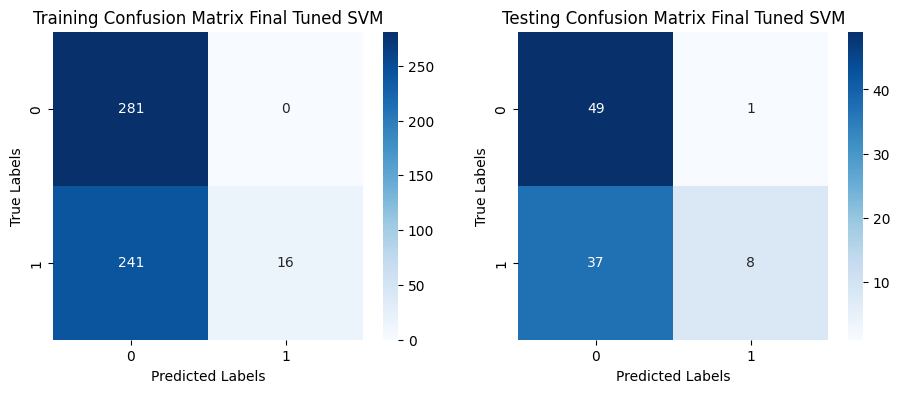

In [100]:
plt.figure(figsize=(11, 4))

#training matrix
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix_final_tuned_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Training Confusion Matrix Final Tuned SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#testing matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix_final_tuned_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Testing Confusion Matrix Final Tuned SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('confusion_matrix_final_tuned_svm.png')

plt.show()

In [101]:
test_probabilities_final_tuned_svm = final_tuned_svm.predict_proba(X_test_np)
test_probabilities_final_tuned_svm = np.squeeze(test_probabilities_final_tuned_svm)
test_probabilities_final_tuned_svm = test_probabilities_final_tuned_svm[:, 1]

In [102]:
train_probabilities_final_tuned_svm = final_tuned_svm.predict_proba(X_train_np)
train_probabilities_final_tuned_svm = np.squeeze(train_probabilities_final_tuned_svm)
train_probabilities_final_tuned_svm = train_probabilities_final_tuned_svm[:, 1]

In [103]:
train_auc_final_tuned_svm = roc_auc_score(y_train_np_ravel, train_probabilities_final_tuned_svm)
test_auc_final_tuned_svm = roc_auc_score(y_test_np_ravel, test_probabilities_final_tuned_svm)

print(f"Train AUC Score for Final Tuned SVM: {train_auc_final_tuned_svm:.2f}")
print(f"Test AUC Score for Final Tuned SVM: {test_auc_final_tuned_svm:.2f}")

Train AUC Score for Final Tuned SVM: 0.97
Test AUC Score for Final Tuned SVM: 0.86


In [104]:
train_fpr_final_tuned_svm, train_tpr_final_tuned_svm, _ = roc_curve(y_train_np_ravel, train_probabilities_final_tuned_svm)
train_auc_final_tuned_svm = auc(train_fpr_final_tuned_svm, train_tpr_final_tuned_svm)

test_fpr_final_tuned_svm, test_tpr_final_tuned_svm, _ = roc_curve(y_test_np_ravel, test_probabilities_final_tuned_svm)
test_auc_final_tuned_svm = auc(test_fpr_final_tuned_svm, test_tpr_final_tuned_svm)

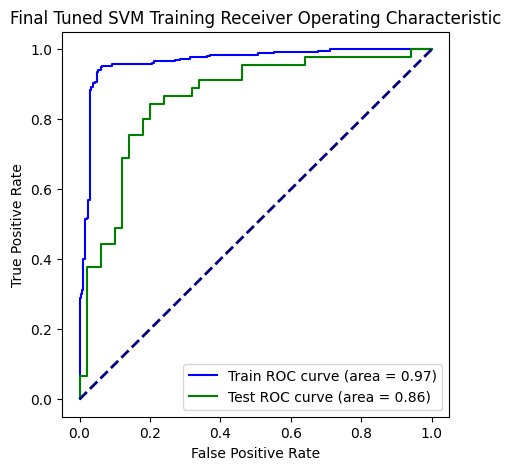

In [105]:
plt.figure(figsize=(5, 5))
plt.plot(train_fpr_final_tuned_svm, train_tpr_final_tuned_svm, color='blue', lw=1.5, label=f'Train ROC curve (area = {train_auc_final_tuned_svm:.2f})')
plt.plot(test_fpr_final_tuned_svm, test_tpr_final_tuned_svm, color='green', lw=1.5, label=f'Test ROC curve (area = {test_auc_final_tuned_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Tuned SVM Training Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_final_tuned_svm.png')

plt.show()

In [106]:
joblib.dump(final_tuned_svm, 'final_tuned_svm.pkl')
final_tuned_svm = joblib.load('final_tuned_svm.pkl')

##### The Better Tuned SVM

Creating to show in the report. Builds on what I mentioned about the regularization values. The other best parameters when I changed the grid resulted in the following

In [107]:
appendix_final_tuned_svm = SVC(C=0.1, 
                      kernel='poly', 
                      #gamma=1,
                      degree=2,
                      probability=True, 
                      random_state=9)

In [108]:
appendix_final_tuned_svm.fit(X_train_np, y_train_np_ravel)

SVC(C=0.1, degree=2, kernel='poly', probability=True, random_state=9)

In [109]:
appendix_train_predictions_final_tuned_svm = cross_val_predict(appendix_final_tuned_svm, X_train_np, y_train_np_ravel, cv=skf)
appendix_test_predictions_final_tuned_svm = appendix_final_tuned_svm.predict(X_test_np)

In [110]:
appendix_train_classification_report_final_tuned_svm = classification_report(y_train_np_ravel, appendix_train_predictions_final_tuned_svm)
appendix_test_classification_report_final_tuned_svm = classification_report(y_test_np_ravel, appendix_test_predictions_final_tuned_svm)

In [111]:
print('Training Classification Report Appendix Final Tuned SVM:')
print(appendix_train_classification_report_final_tuned_svm)
print('--------------------')
print('Test Classification Report Appendix Final Tuned SVM:')
print(appendix_test_classification_report_final_tuned_svm)

Training Classification Report Appendix Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82       281
         1.0       0.87      0.68      0.77       257

    accuracy                           0.80       538
   macro avg       0.81      0.79      0.79       538
weighted avg       0.81      0.80      0.80       538

--------------------
Test Classification Report Appendix Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85        50
         1.0       0.87      0.76      0.81        45

    accuracy                           0.83        95
   macro avg       0.84      0.83      0.83        95
weighted avg       0.84      0.83      0.83        95



## Results

### Classification Reports

In [112]:
print('Training Classification Report Base MLP:')
print(train_classification_report_base_mlp)
print('--------------------')
print('Test Classification Report Base MLP:')
print(test_classification_report_base_mlp)

Training Classification Report Base MLP:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       281
         1.0       0.82      0.85      0.84       257

    accuracy                           0.84       538
   macro avg       0.84      0.84      0.84       538
weighted avg       0.84      0.84      0.84       538

--------------------
Test Classification Report Base MLP:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84        50
         1.0       0.81      0.84      0.83        45

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [113]:
print('Training Classification Report Final Tuned MLP:')
print(train_classification_report_final_tuned_mlp)
print('--------------------')
print('Test Classification Report Final Tuned MLP:')
print(test_classification_report_final_tuned_mlp)

Training Classification Report Final Tuned MLP:
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       281
         1.0       0.84      0.86      0.85       257

    accuracy                           0.86       538
   macro avg       0.85      0.86      0.85       538
weighted avg       0.86      0.86      0.86       538

--------------------
Test Classification Report Final Tuned MLP:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        50
         1.0       0.84      0.84      0.84        45

    accuracy                           0.85        95
   macro avg       0.85      0.85      0.85        95
weighted avg       0.85      0.85      0.85        95



In [114]:
print('Training Classification Report Base SVM:')
print(train_classification_report_base_svm)
print('--------------------')
print('Test Classification Report Base SVM:')
print(test_classification_report_base_svm)

Training Classification Report Base SVM:
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       281
         1.0       0.85      0.86      0.86       257

    accuracy                           0.86       538
   macro avg       0.86      0.86      0.86       538
weighted avg       0.86      0.86      0.86       538

--------------------
Test Classification Report Base SVM:
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83        50
         1.0       0.80      0.87      0.83        45

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [115]:
print('Training Classification Report Final Tuned SVM:')
print(train_classification_report_final_tuned_svm)
print('--------------------')
print('Test Classification Report Final Tuned SVM:')
print(test_classification_report_final_tuned_svm)

Training Classification Report Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       281
         1.0       1.00      0.06      0.12       257

    accuracy                           0.55       538
   macro avg       0.77      0.53      0.41       538
weighted avg       0.76      0.55      0.42       538

--------------------
Test Classification Report Final Tuned SVM:
              precision    recall  f1-score   support

         0.0       0.57      0.98      0.72        50
         1.0       0.89      0.18      0.30        45

    accuracy                           0.60        95
   macro avg       0.73      0.58      0.51        95
weighted avg       0.72      0.60      0.52        95



### Confusion Matrices

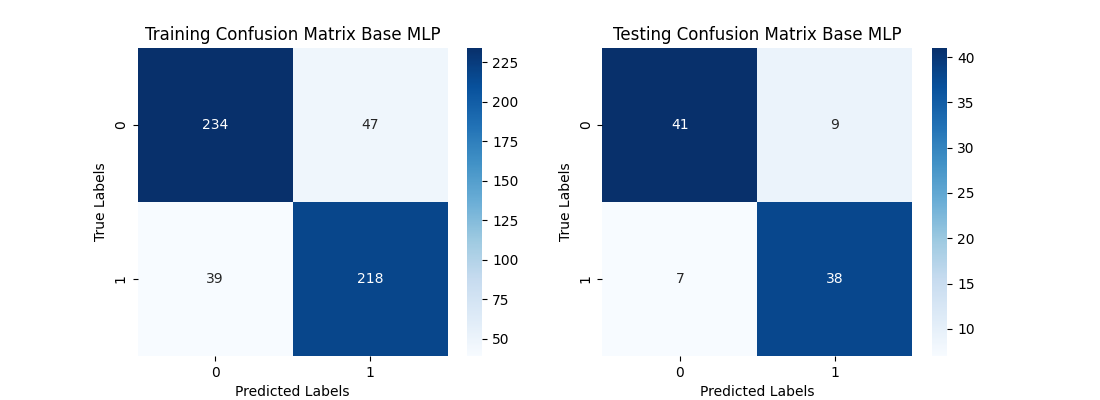

In [116]:
Image(filename='confusion_matrix_base_mlp.png')

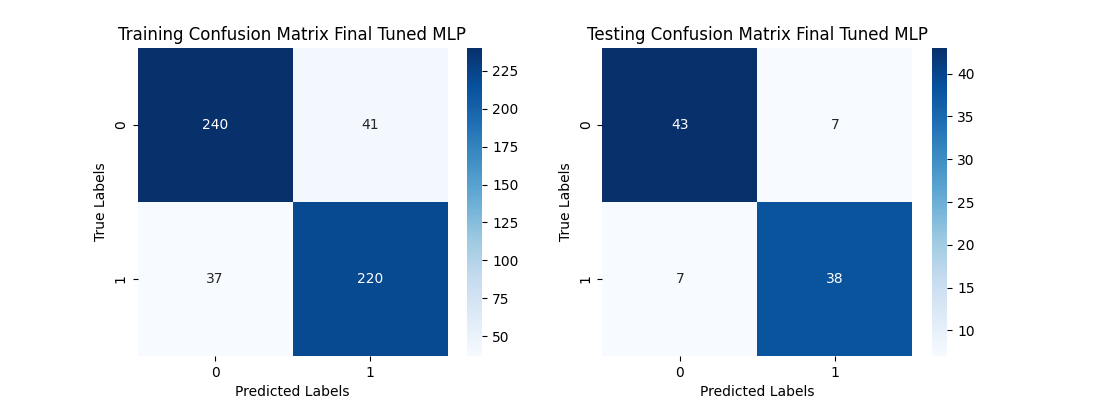

In [117]:
Image(filename='confusion_matrix_final_tuned_mlp.png')

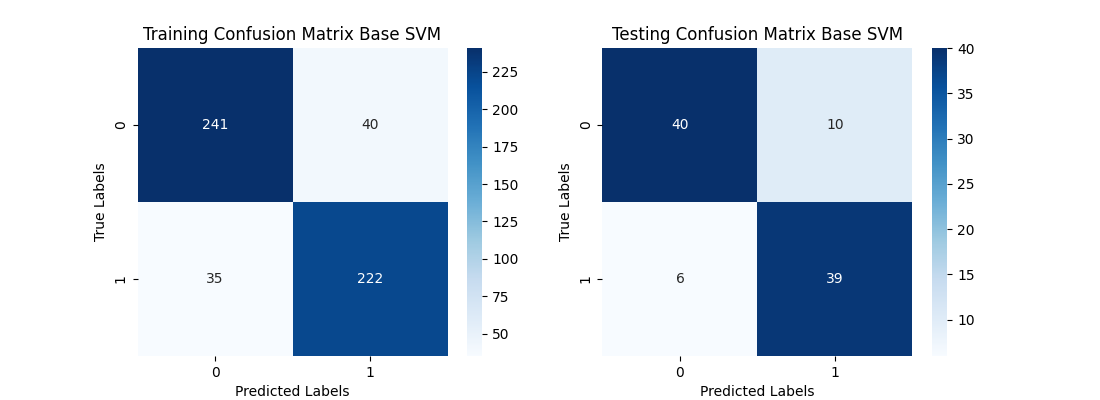

In [118]:
Image(filename='confusion_matrix_base_svm.png')

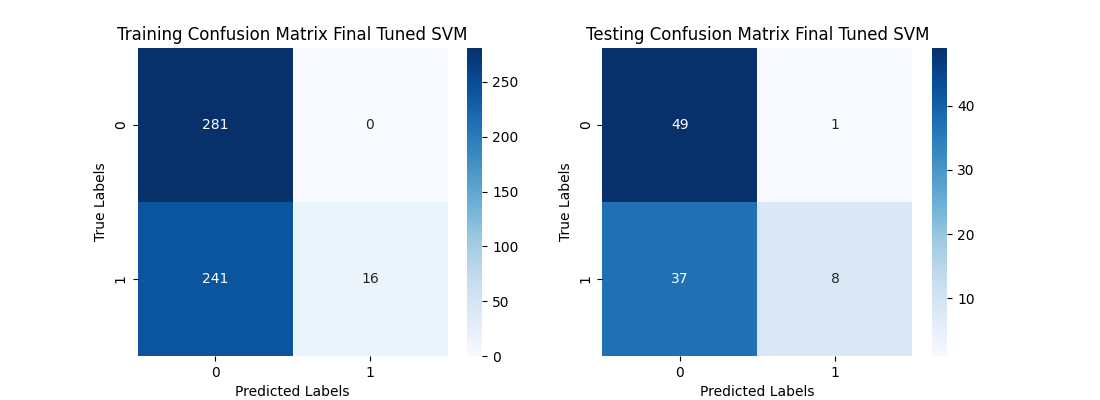

In [119]:
Image(filename='confusion_matrix_final_tuned_svm.png')

### AUC Scores

In [120]:
print(f"Train AUC Score for Base MLP: {train_auc_base_mlp_net:.2f}")
print(f"Test AUC Score for Base MLP: {test_auc_base_mlp_net:.2f}")

Train AUC Score for Base MLP: 0.94
Test AUC Score for Base MLP: 0.91


In [121]:
print(f"Train AUC Score for Final Tuned MLP: {train_auc_final_tuned_mlp_net:.2f}")
print(f"Test AUC Score for Final Tuned MLP: {test_auc_final_tuned_mlp_net:.2f}")

Train AUC Score for Final Tuned MLP: 0.93
Test AUC Score for Final Tuned MLP: 0.92


In [122]:
print(f"Train AUC Score for Base SVM: {train_auc_base_svm:.2f}")
print(f"Test AUC Score for Base SVM: {test_auc_base_svm:.2f}")

Train AUC Score for Base SVM: 0.94
Test AUC Score for Base SVM: 0.90


In [123]:
print(f"Train AUC Score for Final Tuned SVM: {train_auc_final_tuned_svm:.2f}")
print(f"Test AUC Score for Final Tuned SVM: {test_auc_final_tuned_svm:.2f}")

Train AUC Score for Final Tuned SVM: 0.97
Test AUC Score for Final Tuned SVM: 0.86


### ROC Curves

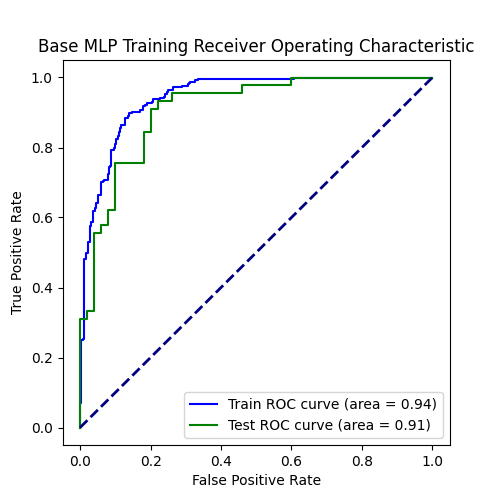

In [124]:
Image(filename='roc_curve_base_mlp.png')

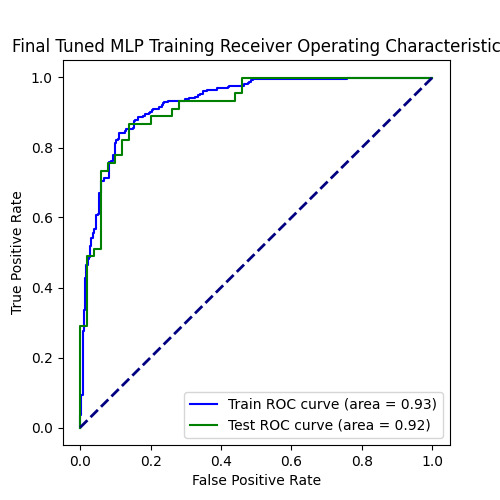

In [125]:
Image(filename='roc_curve_final_tuned_mlp.png')

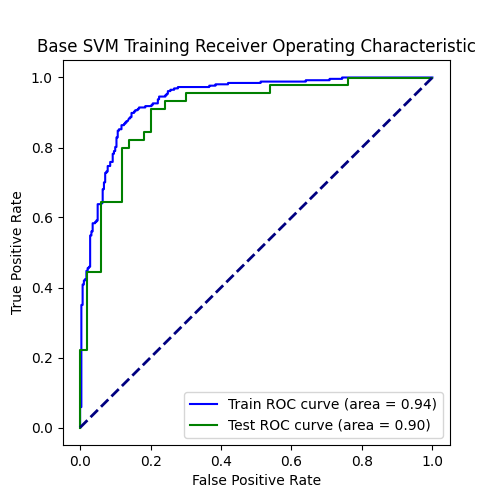

In [126]:
Image(filename='roc_curve_base_svm.png')

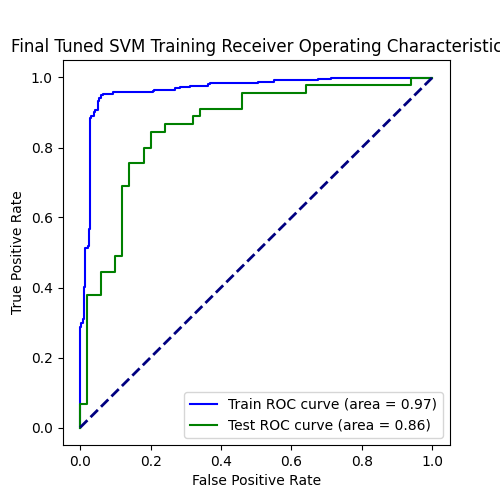

In [128]:
Image(filename='roc_curve_final_tuned_svm.png')

In [129]:
#CODE IS GOOD TILL HERE